[I 2025-01-02 10:40:21,558] A new study created in memory with name: no-name-a81add71-d010-4ef3-9626-fc3484ad5819
Training with privacy: 100%|███████████████████████████████████████████████████████| 2130/2130 [00:05<00:00, 395.70it/s]


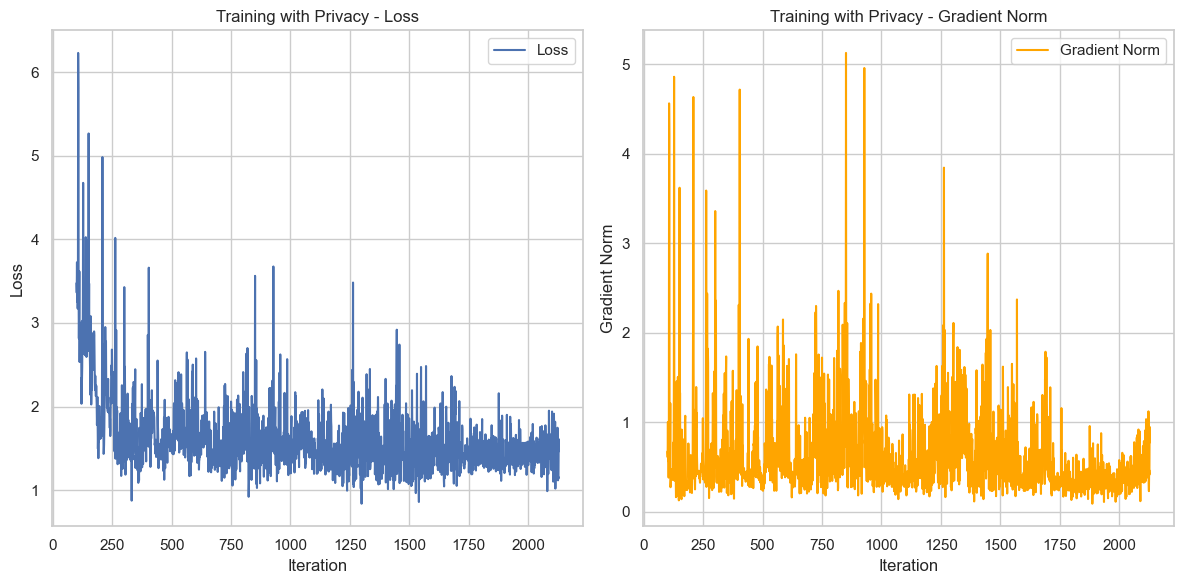

[I 2025-01-02 10:40:27,911] Trial 0 finished with value: 1.4645565748214722 and parameters: {'constraint': 88.9310933764657, 'minibatch_size': 14, 'num_iters': 2130, 'lipschitz': 0.9297902168516737}. Best is trial 0 with value: 1.4645565748214722.
Training with privacy: 100%|███████████████████████████████████████████████████████| 1520/1520 [00:03<00:00, 418.00it/s]


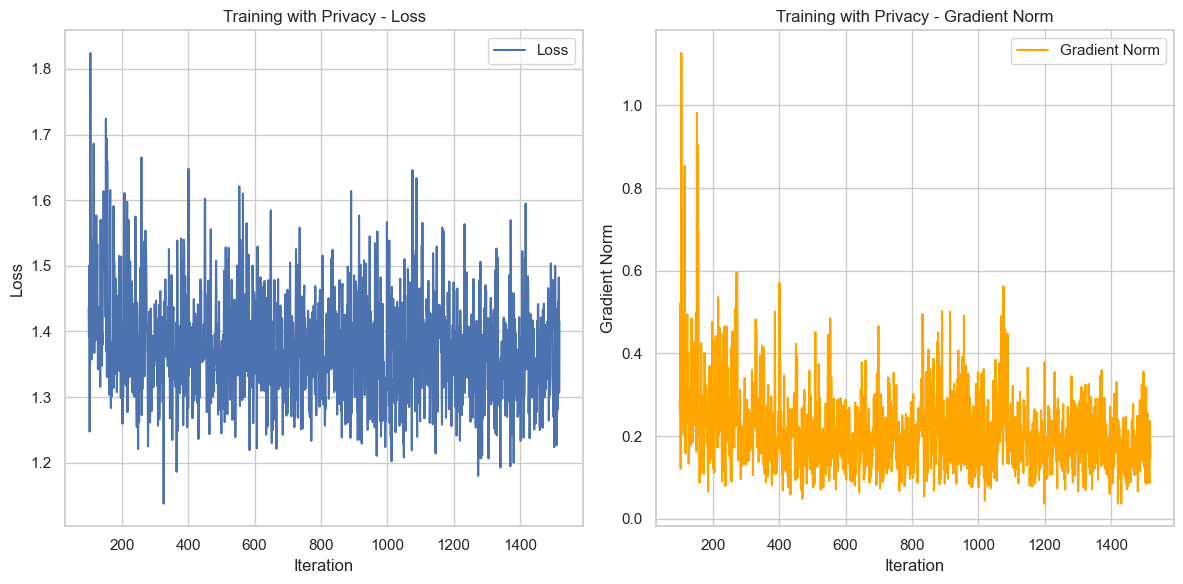

[I 2025-01-02 10:40:32,441] Trial 1 finished with value: 1.4152719974517822 and parameters: {'constraint': 30.354164469125074, 'minibatch_size': 98, 'num_iters': 1520, 'lipschitz': 0.12921071608975782}. Best is trial 1 with value: 1.4152719974517822.
Training with privacy: 100%|███████████████████████████████████████████████████████| 3495/3495 [00:08<00:00, 411.59it/s]


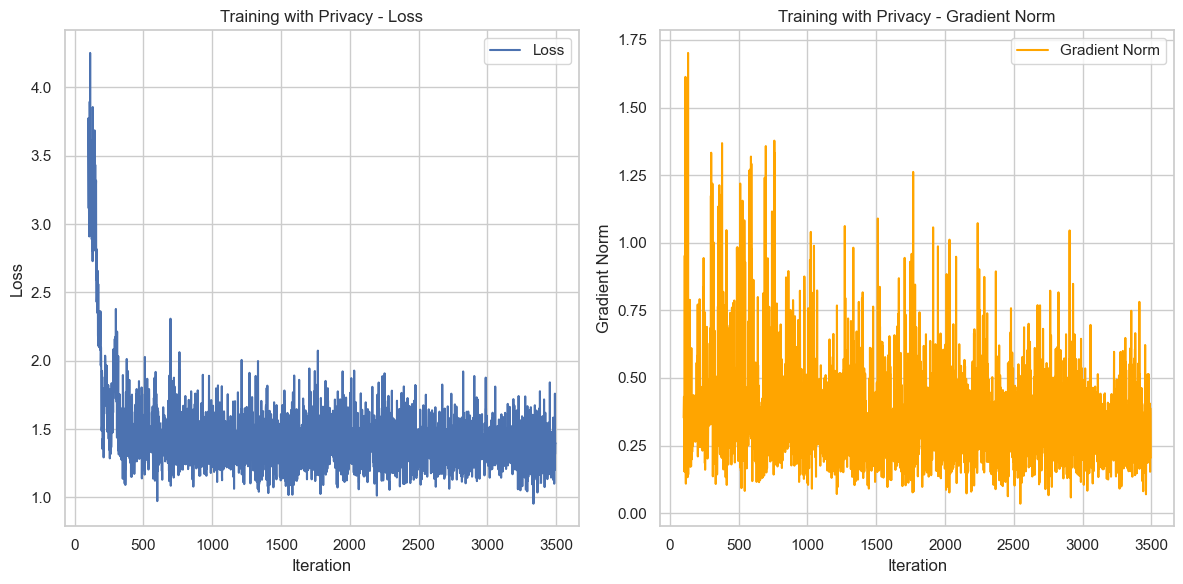

[I 2025-01-02 10:40:41,853] Trial 2 finished with value: 1.3939622640609741 and parameters: {'constraint': 78.82690210337317, 'minibatch_size': 24, 'num_iters': 3495, 'lipschitz': 0.20817578737439663}. Best is trial 2 with value: 1.3939622640609741.
Training with privacy: 100%|███████████████████████████████████████████████████████| 3495/3495 [00:08<00:00, 408.09it/s]


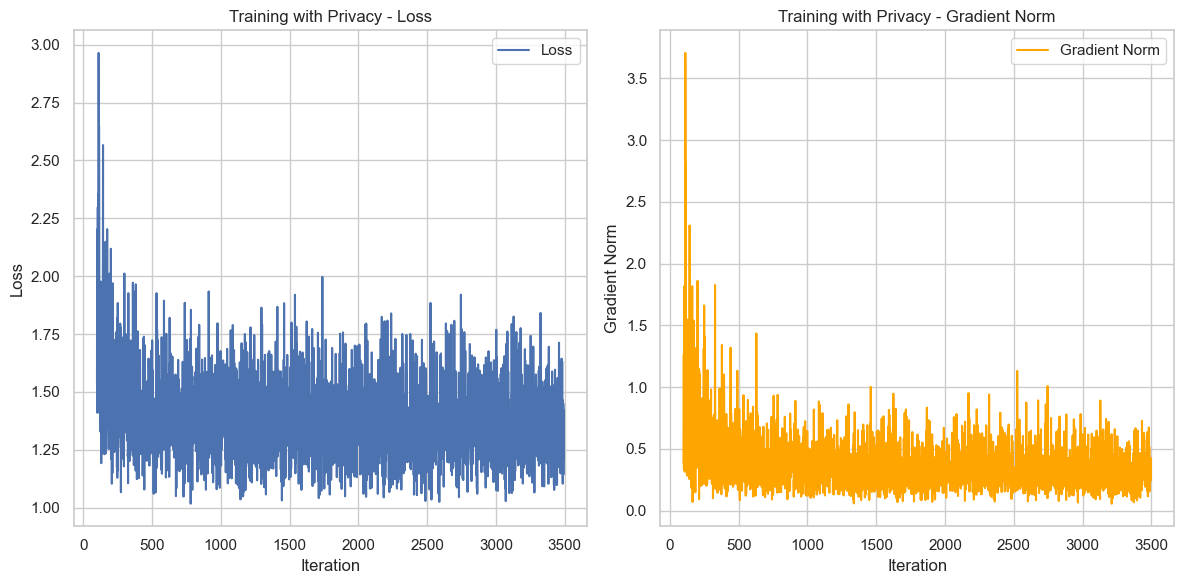

In [4]:
import optuna
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import halfnorm
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import statsmodels.api as sm
import pandas as pd
import math
import os
from tqdm import tqdm  # 添加进度条支持
from sklearn.model_selection import train_test_split, KFold
# Stochastic Frontier Model类
class StochasticFrontierModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor(num_features * [1.0], dtype=torch.float32))
        self.log_sigma2 = nn.Parameter(torch.tensor(0.0))
        self.log_lambda0 = nn.Parameter(torch.tensor(0.0))

    def predict(self, x):
        # 使用 torch.matmul 执行矩阵乘法
        predictions = torch.matmul(x, self.beta)
        return predictions

    def forward(self, x, y):
        sigma2 = torch.exp(self.log_sigma2)
        lambda0 = torch.exp(self.log_lambda0)
        sigma = torch.sqrt(sigma2)
        epsilon = y - torch.sum(x * self.beta, dim=1)

        term1 = x.shape[0] * self.log_sigma2 / 2
        term2 = -torch.sum(torch.log(torch.distributions.normal.Normal(0, 1).cdf(-epsilon * lambda0 / sigma) + 1e-10))
        term3 = torch.sum(epsilon**2) / (2 * sigma2)

        return (term1 + term2 + term3) / x.shape[0]

class StochasticFrontierAnalysis:
    def __init__(self, num_features, beta, sigma_u, sigma_v):
        self.num_features = num_features
        self.beta = beta
        self.sigma_u = sigma_u
        self.sigma_v = sigma_v

    def standardize_data(self, x):
        mean = np.mean(x[:, 1:], axis=0)
        std = np.std(x[:, 1:], axis=0)
        x_standardized = np.column_stack([x[:, 0], (x[:, 1:] - mean) / std])
        return x_standardized, np.insert(mean, 0, 0), np.insert(std, 0, 1)

    def generate_data(self, N):
        x1 = np.random.uniform(0, 1, N)
        x_random = np.random.normal(0, 1, (N, self.num_features - 1))
        x = np.hstack([x1.reshape(-1, 1), x_random])
        v = np.random.normal(0, self.sigma_v, N)
        u = stats.halfnorm.rvs(loc=0, scale=self.sigma_u, size=N)
        y = x.dot(self.beta) + v - u
        return x, y

    def stochastic_frontier_mle(self, x, y):
        # 将 x 和 y 转换为 pandas.DataFrame 和 pandas.Series
        x_df = pd.DataFrame(x)
        y_series = pd.Series(y)

        def logLikFun(param):
            const = param[0]
            parlab = param[:-2]
            parsigmaSq = param[-2]
            parlambda = param[-1]
            epsilon = y_series - 0 - np.dot(x_df, parlab)
            return -np.sum(0.5 * np.log(parsigmaSq) + 0.5 / parsigmaSq * epsilon**2 -
                           norm.logcdf(-epsilon * parlambda / np.sqrt(parsigmaSq)))

        # 使用最小二乘法获取初始参数
        ols = sm.OLS(y_series, x_df).fit()
        init_params = np.append(ols.params.values, [0.5, sum(ols.resid**2) / (len(y_series) - len(ols.params))])

        # 极大似然估计
        result = minimize(lambda params: -logLikFun(params), init_params, method='Nelder-Mead')

        # 提取估计的参数
        beta = result.x[:-2]  # 提取 beta 参数
        sigma_sq = result.x[-2]  # 提取 sigma^2
        lambda_ = result.x[-1]  # 提取 lambda

        # 计算 MSE
        epsilon = y_series - np.dot(x_df, beta)
        mse = np.mean(epsilon**2)

        return beta, lambda_, sigma_sq, mse, -logLikFun(result.x)

    def train_model_without_private(self, x, y, num_iters=3000, constraint=100, minibatch_size=50):
        x, mean, std = self.standardize_data(x)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        model = StochasticFrontierModel(num_features=self.num_features)
        losses = []
        gradients = []
        parameters = []

        for i in tqdm(range(1, num_iters + 1), desc="Training without privacy"):
            minibatch_indices = np.random.choice(x.shape[0], minibatch_size, replace=True)
            minibatch_x = x[minibatch_indices]
            minibatch_y = y[minibatch_indices]
            loss = model(minibatch_x, minibatch_y)
            loss.backward()
            gradient = torch.cat([p.grad.flatten() for p in model.parameters()]).detach().numpy()
            pos_alphas = self.compute_alpha(constraint, gradient, model)
            neg_alphas = self.compute_alpha(-constraint, gradient, model)
            alphas = pos_alphas + neg_alphas
            min_alpha, size, corner_num = min(alphas, key=lambda x: x[0])
            corner = np.zeros(sum(p.numel() for p in model.parameters()))
            corner[corner_num] = size
            mu = 2 / (i + 2)
            with torch.no_grad():
                index = 0
                for p in model.parameters():
                    numel = p.numel()
                    p_flat = p.view(-1)
                    p_flat.copy_((1 - mu) * p_flat + mu * torch.tensor(corner[index:index+numel], dtype=torch.float32))
                    index += numel
            losses.append(loss.item())
            gradients.append(np.linalg.norm(gradient))  # 记录梯度的范数
            parameters.append(model.state_dict().copy())
            model.zero_grad()

        min_loss_index = np.argmin(losses)
        model.load_state_dict(parameters[min_loss_index])

        # 可视化损失和梯度，忽略前 50 次迭代
        self.plot_training_process(losses, gradients, "Training without Privacy", ignore_first_n=100)
        return model, mean, std, losses[-1], self.calculate_mse(model, x, y)

    def train_model_private(self, x, y, num_iters=3000, constraint=100, minibatch_size=50, lipschitz=1, epsilon=0.1, delta=1e-5):
        x, mean, std = self.standardize_data(x)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        model = StochasticFrontierModel(num_features=self.num_features)
        n = x.shape[0]
        m = sum(p.numel() for p in model.parameters())
        losses = []
        gradients = []
        parameters = []
        noise_para = lipschitz * constraint * math.sqrt(8 * num_iters * math.log(1 / delta)) / (n * epsilon)

        for i in tqdm(range(1, num_iters + 1), desc="Training with privacy"):
            minibatch_indices = np.random.choice(x.shape[0], minibatch_size, replace=True)
            minibatch_x = x[minibatch_indices]
            minibatch_y = y[minibatch_indices]
            loss = model(minibatch_x, minibatch_y)
            loss.backward()
            gradient = torch.cat([p.grad.flatten() for p in model.parameters()]).detach().numpy()
            pos_alphas = self.compute_alpha_private(constraint, gradient, model, noise_para)
            neg_alphas = self.compute_alpha_private(-constraint, gradient, model, noise_para)
            alphas = pos_alphas + neg_alphas
            min_alpha, size, corner_num = min(alphas, key=lambda x: x[0])
            corner = np.zeros(m)
            corner[corner_num] = size
            mu = 2 / (i + 2)
            with torch.no_grad():
                index = 0
                for p in model.parameters():
                    numel = p.numel()
                    p_flat = p.view(-1)
                    p_flat.copy_((1 - mu) * p_flat + mu * torch.tensor(corner[index:index+numel], dtype=torch.float32))
                    index += numel
            losses.append(loss.item())
            gradients.append(np.linalg.norm(gradient))  # 记录梯度的范数
            parameters.append(model.state_dict().copy())
            model.zero_grad()

        min_loss_index = np.argmin(losses)
        model.load_state_dict(parameters[min_loss_index])

        # 可视化损失和梯度，忽略前 50 次迭代
        self.plot_training_process(losses, gradients, "Training with Privacy", ignore_first_n=100)
        return model, mean, std, losses[-1], self.calculate_mse(model, x, y)

    def compute_alpha(self, corner_size, gradient, model):
        alpha = gradient * corner_size
        corner_size = (np.ones(sum(p.numel() for p in model.parameters())) * corner_size).tolist()
        corner_num = np.arange(sum(p.numel() for p in model.parameters())).tolist()
        return list(zip(alpha, corner_size, corner_num))

    def compute_alpha_private(self, corner_size, gradient, model, noise_para):
        alpha = gradient * corner_size
        noise = np.random.laplace(scale=noise_para, size=sum(p.numel() for p in model.parameters()))
        alpha = alpha + noise
        corner_size = (np.ones(sum(p.numel() for p in model.parameters())) * corner_size).tolist()
        corner_num = np.arange(sum(p.numel() for p in model.parameters())).tolist()
        return list(zip(alpha, corner_size, corner_num))

    def calculate_mse(self, model, x, y):
        with torch.no_grad():
            predictions = model.predict(x)
            mse = torch.mean((predictions - y) ** 2).item()
        return mse

    def optimize_hyperparameters(self, x, y, method, num_trials=3):
        def objective(trial):
            # 公共超参数
            constraint = trial.suggest_float('constraint', 1, 100)
            minibatch_size = trial.suggest_int('minibatch_size', 10, 100)
            num_iters = trial.suggest_int('num_iters', 1000, 5000)

            if method == 'private':
                # 私有方法特有的超参数
                lipschitz = trial.suggest_float('lipschitz', 0.1, 1)
                model, _, _, loss, mse = self.train_model_private(
                    x, y, num_iters=num_iters, constraint=constraint, 
                    minibatch_size=minibatch_size, lipschitz=lipschitz
                )
            else:
                # 非私有方法不需要 lipschitz 参数
                model, _, _, loss, mse = self.train_model_without_private(
                    x, y, num_iters=num_iters, constraint=constraint, 
                    minibatch_size=minibatch_size
                )
            return loss

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=num_trials)
        return study.best_params

    def plot_training_process(self, losses, gradients, title, ignore_first_n=50):
        """
        绘制训练过程中的损失和梯度变化
        :param losses: 损失列表
        :param gradients: 梯度范数列表
        :param title: 图表标题
        :param ignore_first_n: 忽略前 n 次迭代的极端值
        """
        plt.figure(figsize=(12, 6))

        # 绘制损失曲线
        plt.subplot(1, 2, 1)
        plt.plot(range(ignore_first_n, len(losses)), losses[ignore_first_n:], label='Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title(f'{title} - Loss')
        plt.legend()

        # 如果损失范围较大，使用对数尺度
        if max(losses[ignore_first_n:]) / min(losses[ignore_first_n:]) > 100:
            plt.yscale('log')

        # 绘制梯度范数曲线
        plt.subplot(1, 2, 2)
        plt.plot(range(ignore_first_n, len(gradients)), gradients[ignore_first_n:], label='Gradient Norm', color='orange')
        plt.xlabel('Iteration')
        plt.ylabel('Gradient Norm')
        plt.title(f'{title} - Gradient Norm')
        plt.legend()

        # 如果梯度范数范围较大，使用对数尺度
        if max(gradients[ignore_first_n:]) / min(gradients[ignore_first_n:]) > 100:
            plt.yscale('log')

        plt.tight_layout()
        plt.show()
    

    def run_experiments(self, N_values, epsilon_values, num_repeats=1):
        
        results = []
        for N in N_values:
            x, y = self.generate_data(N)
            # 划分训练集和测试集
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
            pd.DataFrame(np.hstack([x, y.reshape(-1, 1)]), columns=[f'x{i}' for i in range(self.num_features)] + ['y']).to_csv(f'data_{N}.csv', index=False)
            for epsilon in epsilon_values:
                #for method in ['mle', 'without_private', 'private']:
                for method in [ 'private']:
                    if method == 'mle':
                        # MLE 方法不需要超参数优化
                        beta_list, lambda_list, sigma_sq_list, mse_list, loss_list = [], [], [], [], []
                        for _ in range(num_repeats):
                            beta, lambda_, sigma_sq, mse, loss = self.stochastic_frontier_mle(x_train, y_train)
                            beta_list.append(beta)
                            lambda_list.append(lambda_)
                            sigma_sq_list.append(sigma_sq)
                            # 在测试集上计算 MSE
                            y_pred = x_test.dot(beta)
                            test_mse = np.mean((y_test - y_pred) ** 2)
                            mse_list.append(test_mse)
                            loss_list.append(loss)
                        # 计算平均值
                        avg_beta = np.mean(beta_list, axis=0)
                        avg_lambda = np.mean(lambda_list)
                        avg_sigma_sq = np.mean(sigma_sq_list)
                        avg_mse = np.mean(mse_list)
                        avg_loss = np.mean(loss_list)
                        hyperparams = {}
                    else:
                        # 使用交叉验证优化超参数
                        hyperparams = self.optimize_hyperparameters(x_train, y_train, method)
                        beta_list, lambda_list, sigma_sq_list, mse_list, loss_list = [], [], [], [], []
                        for _ in range(num_repeats):
                            if method == 'private':
                                model, _, _, loss, mse = self.train_model_private(x_train, y_train, **hyperparams, epsilon=epsilon)
                            else:
                                model, _, _, loss, mse = self.train_model_without_private(x_train, y_train, **hyperparams)
                            beta_list.append(model.beta.detach().numpy())
                            lambda_list.append(torch.exp(model.log_lambda0).item())
                            sigma_sq_list.append(torch.exp(model.log_sigma2).item())
                            # 在测试集上计算 MSE
                            with torch.no_grad():
                                y_pred = model.predict(torch.tensor(x_test, dtype=torch.float32)).numpy()
                                test_mse = np.mean((y_test - y_pred) ** 2)
                            mse_list.append(test_mse)
                            loss_list.append(loss)
                        # 计算平均值
                        avg_beta = np.mean(beta_list, axis=0)
                        avg_lambda = np.mean(lambda_list)
                        avg_sigma_sq = np.mean(sigma_sq_list)
                        avg_mse = np.mean(mse_list)
                        avg_loss = np.mean(loss_list)
        
                    # 保存结果
                    results.append({
                        'N': N,
                        'epsilon': epsilon,
                        'method': method,
                        'beta': avg_beta,
                        'lambda': avg_lambda,
                        'sigma_sq': avg_sigma_sq,
                        'mse': avg_mse,
                        'loss': avg_loss,
                        'hyperparams': hyperparams
                    })
        # 保存结果到 CSV
        pd.DataFrame(results).to_csv('result.csv', index=False)
# Example usage
num_features = 3
beta = np.array([1.0, 2.0, 3.0])
sigma_u = 1
sigma_v = 1
sfa = StochasticFrontierAnalysis(num_features, beta, sigma_u, sigma_v)
sfa.run_experiments(N_values=[ 5000], epsilon_values=[1])

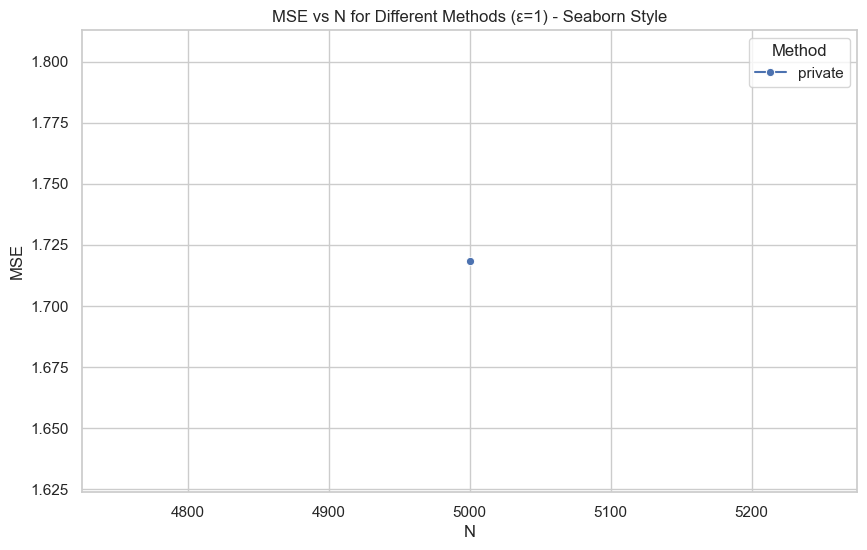

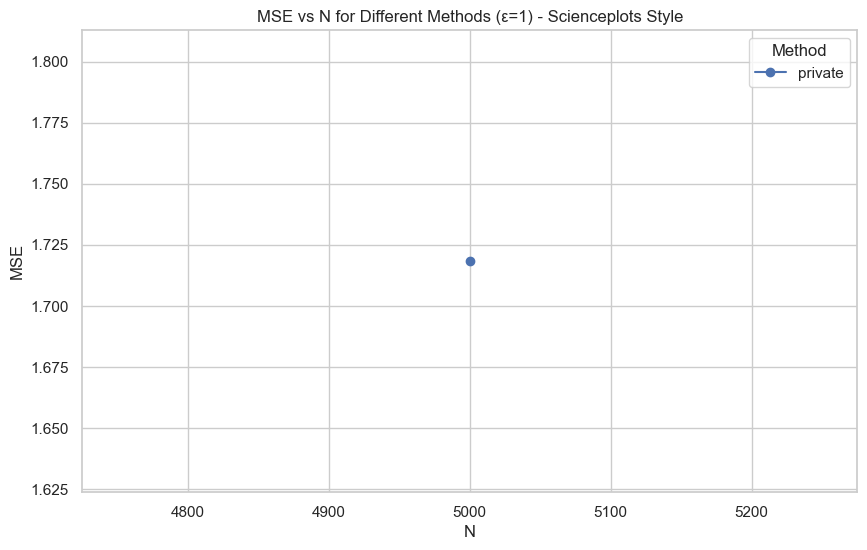

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots  # 用于科学绘图样式
import matplotlib
matplotlib.rcParams['text.usetex'] = False

# 读取结果数据
results_df = pd.read_csv("./result.csv")

# 设置 seaborn 样式
sns.set(style="whitegrid")

# 设置 scienceplots 样式
#plt.style.use(['science', 'ieee'])
# 绘制 seaborn 样式的折线图（分 epsilon 绘制）
def plot_seaborn_style(results_df):
    epsilons = results_df['epsilon'].unique()
    for epsilon in epsilons:
        plt.figure(figsize=(10, 6))
        subset = results_df[results_df['epsilon'] == epsilon]
        sns.lineplot(data=subset, x='N', y='mse', hue='method', style='method', markers=True, dashes=False)
        plt.title(f'MSE vs N for Different Methods (ε={epsilon}) - Seaborn Style')
        plt.xlabel('N')
        plt.ylabel('MSE')
        plt.legend(title='Method')
        plt.show()

# 绘制 scienceplots 样式的折线图（分 epsilon 绘制）
def plot_scienceplots_style(results_df):
    epsilons = results_df['epsilon'].unique()
    for epsilon in epsilons:
        plt.figure(figsize=(10, 6))
        subset = results_df[results_df['epsilon'] == epsilon]
        for method in subset['method'].unique():
            method_subset = subset[subset['method'] == method]
            plt.plot(method_subset['N'], method_subset['mse'], label=method, marker='o')
        plt.title(f'MSE vs N for Different Methods (ε={epsilon}) - Scienceplots Style')
        plt.xlabel('N')
        plt.ylabel('MSE')
        plt.legend(title='Method')
        plt.show()
# 绘制不同样式的折线图
plot_seaborn_style(results_df)
plot_scienceplots_style(results_df)

In [6]:
results_df

,N,epsilon,method,beta,lambda,sigma_sq,mse,loss,hyperparams
0,5000,1,private,[0.6122003 1.9171834 2.9333975],0.678089,1.463007,1.718284,1.270226,"{'constraint': 78.82690210337317, 'minibatch_s..."


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import optuna
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import halfnorm
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import statsmodels.api as sm
import pandas as pd
import math
import os
from tqdm import tqdm  # 添加进度条支持
from sklearn.model_selection import train_test_split, KFold
# Stochastic Frontier Model类
class StochasticFrontierModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor(num_features * [1.0], dtype=torch.float32))
        self.log_sigma2 = nn.Parameter(torch.tensor(0.0))
        self.log_lambda0 = nn.Parameter(torch.tensor(0.0))

    def predict(self, x):
        # 使用 torch.matmul 执行矩阵乘法
        predictions = torch.matmul(x, self.beta)
        return predictions

    def forward(self, x, y):
        sigma2 = torch.exp(self.log_sigma2)
        lambda0 = torch.exp(self.log_lambda0)
        sigma = torch.sqrt(sigma2)
        epsilon = y - torch.sum(x * self.beta, dim=1)

        term1 = x.shape[0] * self.log_sigma2 / 2
        term2 = -torch.sum(torch.log(torch.distributions.normal.Normal(0, 1).cdf(-epsilon * lambda0 / sigma) + 1e-10))
        term3 = torch.sum(epsilon**2) / (2 * sigma2)

        return (term1 + term2 + term3) / x.shape[0]

class StochasticFrontierAnalysis:
    def __init__(self, num_features, beta, sigma_u, sigma_v):
        self.num_features = num_features
        self.beta = beta
        self.sigma_u = sigma_u
        self.sigma_v = sigma_v

    def standardize_data(self, x):
        mean = np.mean(x[:, 1:], axis=0)
        std = np.std(x[:, 1:], axis=0)
        x_standardized = np.column_stack([x[:, 0], (x[:, 1:] - mean) / std])
        return x_standardized, np.insert(mean, 0, 0), np.insert(std, 0, 1)

    def generate_data(self, N):
        x1 = np.random.uniform(0, 1, N)
        x_random = np.random.normal(0, 1, (N, self.num_features - 1))
        x = np.hstack([x1.reshape(-1, 1), x_random])
        v = np.random.normal(0, self.sigma_v, N)
        u = stats.halfnorm.rvs(loc=0, scale=self.sigma_u, size=N)
        y = x.dot(self.beta) + v - u
        return x, y

    def stochastic_frontier_mle(self, x, y):
        # 将 x 和 y 转换为 pandas.DataFrame 和 pandas.Series
        x_df = pd.DataFrame(x)
        y_series = pd.Series(y)

        def logLikFun(param):
            const = param[0]
            parlab = param[:-2]
            parsigmaSq = param[-2]
            parlambda = param[-1]
            epsilon = y_series - 0 - np.dot(x_df, parlab)
            return -np.sum(0.5 * np.log(parsigmaSq) + 0.5 / parsigmaSq * epsilon**2 -
                           norm.logcdf(-epsilon * parlambda / np.sqrt(parsigmaSq)))

        # 使用最小二乘法获取初始参数
        ols = sm.OLS(y_series, x_df).fit()
        init_params = np.append(ols.params.values, [0.5, sum(ols.resid**2) / (len(y_series) - len(ols.params))])

        # 极大似然估计
        result = minimize(lambda params: -logLikFun(params), init_params, method='Nelder-Mead')

        # 提取估计的参数
        beta = result.x[:-2]  # 提取 beta 参数
        sigma_sq = result.x[-2]  # 提取 sigma^2
        lambda_ = result.x[-1]  # 提取 lambda

        # 计算 MSE
        epsilon = y_series - np.dot(x_df, beta)
        mse = np.mean(epsilon**2)

        return beta, lambda_, sigma_sq, mse, -logLikFun(result.x)

    def train_model_without_private(self, x, y, num_iters=3000, constraint=100, minibatch_size=50):
        x, mean, std = self.standardize_data(x)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        model = StochasticFrontierModel(num_features=self.num_features)
        losses = []
        gradients = []
        parameters = []

        for i in tqdm(range(1, num_iters + 1), desc="Training without privacy"):
            minibatch_indices = np.random.choice(x.shape[0], minibatch_size, replace=True)
            minibatch_x = x[minibatch_indices]
            minibatch_y = y[minibatch_indices]
            loss = model(minibatch_x, minibatch_y)
            loss.backward()
            gradient = torch.cat([p.grad.flatten() for p in model.parameters()]).detach().numpy()
            pos_alphas = self.compute_alpha(constraint, gradient, model)
            neg_alphas = self.compute_alpha(-constraint, gradient, model)
            alphas = pos_alphas + neg_alphas
            min_alpha, size, corner_num = min(alphas, key=lambda x: x[0])
            corner = np.zeros(sum(p.numel() for p in model.parameters()))
            corner[corner_num] = size
            mu = 2 / (i + 2)
            with torch.no_grad():
                index = 0
                for p in model.parameters():
                    numel = p.numel()
                    p_flat = p.view(-1)
                    p_flat.copy_((1 - mu) * p_flat + mu * torch.tensor(corner[index:index+numel], dtype=torch.float32))
                    index += numel
            losses.append(loss.item())
            gradients.append(np.linalg.norm(gradient))  # 记录梯度的范数
            parameters.append(model.state_dict().copy())
            model.zero_grad()

        min_loss_index = np.argmin(losses)
        model.load_state_dict(parameters[min_loss_index])

        # 可视化损失和梯度，忽略前 50 次迭代
        #self.plot_training_process(losses, gradients, "Training without Privacy", ignore_first_n=100)
        return model, mean, std, losses[-1], self.calculate_mse(model, x, y)

    def train_model_private(self, x, y, num_iters=3000, constraint=100, minibatch_size=50, lipschitz=1, epsilon=0.1, delta=1e-5):
        x, mean, std = self.standardize_data(x)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        model = StochasticFrontierModel(num_features=self.num_features)
        n = x.shape[0]
        m = sum(p.numel() for p in model.parameters())
        losses = []
        gradients = []
        parameters = []
        noise_para = lipschitz * constraint * math.sqrt(8 * num_iters * math.log(1 / delta)) / (n * epsilon)

        for i in tqdm(range(1, num_iters + 1), desc="Training with privacy"):
            minibatch_indices = np.random.choice(x.shape[0], minibatch_size, replace=True)
            minibatch_x = x[minibatch_indices]
            minibatch_y = y[minibatch_indices]
            loss = model(minibatch_x, minibatch_y)
            loss.backward()
            gradient = torch.cat([p.grad.flatten() for p in model.parameters()]).detach().numpy()
            pos_alphas = self.compute_alpha_private(constraint, gradient, model, noise_para)
            neg_alphas = self.compute_alpha_private(-constraint, gradient, model, noise_para)
            alphas = pos_alphas + neg_alphas
            min_alpha, size, corner_num = min(alphas, key=lambda x: x[0])
            corner = np.zeros(m)
            corner[corner_num] = size
            mu = 2 / (i + 2)
            with torch.no_grad():
                index = 0
                for p in model.parameters():
                    numel = p.numel()
                    p_flat = p.view(-1)
                    p_flat.copy_((1 - mu) * p_flat + mu * torch.tensor(corner[index:index+numel], dtype=torch.float32))
                    index += numel
            losses.append(loss.item())
            gradients.append(np.linalg.norm(gradient))  # 记录梯度的范数
            parameters.append(model.state_dict().copy())
            model.zero_grad()

        min_loss_index = np.argmin(losses)
        model.load_state_dict(parameters[min_loss_index])

        # 可视化损失和梯度，忽略前 50 次迭代
        #self.plot_training_process(losses, gradients, "Training with Privacy", ignore_first_n=100)
        return model, mean, std, losses[-1], self.calculate_mse(model, x, y)

    def compute_alpha(self, corner_size, gradient, model):
        alpha = gradient * corner_size
        corner_size = (np.ones(sum(p.numel() for p in model.parameters())) * corner_size).tolist()
        corner_num = np.arange(sum(p.numel() for p in model.parameters())).tolist()
        return list(zip(alpha, corner_size, corner_num))

    def compute_alpha_private(self, corner_size, gradient, model, noise_para):
        alpha = gradient * corner_size
        noise = np.random.laplace(scale=noise_para, size=sum(p.numel() for p in model.parameters()))
        alpha = alpha + noise
        corner_size = (np.ones(sum(p.numel() for p in model.parameters())) * corner_size).tolist()
        corner_num = np.arange(sum(p.numel() for p in model.parameters())).tolist()
        return list(zip(alpha, corner_size, corner_num))

    def calculate_mse(self, model, x, y):
        with torch.no_grad():
            predictions = model.predict(x)
            mse = torch.mean((predictions - y) ** 2).item()
        return mse

    def optimize_hyperparameters(self, x, y, method, num_trials=3):
        def objective(trial):
            # 公共超参数
            constraint = trial.suggest_float('constraint', 1, 100)
            minibatch_size = trial.suggest_int('minibatch_size', 10, 100)
            num_iters = trial.suggest_int('num_iters', 1000, 5000)

            if method == 'private':
                # 私有方法特有的超参数
                lipschitz = trial.suggest_float('lipschitz', 0.1, 1)
                model, _, _, loss, mse = self.train_model_private(
                    x, y, num_iters=num_iters, constraint=constraint, 
                    minibatch_size=minibatch_size, lipschitz=lipschitz
                )
            else:
                # 非私有方法不需要 lipschitz 参数
                model, _, _, loss, mse = self.train_model_without_private(
                    x, y, num_iters=num_iters, constraint=constraint, 
                    minibatch_size=minibatch_size
                )
            return loss

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=num_trials)
        return study.best_params

    def plot_training_process(self, losses, gradients, title, ignore_first_n=50):
        """
        绘制训练过程中的损失和梯度变化
        :param losses: 损失列表
        :param gradients: 梯度范数列表
        :param title: 图表标题
        :param ignore_first_n: 忽略前 n 次迭代的极端值
        """
        plt.figure(figsize=(12, 6))

        # 绘制损失曲线
        plt.subplot(1, 2, 1)
        plt.plot(range(ignore_first_n, len(losses)), losses[ignore_first_n:], label='Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title(f'{title} - Loss')
        plt.legend()

        # 如果损失范围较大，使用对数尺度
        if max(losses[ignore_first_n:]) / min(losses[ignore_first_n:]) > 100:
            plt.yscale('log')

        # 绘制梯度范数曲线
        plt.subplot(1, 2, 2)
        plt.plot(range(ignore_first_n, len(gradients)), gradients[ignore_first_n:], label='Gradient Norm', color='orange')
        plt.xlabel('Iteration')
        plt.ylabel('Gradient Norm')
        plt.title(f'{title} - Gradient Norm')
        plt.legend()

        # 如果梯度范数范围较大，使用对数尺度
        if max(gradients[ignore_first_n:]) / min(gradients[ignore_first_n:]) > 100:
            plt.yscale('log')

        plt.tight_layout()
        plt.show()
    

    def run_experiments(self, N_values, epsilon_values, num_repeats=100):
        
        results = []
        for N in N_values:
            x, y = self.generate_data(N)
            # 划分训练集和测试集
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
            pd.DataFrame(np.hstack([x, y.reshape(-1, 1)]), columns=[f'x{i}' for i in range(self.num_features)] + ['y']).to_csv(f'data_{N}.csv', index=False)
            for epsilon in epsilon_values:
                for method in ['mle', 'without_private', 'private']:
                    if method == 'mle':
                        # MLE 方法不需要超参数优化
                        beta_list, lambda_list, sigma_sq_list, mse_list, loss_list = [], [], [], [], []
                        for _ in range(num_repeats):
                            beta, lambda_, sigma_sq, mse, loss = self.stochastic_frontier_mle(x_train, y_train)
                            beta_list.append(beta)
                            lambda_list.append(lambda_)
                            sigma_sq_list.append(sigma_sq)
                            # 在测试集上计算 MSE
                            y_pred = x_test.dot(beta)
                            test_mse = np.mean((y_test - y_pred) ** 2)
                            mse_list.append(test_mse)
                            loss_list.append(loss)
                        # 计算平均值
                        avg_beta = np.mean(beta_list, axis=0)
                        avg_lambda = np.mean(lambda_list)
                        avg_sigma_sq = np.mean(sigma_sq_list)
                        avg_mse = np.mean(mse_list)
                        avg_loss = np.mean(loss_list)
                        hyperparams = {}
                    else:
                        # 使用交叉验证优化超参数
                        hyperparams = self.optimize_hyperparameters(x_train, y_train, method)
                        beta_list, lambda_list, sigma_sq_list, mse_list, loss_list = [], [], [], [], []
                        for _ in range(num_repeats):
                            if method == 'private':
                                model, _, _, loss, mse = self.train_model_private(x_train, y_train, **hyperparams, epsilon=epsilon)
                            else:
                                model, _, _, loss, mse = self.train_model_without_private(x_train, y_train, **hyperparams)
                            beta_list.append(model.beta.detach().numpy())
                            lambda_list.append(torch.exp(model.log_lambda0).item())
                            sigma_sq_list.append(torch.exp(model.log_sigma2).item())
                            # 在测试集上计算 MSE
                            with torch.no_grad():
                                y_pred = model.predict(torch.tensor(x_test, dtype=torch.float32)).numpy()
                                test_mse = np.mean((y_test - y_pred) ** 2)
                            mse_list.append(test_mse)
                            loss_list.append(loss)
                        # 计算平均值
                        avg_beta = np.mean(beta_list, axis=0)
                        avg_lambda = np.mean(lambda_list)
                        avg_sigma_sq = np.mean(sigma_sq_list)
                        avg_mse = np.mean(mse_list)
                        avg_loss = np.mean(loss_list)
        
                    # 保存结果
                    results.append({
                        'N': N,
                        'epsilon': epsilon,
                        'method': method,
                        'beta': avg_beta,
                        'lambda': avg_lambda,
                        'sigma_sq': avg_sigma_sq,
                        'mse': avg_mse,
                        'loss': avg_loss,
                        'hyperparams': hyperparams
                    })
        # 保存结果到 CSV
        pd.DataFrame(results).to_csv('result.csv', index=False)
# Example usage
num_features = 3
beta = np.array([1.0, 2.0, 3.0])
sigma_u = 0.3
sigma_v = 0.5
sfa = StochasticFrontierAnalysis(num_features, beta, sigma_u, sigma_v)
sfa.run_experiments(N_values=[ 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000], epsilon_values=[0.1, 0.5,1])
[I 2025-01-02 02:49:54,719] A new study created in memory with name: no-name-5b1084ea-908b-45a6-90d1-ecc42cdd0e3e
Training without privacy: 100%|██████████| 1977/1977 [00:03<00:00, 655.80it/s]
[I 2025-01-02 02:49:57,789] Trial 0 finished with value: 0.6343860626220703 and parameters: {'constraint': 91.18945437559138, 'minibatch_size': 64, 'num_iters': 1977}. Best is trial 0 with value: 0.6343860626220703.
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 750.82it/s]
[I 2025-01-02 02:49:59,576] Trial 1 finished with value: 0.5337329506874084 and parameters: {'constraint': 50.82245081982152, 'minibatch_size': 43, 'num_iters': 1333}. Best is trial 1 with value: 0.5337329506874084.
Training without privacy: 100%|██████████| 2915/2915 [00:03<00:00, 736.94it/s]
[I 2025-01-02 02:50:03,545] Trial 2 finished with value: 0.6002915501594543 and parameters: {'constraint': 57.79329172818423, 'minibatch_size': 34, 'num_iters': 2915}. Best is trial 1 with value: 0.5337329506874084.
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 722.90it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 711.29it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 740.59it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 716.06it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 753.29it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 752.11it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 710.42it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 756.69it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 751.60it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 749.61it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 696.92it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 715.23it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 683.22it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 687.71it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 711.41it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 705.70it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 689.25it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:02<00:00, 628.42it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 682.54it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 673.85it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 697.25it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 704.79it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 675.48it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 687.03it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 702.48it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 723.39it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 720.45it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 687.48it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 708.30it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 704.22it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 702.53it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:02<00:00, 651.26it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 677.23it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 687.54it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 705.69it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 714.74it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 683.06it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 723.08it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 699.99it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 683.77it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 717.15it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 729.91it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 710.76it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 694.85it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 718.10it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 722.88it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 708.30it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 707.89it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 685.74it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 713.26it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 731.35it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 697.09it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 703.84it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 718.52it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 713.02it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 748.38it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 734.46it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 733.60it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 754.02it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 730.75it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 755.90it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 747.29it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 718.21it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 751.29it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 745.28it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 732.19it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 721.44it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 726.97it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 748.09it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 740.40it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 689.97it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 746.91it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 751.19it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 701.38it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 735.13it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 740.55it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 736.35it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 751.81it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 754.50it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 741.36it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 733.82it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 707.89it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 738.92it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 699.33it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 757.49it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 750.83it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 727.15it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 713.79it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 748.99it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 741.86it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 721.84it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 718.17it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 726.54it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 732.80it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 731.76it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 754.03it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 753.96it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 751.04it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 748.64it/s]
Training without privacy: 100%|██████████| 1333/1333 [00:01<00:00, 748.42it/s]
[I 2025-01-02 02:53:09,881] A new study created in memory with name: no-name-034e1c35-f47b-47da-947a-014d58de74dc
Training with privacy: 100%|██████████| 4070/4070 [00:05<00:00, 753.29it/s]
[I 2025-01-02 02:53:15,299] Trial 0 finished with value: 2.6859400272369385 and parameters: {'constraint': 62.26046260809258, 'minibatch_size': 30, 'num_iters': 4070, 'lipschitz': 0.9936455495359835}. Best is trial 0 with value: 2.6859400272369385.
Training with privacy: 100%|██████████| 4243/4243 [00:06<00:00, 666.51it/s]
[I 2025-01-02 02:53:21,682] Trial 1 finished with value: 1.9220478534698486 and parameters: {'constraint': 70.79307755945075, 'minibatch_size': 86, 'num_iters': 4243, 'lipschitz': 0.23460215350571756}. Best is trial 1 with value: 1.9220478534698486.
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 680.81it/s]
[I 2025-01-02 02:53:25,689] Trial 2 finished with value: 1.2583162784576416 and parameters: {'constraint': 94.95099412971366, 'minibatch_size': 84, 'num_iters': 2719, 'lipschitz': 0.5696001540528519}. Best is trial 2 with value: 1.2583162784576416.
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 679.61it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 687.49it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 654.69it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 680.45it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 684.45it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 664.06it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 666.39it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 656.86it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 672.40it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 676.29it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 679.97it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 670.25it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 680.72it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 656.08it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 676.47it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 686.01it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 678.06it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 652.39it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 690.92it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 684.99it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 688.33it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 674.42it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 670.82it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 687.80it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 666.83it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 681.00it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 681.90it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 660.50it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 686.79it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 669.10it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 645.16it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 660.57it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 653.85it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 663.45it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 649.59it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 651.09it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 661.47it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 613.06it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 651.25it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 634.25it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 655.01it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 647.46it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 612.86it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 648.07it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 630.52it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 650.00it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 640.47it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 643.70it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 638.08it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 627.98it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 635.32it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 608.60it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 641.25it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 639.56it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 604.57it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 606.82it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 595.22it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 610.68it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 631.28it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 644.14it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 639.56it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 628.27it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 628.96it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 640.25it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 619.05it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 639.48it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 626.02it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 635.01it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 676.69it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 674.43it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 687.64it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 694.16it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 652.91it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 673.37it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 673.86it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 685.22it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 676.67it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 685.52it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 691.17it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 655.32it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 689.80it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 671.91it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 664.85it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 675.68it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 671.21it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 684.73it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 677.26it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 684.05it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 682.45it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 656.40it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 679.10it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 613.66it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 636.84it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 671.75it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 666.10it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 655.73it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 664.43it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 650.29it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:03<00:00, 679.97it/s]
Training with privacy: 100%|██████████| 2719/2719 [00:04<00:00, 632.44it/s]
[I 2025-01-02 03:00:50,591] A new study created in memory with name: no-name-d2e135ec-fafb-4dab-9118-38ceb5da7a46
Training without privacy: 100%|██████████| 4713/4713 [00:08<00:00, 581.35it/s]
[I 2025-01-02 03:00:58,716] Trial 0 finished with value: 0.509181797504425 and parameters: {'constraint': 92.46546730264248, 'minibatch_size': 79, 'num_iters': 4713}. Best is trial 0 with value: 0.509181797504425.
Training without privacy: 100%|██████████| 1091/1091 [00:01<00:00, 641.25it/s]
[I 2025-01-02 03:01:00,430] Trial 1 finished with value: 1.2095487117767334 and parameters: {'constraint': 60.67366419752636, 'minibatch_size': 29, 'num_iters': 1091}. Best is trial 0 with value: 0.509181797504425.
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 562.31it/s]
[I 2025-01-02 03:01:07,017] Trial 2 finished with value: 0.4583350718021393 and parameters: {'constraint': 69.36899683641543, 'minibatch_size': 89, 'num_iters': 3695}. Best is trial 2 with value: 0.4583350718021393.
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 563.61it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 561.71it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 568.19it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 573.27it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 579.71it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 574.73it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 585.00it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 579.68it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 563.05it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 582.10it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:07<00:00, 525.88it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 580.27it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 588.40it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 570.60it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 602.53it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 570.42it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 611.51it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 637.73it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 677.37it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 687.45it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 668.89it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 688.11it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 691.04it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 693.04it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 695.41it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 691.99it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 694.20it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 698.49it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 696.28it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 699.29it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 698.24it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 693.26it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 685.00it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 672.50it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 684.06it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 681.03it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 694.65it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 679.69it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 676.40it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 694.54it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 685.28it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 676.39it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 657.57it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 681.42it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 667.32it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 684.77it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 662.74it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 654.87it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 630.41it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 623.22it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 655.76it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 644.60it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 654.78it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 639.86it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 658.64it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 609.39it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 646.45it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 636.89it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 613.82it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 675.20it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:06<00:00, 615.42it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 628.02it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 653.36it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 671.08it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 686.21it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 672.73it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 652.84it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 669.86it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 672.36it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 678.03it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 688.32it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 685.36it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 677.81it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 696.11it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 694.43it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 705.33it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 684.43it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 693.03it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 698.08it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 696.09it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 668.35it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 673.21it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 695.88it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 673.26it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 668.57it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 679.72it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 686.26it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 687.66it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 689.20it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 672.22it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 694.78it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 691.51it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 672.51it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 688.81it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 674.87it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 664.53it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 700.15it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 679.26it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 682.18it/s]
Training without privacy: 100%|██████████| 3695/3695 [00:05<00:00, 687.59it/s]
[I 2025-01-02 03:10:32,753] A new study created in memory with name: no-name-96f8286d-8699-4701-a1b6-e2aae889f82c
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 652.44it/s]
[I 2025-01-02 03:10:39,071] Trial 0 finished with value: 1.934360384941101 and parameters: {'constraint': 77.08148705086819, 'minibatch_size': 96, 'num_iters': 4111, 'lipschitz': 0.7404750451149014}. Best is trial 0 with value: 1.934360384941101.
Training with privacy: 100%|██████████| 3015/3015 [00:03<00:00, 764.60it/s]
[I 2025-01-02 03:10:43,028] Trial 1 finished with value: 2.1387362480163574 and parameters: {'constraint': 61.69186441435585, 'minibatch_size': 10, 'num_iters': 3015, 'lipschitz': 0.8634822268259699}. Best is trial 0 with value: 1.934360384941101.
Training with privacy: 100%|██████████| 3740/3740 [00:05<00:00, 673.34it/s]
[I 2025-01-02 03:10:48,597] Trial 2 finished with value: 3.342233896255493 and parameters: {'constraint': 57.391135918765485, 'minibatch_size': 94, 'num_iters': 3740, 'lipschitz': 0.6360333218527154}. Best is trial 0 with value: 1.934360384941101.
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 627.83it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 619.65it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 612.41it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 608.30it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 591.09it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 620.18it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 613.08it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 615.59it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 625.77it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 587.32it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 608.89it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 593.58it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:07<00:00, 585.06it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 622.73it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 622.86it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 610.33it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 614.91it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 589.99it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 616.46it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 643.21it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 631.40it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 656.92it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 679.56it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 675.55it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:05<00:00, 686.12it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 668.79it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 666.00it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 679.97it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 682.91it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 672.59it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 675.95it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 671.44it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 662.07it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 674.40it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 673.88it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 681.27it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 671.04it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 658.43it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 654.01it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 654.55it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 665.05it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 655.06it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 640.83it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 644.66it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 656.67it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 652.42it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 658.74it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 594.34it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 622.96it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 614.74it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 611.16it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 625.15it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 610.57it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 608.27it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 624.74it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 629.15it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 619.54it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 631.65it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 624.59it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 596.40it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 637.86it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 639.42it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 663.70it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 674.13it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 665.61it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 661.59it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 641.15it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 661.12it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 662.07it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 685.09it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 672.74it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 675.49it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 678.63it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 674.92it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:05<00:00, 688.58it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:05<00:00, 694.89it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:05<00:00, 688.13it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 675.16it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 684.06it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 665.48it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 650.87it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 657.73it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 657.89it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 671.51it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 660.36it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 668.59it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 659.55it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 645.23it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 671.04it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 651.17it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 664.41it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 673.91it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 641.87it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 666.37it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 674.65it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 677.21it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 647.07it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 620.73it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:07<00:00, 569.55it/s]
Training with privacy: 100%|██████████| 4111/4111 [00:06<00:00, 613.47it/s]
[I 2025-01-02 03:21:55,217] A new study created in memory with name: no-name-86f349ea-922a-4411-9af6-a25a430fef57
Training without privacy: 100%|██████████| 2336/2336 [00:03<00:00, 646.63it/s]
[I 2025-01-02 03:21:58,844] Trial 0 finished with value: 0.5520415306091309 and parameters: {'constraint': 99.57824904455137, 'minibatch_size': 68, 'num_iters': 2336}. Best is trial 0 with value: 0.5520415306091309.
Training without privacy: 100%|██████████| 1367/1367 [00:02<00:00, 654.40it/s]
[I 2025-01-02 03:22:00,944] Trial 1 finished with value: 0.6589139103889465 and parameters: {'constraint': 54.3476880320799, 'minibatch_size': 76, 'num_iters': 1367}. Best is trial 0 with value: 0.5520415306091309.
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 691.86it/s]
[I 2025-01-02 03:22:05,454] Trial 2 finished with value: 0.40985235571861267 and parameters: {'constraint': 92.88859768676537, 'minibatch_size': 43, 'num_iters': 3109}. Best is trial 2 with value: 0.40985235571861267.
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 706.56it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 695.32it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 697.48it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 707.90it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 671.06it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 719.72it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 729.99it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 723.64it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 718.95it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 735.04it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 717.39it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 722.16it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 726.80it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 717.63it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 697.64it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 697.14it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 724.22it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 743.42it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 748.76it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 747.38it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 759.63it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 753.83it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 770.85it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 696.70it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 736.90it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 747.13it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 733.29it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 745.85it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 741.29it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 748.43it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 749.96it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 751.75it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 730.42it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 745.41it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 744.38it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 750.01it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 753.80it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 752.17it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 742.83it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 742.31it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 740.73it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 767.09it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 749.27it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 752.33it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 758.60it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 713.08it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 752.15it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 753.30it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 759.31it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 747.77it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 755.32it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 755.35it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 748.24it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 736.41it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 753.16it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 765.79it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 736.02it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 719.55it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 717.76it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 713.98it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 712.18it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 683.83it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 720.03it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 718.63it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 725.71it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 727.30it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 715.42it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 707.88it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 700.83it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 722.89it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 715.62it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 691.88it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 731.13it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 726.23it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 726.23it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 692.40it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 718.14it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 698.67it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 720.59it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 722.36it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 737.93it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 742.87it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 715.00it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 725.78it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 724.96it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 715.65it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 693.56it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 724.11it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 723.24it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 683.59it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 713.08it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 728.27it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 749.57it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 752.62it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 754.34it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 725.72it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 742.71it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 729.85it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 754.87it/s]
Training without privacy: 100%|██████████| 3109/3109 [00:04<00:00, 761.34it/s]
[I 2025-01-02 03:29:12,899] A new study created in memory with name: no-name-73a5bfbd-52ec-4959-bfc9-6c04d5db2e11
Training with privacy: 100%|██████████| 1530/1530 [00:02<00:00, 678.76it/s]
[I 2025-01-02 03:29:15,165] Trial 0 finished with value: 1.8538804054260254 and parameters: {'constraint': 30.000901228745214, 'minibatch_size': 74, 'num_iters': 1530, 'lipschitz': 0.2229841658902376}. Best is trial 0 with value: 1.8538804054260254.
Training with privacy: 100%|██████████| 4615/4615 [00:06<00:00, 730.17it/s]
[I 2025-01-02 03:29:21,503] Trial 1 finished with value: 6.772912502288818 and parameters: {'constraint': 13.231515089352948, 'minibatch_size': 15, 'num_iters': 4615, 'lipschitz': 0.7221041929460023}. Best is trial 0 with value: 1.8538804054260254.
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 683.61it/s]
[I 2025-01-02 03:29:27,853] Trial 2 finished with value: 1.0955407619476318 and parameters: {'constraint': 79.81965678294095, 'minibatch_size': 88, 'num_iters': 4330, 'lipschitz': 0.47309336717582373}. Best is trial 2 with value: 1.0955407619476318.
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 670.35it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 644.75it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 657.62it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 682.67it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 671.88it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 665.02it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 676.22it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 667.04it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 662.83it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 675.74it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 666.14it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 678.40it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 670.56it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 673.55it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 675.83it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 657.26it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 664.83it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 661.19it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 657.87it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 649.36it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 647.15it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 632.75it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 654.34it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 664.50it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 637.11it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 646.13it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 657.86it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 644.43it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 654.22it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 651.35it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 655.53it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 654.65it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 638.92it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 655.56it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 638.84it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 635.44it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 641.13it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 644.53it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 667.80it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 665.53it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 676.08it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 673.59it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 678.96it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 667.50it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 686.55it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 680.15it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 686.35it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 687.02it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 659.94it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 676.69it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 670.64it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 682.57it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 683.21it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 673.89it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 654.73it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 680.17it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 670.98it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 666.55it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 654.91it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 665.27it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 645.76it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 664.87it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 649.39it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 648.96it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 646.21it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 635.03it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 646.64it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 637.96it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 635.58it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 650.41it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 645.13it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 647.93it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 653.37it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 657.96it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 654.36it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 662.91it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 635.45it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 629.15it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 652.04it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 659.44it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 635.22it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 654.87it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 638.77it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 649.33it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 640.35it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 664.12it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 666.31it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 681.25it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 692.19it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 669.04it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 679.19it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 676.56it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 685.89it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 676.48it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 678.67it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 683.68it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 662.44it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 667.06it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 684.50it/s]
Training with privacy: 100%|██████████| 4330/4330 [00:06<00:00, 678.32it/s]
[I 2025-01-02 03:40:57,707] A new study created in memory with name: no-name-5395a935-c043-499b-adfe-f20b63cb7bc5
Training without privacy: 100%|██████████| 3718/3718 [00:05<00:00, 723.82it/s]
[I 2025-01-02 03:41:02,860] Trial 0 finished with value: 0.6535673141479492 and parameters: {'constraint': 25.8739238353123, 'minibatch_size': 59, 'num_iters': 3718}. Best is trial 0 with value: 0.6535673141479492.
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 750.99it/s]
[I 2025-01-02 03:41:07,612] Trial 1 finished with value: 0.6049212217330933 and parameters: {'constraint': 97.27369980829518, 'minibatch_size': 16, 'num_iters': 3557}. Best is trial 1 with value: 0.6049212217330933.
Training without privacy: 100%|██████████| 3700/3700 [00:04<00:00, 749.69it/s]
[I 2025-01-02 03:41:12,564] Trial 2 finished with value: 0.7355589866638184 and parameters: {'constraint': 95.91681148920284, 'minibatch_size': 37, 'num_iters': 3700}. Best is trial 1 with value: 0.6049212217330933.
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 775.97it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 702.37it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 776.68it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 753.84it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 748.03it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 758.67it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 769.71it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 745.75it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 743.51it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 734.32it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 715.96it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 707.66it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 713.94it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 744.44it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 739.82it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 709.66it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 742.16it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 730.22it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 734.19it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 709.84it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 742.73it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 735.89it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 742.64it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 748.22it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 740.41it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 739.55it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 749.68it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 749.28it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 713.43it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 731.48it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 734.76it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 719.27it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 731.02it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 737.81it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 742.68it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 746.79it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 733.68it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 722.30it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 741.74it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 745.12it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 747.00it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 761.54it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 773.79it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 784.70it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 741.43it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 763.13it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 759.66it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 765.66it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 760.16it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 778.69it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 755.52it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 733.80it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 757.27it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 768.40it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 772.79it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 734.47it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 764.33it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 732.50it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 762.24it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 754.47it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 768.72it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 761.48it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 770.02it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 758.09it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 714.09it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 747.74it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 743.82it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 755.28it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 769.70it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 776.36it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 764.72it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 752.34it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 768.22it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 726.24it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 741.31it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 730.51it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 703.00it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 698.52it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 700.07it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 722.28it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 711.60it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 716.06it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 695.10it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 705.21it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 718.09it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 738.59it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 740.72it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 749.06it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 735.86it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 731.60it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 709.65it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 721.20it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 731.52it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 737.27it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 722.73it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 745.33it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:05<00:00, 650.94it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 736.81it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 718.94it/s]
Training without privacy: 100%|██████████| 3557/3557 [00:04<00:00, 726.70it/s]
[I 2025-01-02 03:49:15,157] A new study created in memory with name: no-name-d9c22541-c396-4220-8c3b-c11b258a48c3
Training with privacy: 100%|██████████| 3616/3616 [00:05<00:00, 683.15it/s]
[I 2025-01-02 03:49:20,467] Trial 0 finished with value: 1.8952410221099854 and parameters: {'constraint': 36.44556496963231, 'minibatch_size': 59, 'num_iters': 3616, 'lipschitz': 0.6177755307820553}. Best is trial 0 with value: 1.8952410221099854.
Training with privacy: 100%|██████████| 3083/3083 [00:04<00:00, 725.58it/s]
[I 2025-01-02 03:49:24,730] Trial 1 finished with value: 2.7408595085144043 and parameters: {'constraint': 5.390584801143367, 'minibatch_size': 40, 'num_iters': 3083, 'lipschitz': 0.22679738380258246}. Best is trial 0 with value: 1.8952410221099854.
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 674.78it/s]
[I 2025-01-02 03:49:28,395] Trial 2 finished with value: 1.4957977533340454 and parameters: {'constraint': 44.03383529832446, 'minibatch_size': 76, 'num_iters': 2465, 'lipschitz': 0.69066712664553}. Best is trial 2 with value: 1.4957977533340454.
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 664.30it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 686.48it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 687.73it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 693.49it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 676.88it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 685.11it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 693.38it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 690.62it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 690.40it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 658.07it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 679.23it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 693.12it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 698.87it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 647.62it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 690.68it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 695.08it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 677.07it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 686.64it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 626.61it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 685.38it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 685.30it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 684.43it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 692.22it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 671.89it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 683.09it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 692.00it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 691.02it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 637.00it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 680.48it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 680.55it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 690.24it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 690.54it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 680.25it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 672.72it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 694.16it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 663.21it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 670.68it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 678.97it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 659.09it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 673.15it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 664.32it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 664.83it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 651.09it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 678.60it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 656.20it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 681.59it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 672.15it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 690.56it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 670.49it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 667.12it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 673.84it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 655.24it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 640.57it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 658.05it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 642.09it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 666.35it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 654.65it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:04<00:00, 600.42it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 656.96it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 642.91it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 655.64it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 648.36it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 635.06it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 632.21it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 643.02it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 659.02it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 657.23it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 663.46it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 660.18it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 639.06it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 665.30it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 653.02it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 659.57it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 670.69it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 677.25it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 663.34it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 667.04it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 664.12it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 654.68it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 654.48it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 673.14it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 676.29it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 661.82it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 660.67it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 681.37it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 673.39it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 649.83it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 663.86it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 678.75it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 696.78it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 679.81it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 683.34it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 692.07it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 691.69it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 670.09it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 679.55it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 684.17it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 655.96it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 693.02it/s]
Training with privacy: 100%|██████████| 2465/2465 [00:03<00:00, 679.54it/s]
[I 2025-01-02 03:56:10,648] A new study created in memory with name: no-name-8183169f-2226-424f-a486-471d9d430dd9
Training without privacy: 100%|██████████| 4218/4218 [00:05<00:00, 764.40it/s]
[I 2025-01-02 03:56:16,184] Trial 0 finished with value: 0.9441458582878113 and parameters: {'constraint': 77.48606875563922, 'minibatch_size': 14, 'num_iters': 4218}. Best is trial 0 with value: 0.9441458582878113.
Training without privacy: 100%|██████████| 1048/1048 [00:01<00:00, 631.58it/s]
[I 2025-01-02 03:56:17,854] Trial 1 finished with value: 0.7464253902435303 and parameters: {'constraint': 47.579112643920126, 'minibatch_size': 73, 'num_iters': 1048}. Best is trial 1 with value: 0.7464253902435303.
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 764.81it/s]
[I 2025-01-02 03:56:22,317] Trial 2 finished with value: 0.4101155400276184 and parameters: {'constraint': 71.463618522206, 'minibatch_size': 26, 'num_iters': 3402}. Best is trial 2 with value: 0.4101155400276184.
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 776.15it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 752.21it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 758.05it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 769.24it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 718.42it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 746.42it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 735.39it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 761.56it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 774.91it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 739.37it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 775.53it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 774.77it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 759.03it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 750.11it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 731.40it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 716.73it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 752.94it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 765.39it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 758.23it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 763.58it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 755.31it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 759.27it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 743.43it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 734.96it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 748.46it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 716.05it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 723.92it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 726.97it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 732.14it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 733.24it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 746.94it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 713.99it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 732.21it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 696.40it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 722.61it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 729.14it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 722.90it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 739.69it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 735.47it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 733.51it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 719.74it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 757.72it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 762.16it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 738.30it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 754.84it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 767.46it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 746.76it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 737.45it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 758.53it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 743.86it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 757.89it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 731.86it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 764.66it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 750.57it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 734.05it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 758.89it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 764.80it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 766.71it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 780.43it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 782.51it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 768.98it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 717.78it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 761.68it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 745.83it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 742.00it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 758.09it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 721.98it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 734.61it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 694.13it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 711.53it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 704.14it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 742.82it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 746.77it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 732.56it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 730.38it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:05<00:00, 659.03it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 724.62it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 728.26it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 720.31it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 742.04it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 745.55it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 733.05it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 724.87it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 736.82it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 749.88it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 726.54it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 729.51it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 707.89it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 758.23it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 736.48it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 739.86it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 760.73it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 750.71it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 766.08it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 756.52it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 769.13it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 719.23it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 736.47it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 767.27it/s]
Training without privacy: 100%|██████████| 3402/3402 [00:04<00:00, 766.66it/s]
[I 2025-01-02 04:04:02,110] A new study created in memory with name: no-name-9438430e-3c66-48e9-ab65-6ceb6085c658
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 673.62it/s]
[I 2025-01-02 04:04:03,818] Trial 0 finished with value: 1.1106308698654175 and parameters: {'constraint': 90.82490703819343, 'minibatch_size': 99, 'num_iters': 1144, 'lipschitz': 0.5229436907367423}. Best is trial 0 with value: 1.1106308698654175.
Training with privacy: 100%|██████████| 2109/2109 [00:02<00:00, 707.31it/s]
[I 2025-01-02 04:04:06,812] Trial 1 finished with value: 1.1113613843917847 and parameters: {'constraint': 82.6952726876563, 'minibatch_size': 60, 'num_iters': 2109, 'lipschitz': 0.3891485498109708}. Best is trial 0 with value: 1.1106308698654175.
Training with privacy: 100%|██████████| 3180/3180 [00:04<00:00, 658.47it/s]
[I 2025-01-02 04:04:11,657] Trial 2 finished with value: 2.2221903800964355 and parameters: {'constraint': 48.18882585260605, 'minibatch_size': 69, 'num_iters': 3180, 'lipschitz': 0.6093667273780663}. Best is trial 0 with value: 1.1106308698654175.
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 666.32it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 686.88it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 655.40it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 666.08it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 694.98it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 692.97it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 676.21it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 688.07it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 686.04it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 677.59it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 657.99it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 677.71it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 683.60it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 691.24it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 689.55it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 640.43it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 677.83it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 632.89it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 689.55it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 691.20it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 658.43it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 673.88it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 693.89it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 688.21it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 687.02it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 691.12it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 679.14it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 694.41it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 684.66it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 693.38it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 696.03it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 696.43it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 658.55it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 688.40it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 640.12it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 694.40it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 689.11it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 683.74it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 673.00it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 646.82it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 669.36it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 652.19it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 694.27it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 687.83it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 661.18it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 689.33it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 697.54it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 681.26it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 694.87it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 678.74it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 663.16it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 699.15it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 687.38it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 666.55it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 698.83it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 695.41it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 680.10it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 633.85it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 671.85it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 694.24it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 691.86it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 675.92it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 663.74it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 641.92it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 666.20it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 678.48it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 693.04it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 678.36it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 673.62it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 688.70it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 682.69it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 678.85it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 687.57it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 646.91it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 676.76it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 688.87it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 663.79it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 678.76it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 671.98it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 662.16it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 685.96it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 690.27it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 689.77it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 668.56it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 686.35it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 657.77it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 655.36it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 693.65it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 692.33it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 689.95it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 690.05it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 678.17it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 668.42it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 682.69it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 686.86it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 642.95it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 677.45it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 615.60it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 659.47it/s]
Training with privacy: 100%|██████████| 1144/1144 [00:01<00:00, 682.25it/s]
[I 2025-01-02 04:07:34,706] A new study created in memory with name: no-name-89918e1b-e2e2-4d87-98af-c2beb610ff53
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 681.05it/s]
[I 2025-01-02 04:07:39,794] Trial 0 finished with value: 0.6437444686889648 and parameters: {'constraint': 21.770120340997426, 'minibatch_size': 97, 'num_iters': 3455}. Best is trial 0 with value: 0.6437444686889648.
Training without privacy: 100%|██████████| 1157/1157 [00:01<00:00, 763.31it/s]
[I 2025-01-02 04:07:41,320] Trial 1 finished with value: 0.6652565598487854 and parameters: {'constraint': 61.19043442246571, 'minibatch_size': 37, 'num_iters': 1157}. Best is trial 0 with value: 0.6437444686889648.
Training without privacy: 100%|██████████| 4847/4847 [00:06<00:00, 732.43it/s]
[I 2025-01-02 04:07:47,956] Trial 2 finished with value: 0.6964355707168579 and parameters: {'constraint': 71.29002567724915, 'minibatch_size': 55, 'num_iters': 4847}. Best is trial 0 with value: 0.6437444686889648.
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 687.43it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 674.68it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 695.30it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 692.78it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 661.90it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 689.15it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 690.94it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 675.95it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 699.30it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 677.41it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 688.82it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 684.42it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 662.04it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 677.51it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 662.63it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 696.20it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 701.87it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 687.81it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 681.34it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 676.45it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 688.58it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 699.54it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 688.02it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 670.82it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 702.49it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 697.32it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 675.25it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 690.12it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 704.65it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 682.10it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 671.14it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 679.08it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 690.82it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 696.71it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 704.33it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 699.89it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 679.28it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 693.01it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 694.05it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 686.08it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 679.76it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 705.24it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 689.11it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 690.11it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 693.79it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 675.32it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 686.12it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 692.45it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 700.52it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 689.53it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 683.56it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 691.52it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 711.85it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 694.97it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 709.14it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 706.76it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 691.56it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 699.45it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 697.52it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 681.16it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 677.26it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 662.10it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 652.08it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 650.09it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 657.32it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 650.77it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 663.82it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 668.00it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 644.44it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 654.23it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 636.16it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 671.64it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 648.80it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 660.64it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 647.75it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 636.64it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 642.65it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 679.08it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 683.22it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 682.69it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 677.49it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 673.31it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 653.80it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 677.46it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 643.10it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 672.96it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 642.53it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 668.24it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 605.73it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 645.21it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 659.19it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 684.45it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 689.01it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 663.32it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 638.93it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 670.31it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 677.09it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 693.57it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:05<00:00, 689.16it/s]
Training without privacy: 100%|██████████| 3455/3455 [00:04<00:00, 697.23it/s]
[I 2025-01-02 04:16:19,036] A new study created in memory with name: no-name-9cf8bd91-86bd-45e4-9574-60c2f16a3f84
Training with privacy: 100%|██████████| 3632/3632 [00:05<00:00, 705.13it/s]
[I 2025-01-02 04:16:24,201] Trial 0 finished with value: 1.911333441734314 and parameters: {'constraint': 57.57774736147707, 'minibatch_size': 41, 'num_iters': 3632, 'lipschitz': 0.9956839976922832}. Best is trial 0 with value: 1.911333441734314.
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 757.96it/s]
[I 2025-01-02 04:16:30,235] Trial 1 finished with value: 1.7630059719085693 and parameters: {'constraint': 48.28423172062437, 'minibatch_size': 21, 'num_iters': 4561, 'lipschitz': 0.5467116660912651}. Best is trial 1 with value: 1.7630059719085693.
Training with privacy: 100%|██████████| 2402/2402 [00:03<00:00, 688.70it/s]
[I 2025-01-02 04:16:33,734] Trial 2 finished with value: 2.141568183898926 and parameters: {'constraint': 32.144712308924156, 'minibatch_size': 77, 'num_iters': 2402, 'lipschitz': 0.530053995596563}. Best is trial 1 with value: 1.7630059719085693.
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 745.82it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 742.59it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 743.68it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 719.47it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 723.57it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 742.95it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 747.12it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 675.82it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 739.59it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 749.11it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 743.05it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 744.26it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:05<00:00, 765.00it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 725.66it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 728.45it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 747.34it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 737.85it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 753.77it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 724.93it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 732.24it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 752.69it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 735.19it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:05<00:00, 763.59it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 743.45it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 756.93it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 737.16it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:05<00:00, 761.65it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:05<00:00, 766.11it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 740.57it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 755.96it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 755.28it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 740.38it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:05<00:00, 766.11it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 733.60it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 744.38it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 746.77it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 744.22it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 731.02it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 753.08it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 756.87it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:05<00:00, 764.31it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 736.06it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 693.38it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 692.55it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 707.15it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 720.46it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 696.03it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 693.67it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 691.23it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 676.45it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 695.17it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 669.54it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 696.68it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 679.07it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 709.51it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 707.27it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 729.61it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 746.73it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 730.90it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 733.29it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 747.73it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 713.50it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 705.57it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 720.64it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 720.71it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 747.31it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 728.84it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 722.93it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 744.42it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 746.15it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 752.03it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 750.10it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 759.39it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 715.56it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 744.65it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 742.70it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 741.77it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 745.25it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 716.74it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 735.81it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 756.47it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 739.85it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 729.90it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 691.47it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 731.44it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 713.35it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 726.09it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 758.59it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 732.94it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 739.32it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 754.75it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 722.40it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 755.09it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 740.36it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 733.93it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 746.80it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 751.70it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 737.03it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 739.90it/s]
Training with privacy: 100%|██████████| 4561/4561 [00:06<00:00, 738.69it/s]
[I 2025-01-02 04:27:35,262] A new study created in memory with name: no-name-026a9834-2678-4009-9ba1-883b097cea9e
Training without privacy: 100%|██████████| 4549/4549 [00:06<00:00, 729.09it/s]
[I 2025-01-02 04:27:41,518] Trial 0 finished with value: 0.623310387134552 and parameters: {'constraint': 57.1449887619901, 'minibatch_size': 56, 'num_iters': 4549}. Best is trial 0 with value: 0.623310387134552.
Training without privacy: 100%|██████████| 2328/2328 [00:03<00:00, 758.82it/s]
[I 2025-01-02 04:27:44,598] Trial 1 finished with value: 4.437588691711426 and parameters: {'constraint': 1.7506503466183805, 'minibatch_size': 41, 'num_iters': 2328}. Best is trial 0 with value: 0.623310387134552.
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 734.26it/s]
[I 2025-01-02 04:27:48,786] Trial 2 finished with value: 0.5645638108253479 and parameters: {'constraint': 33.84825529587738, 'minibatch_size': 58, 'num_iters': 3064}. Best is trial 2 with value: 0.5645638108253479.
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 743.13it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 723.04it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 714.07it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 737.31it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 732.69it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 731.90it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 736.19it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 744.98it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 722.85it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 712.77it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 722.97it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 714.56it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 712.69it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 726.53it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 715.03it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 686.18it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 672.59it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 680.75it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 688.48it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 695.31it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 684.56it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 687.70it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 709.90it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 687.03it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 709.75it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 711.23it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 713.78it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 696.80it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 704.83it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 710.73it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 669.20it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 682.36it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 686.47it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 703.90it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 696.75it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 680.81it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 688.52it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 668.50it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 680.96it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 695.30it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 689.23it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 679.63it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 691.22it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 652.66it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 678.51it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 688.51it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 705.44it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 717.04it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 708.57it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 722.60it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 747.87it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 732.15it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 735.11it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 743.38it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 701.28it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 714.85it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 720.80it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 734.96it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 713.01it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 663.37it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 738.50it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 727.93it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 730.05it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 731.81it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 726.60it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 700.17it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 684.35it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 716.25it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 730.26it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 735.78it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 740.93it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 737.29it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 726.09it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 727.61it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 726.83it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 700.25it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 724.26it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 717.35it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 738.52it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 737.19it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 732.38it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 725.68it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 718.31it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 734.18it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 711.70it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 723.50it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 722.67it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 741.56it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 739.61it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 738.11it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 735.94it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 732.02it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 727.99it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 719.27it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 740.72it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 750.26it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 728.27it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 739.49it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 737.72it/s]
Training without privacy: 100%|██████████| 3064/3064 [00:04<00:00, 724.52it/s]
[I 2025-01-02 04:34:59,339] A new study created in memory with name: no-name-b7f2b72f-f9ad-49ac-b1b1-8272fa68ec44
Training with privacy: 100%|██████████| 3372/3372 [00:04<00:00, 688.61it/s]
[I 2025-01-02 04:35:04,250] Trial 0 finished with value: 1.8751758337020874 and parameters: {'constraint': 32.07065173078483, 'minibatch_size': 76, 'num_iters': 3372, 'lipschitz': 0.7372857797368398}. Best is trial 0 with value: 1.8751758337020874.
Training with privacy: 100%|██████████| 2581/2581 [00:03<00:00, 737.84it/s]
[I 2025-01-02 04:35:07,759] Trial 1 finished with value: 0.663979172706604 and parameters: {'constraint': 56.952971322550006, 'minibatch_size': 34, 'num_iters': 2581, 'lipschitz': 0.3596416503975286}. Best is trial 1 with value: 0.663979172706604.
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 764.26it/s]
[I 2025-01-02 04:35:10,547] Trial 2 finished with value: 0.648673415184021 and parameters: {'constraint': 55.1325119600068, 'minibatch_size': 25, 'num_iters': 2122, 'lipschitz': 0.3447067798511955}. Best is trial 2 with value: 0.648673415184021.
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 762.25it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 753.64it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 685.90it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 715.03it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 720.05it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 701.15it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 717.84it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 713.57it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 718.25it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 717.56it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 704.33it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 694.16it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 683.25it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 707.79it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 719.98it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 685.36it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 715.93it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 704.51it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 717.58it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 722.41it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 731.06it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 731.13it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 692.81it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 722.48it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 721.33it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 710.17it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 720.80it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 693.22it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 697.16it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 706.02it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 723.21it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 724.10it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 712.36it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 726.17it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 768.38it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 742.90it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 749.82it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 762.79it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 738.87it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 718.72it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 763.19it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 750.96it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 747.13it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 767.04it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 753.66it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 760.50it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 736.10it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 725.53it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 757.24it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 737.25it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 761.30it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 759.75it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 741.38it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 745.57it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 762.58it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 739.29it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 758.84it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 758.86it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 758.49it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 758.33it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 751.93it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 766.93it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 759.34it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 757.59it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 754.85it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 767.61it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 745.07it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 743.45it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 761.63it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 772.89it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 767.41it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 756.44it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 766.16it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 760.51it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 753.59it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 761.05it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 746.21it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 749.67it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 725.44it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 752.33it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 739.58it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 751.98it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 749.06it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 762.91it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 760.84it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 738.60it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 760.76it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 760.84it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 713.06it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:03<00:00, 696.61it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 760.72it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 748.91it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 752.35it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 760.46it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 757.06it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 727.03it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 762.60it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 761.08it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 756.36it/s]
Training with privacy: 100%|██████████| 2122/2122 [00:02<00:00, 748.36it/s]
[I 2025-01-02 04:40:37,004] A new study created in memory with name: no-name-f344ce5d-065a-46e8-b551-390cfa52c841
Training without privacy: 100%|██████████| 3043/3043 [00:04<00:00, 684.90it/s]
[I 2025-01-02 04:40:41,462] Trial 0 finished with value: 0.5995118618011475 and parameters: {'constraint': 63.89188774089247, 'minibatch_size': 74, 'num_iters': 3043}. Best is trial 0 with value: 0.5995118618011475.
Training without privacy: 100%|██████████| 1580/1580 [00:02<00:00, 698.95it/s]
[I 2025-01-02 04:40:43,733] Trial 1 finished with value: 0.594913125038147 and parameters: {'constraint': 91.96111952057933, 'minibatch_size': 77, 'num_iters': 1580}. Best is trial 1 with value: 0.594913125038147.
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 690.52it/s]
[I 2025-01-02 04:40:48,377] Trial 2 finished with value: 0.3936105966567993 and parameters: {'constraint': 64.29496527457007, 'minibatch_size': 70, 'num_iters': 3197}. Best is trial 2 with value: 0.3936105966567993.
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 676.69it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 697.86it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 682.48it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 691.65it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 693.50it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 693.94it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 697.23it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 712.44it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 704.89it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 706.94it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 684.11it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 680.74it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 689.61it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 704.47it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 709.12it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 707.84it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 682.82it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 687.70it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 708.58it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 702.43it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 702.76it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 664.94it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 692.09it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 650.63it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 675.18it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 662.70it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 668.02it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:05<00:00, 637.24it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 670.75it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 658.84it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 666.65it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 650.83it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 670.31it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 664.07it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 659.83it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 674.14it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 666.08it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 684.14it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 668.05it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 655.52it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 704.14it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 673.02it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 692.57it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 683.67it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 690.65it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 690.04it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 697.99it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 699.93it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 691.30it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 690.57it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 695.70it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 688.42it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 696.28it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 696.46it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 673.64it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 706.26it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 696.72it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 700.59it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 719.70it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 703.62it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 706.55it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 681.67it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 710.57it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 645.53it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 705.01it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 709.89it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 702.72it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 697.46it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 695.60it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 684.52it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 670.09it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 685.04it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 697.90it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 705.50it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 703.91it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 687.88it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 704.90it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 670.36it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 695.03it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 705.05it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 711.00it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 680.63it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 701.08it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 675.36it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 703.71it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 696.74it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 674.21it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 695.25it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 710.32it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 696.40it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 708.48it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 669.91it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 712.56it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 673.81it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 679.32it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 680.08it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 675.81it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 660.49it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 673.76it/s]
Training without privacy: 100%|██████████| 3197/3197 [00:04<00:00, 684.92it/s]
[I 2025-01-02 04:48:34,815] A new study created in memory with name: no-name-9abce759-00ea-49fd-ab46-bf97db3dc744
Training with privacy: 100%|██████████| 4929/4929 [00:07<00:00, 621.37it/s]
[I 2025-01-02 04:48:42,765] Trial 0 finished with value: 3.7082996368408203 and parameters: {'constraint': 10.562101307216734, 'minibatch_size': 83, 'num_iters': 4929, 'lipschitz': 0.7042510347609887}. Best is trial 0 with value: 3.7082996368408203.
Training with privacy: 100%|██████████| 3804/3804 [00:05<00:00, 709.57it/s]
[I 2025-01-02 04:48:48,143] Trial 1 finished with value: 0.7619966268539429 and parameters: {'constraint': 64.9540508852167, 'minibatch_size': 30, 'num_iters': 3804, 'lipschitz': 0.37109054626323246}. Best is trial 1 with value: 0.7619966268539429.
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 637.02it/s]
[I 2025-01-02 04:48:53,420] Trial 2 finished with value: 0.5168484449386597 and parameters: {'constraint': 29.47750731050171, 'minibatch_size': 95, 'num_iters': 3352, 'lipschitz': 0.2705239507766055}. Best is trial 2 with value: 0.5168484449386597.
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 613.83it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 648.77it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 638.20it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 632.12it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 645.87it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 647.76it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 649.72it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 657.07it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 677.63it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 679.80it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 662.21it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 674.18it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 657.41it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 664.97it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 658.11it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 677.91it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 657.63it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 644.72it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 678.87it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 684.08it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 671.38it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 680.12it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 679.37it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 677.16it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 673.68it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 664.87it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 658.85it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 671.63it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 674.00it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 684.50it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 688.63it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 682.24it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 679.66it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 684.34it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 678.87it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 666.26it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 664.64it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 676.61it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 655.10it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 674.99it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 676.22it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 683.01it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 662.56it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 672.13it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 612.07it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 685.78it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 661.32it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 675.66it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 679.91it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 677.07it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 657.90it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 683.17it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 683.14it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 693.00it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 670.22it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 677.62it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 680.51it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 686.67it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 682.66it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 692.17it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 670.84it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 665.79it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 662.38it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 646.95it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 625.18it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 641.99it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 653.71it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 649.83it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 654.75it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 645.20it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 655.08it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 634.77it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 643.37it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 636.62it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 659.66it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 644.59it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 660.87it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 668.23it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 644.26it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 640.19it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 640.16it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 630.63it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 664.86it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 635.71it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 649.19it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 628.91it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 660.94it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 633.83it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 667.52it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 645.49it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 650.01it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 662.94it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 690.82it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:05<00:00, 654.03it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 688.77it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 681.03it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 674.45it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 682.46it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 683.56it/s]
Training with privacy: 100%|██████████| 3352/3352 [00:04<00:00, 670.98it/s]
[I 2025-01-02 04:57:57,916] A new study created in memory with name: no-name-3e571a87-63fb-46c0-9f8f-54bb364e761d
Training without privacy: 100%|██████████| 4417/4417 [00:05<00:00, 736.41it/s]
[I 2025-01-02 04:58:03,931] Trial 0 finished with value: 0.5909388065338135 and parameters: {'constraint': 89.5859345421641, 'minibatch_size': 32, 'num_iters': 4417}. Best is trial 0 with value: 0.5909388065338135.
Training without privacy: 100%|██████████| 2940/2940 [00:04<00:00, 698.77it/s]
[I 2025-01-02 04:58:08,152] Trial 1 finished with value: 0.4327039420604706 and parameters: {'constraint': 68.77659516644529, 'minibatch_size': 66, 'num_iters': 2940}. Best is trial 1 with value: 0.4327039420604706.
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 739.89it/s]
[I 2025-01-02 04:58:13,052] Trial 2 finished with value: 0.34850946068763733 and parameters: {'constraint': 56.69723915318815, 'minibatch_size': 45, 'num_iters': 3615}. Best is trial 2 with value: 0.34850946068763733.
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 753.44it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 748.35it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 728.32it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 758.47it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 744.41it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 728.81it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 751.22it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 731.71it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 743.28it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 760.00it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 762.90it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 748.73it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 735.97it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 750.48it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 743.91it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 746.18it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 752.65it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 720.72it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 713.58it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 697.36it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 725.43it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 694.71it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 710.16it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 680.96it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 703.18it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 677.08it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 701.47it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 707.17it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 710.41it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 726.45it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 684.36it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 699.31it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 701.67it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 731.03it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 745.88it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 749.30it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 742.19it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 740.85it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 734.84it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 714.07it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 721.92it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 735.19it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 745.17it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 736.99it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 748.58it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 751.28it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 699.07it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 737.80it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 741.71it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 744.37it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 750.71it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 739.84it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 736.95it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 689.12it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 754.71it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 730.12it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 748.13it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 727.04it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 749.79it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 749.89it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 751.23it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 750.28it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 754.74it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 757.15it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 737.26it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 739.09it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 758.84it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 737.41it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 740.36it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 744.81it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 745.23it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 738.77it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 743.87it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 719.05it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 724.66it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 751.46it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 755.54it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 756.28it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 745.37it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 735.95it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 735.11it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 743.96it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 752.16it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 748.02it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 751.69it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 731.08it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 761.59it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 763.66it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 742.31it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 694.66it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 731.10it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 714.75it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 726.58it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 723.52it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:04<00:00, 735.25it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 693.80it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 714.24it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 671.00it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 718.35it/s]
Training without privacy: 100%|██████████| 3615/3615 [00:05<00:00, 711.34it/s]
[I 2025-01-02 05:06:28,130] A new study created in memory with name: no-name-bcef7f37-0f32-4f02-9686-143181e3a30d
Training with privacy: 100%|██████████| 4761/4761 [00:06<00:00, 721.51it/s]
[I 2025-01-02 05:06:34,748] Trial 0 finished with value: 1.3582340478897095 and parameters: {'constraint': 12.294597037171814, 'minibatch_size': 10, 'num_iters': 4761, 'lipschitz': 0.19243116605801336}. Best is trial 0 with value: 1.3582340478897095.
Training with privacy: 100%|██████████| 2528/2528 [00:03<00:00, 643.63it/s]
[I 2025-01-02 05:06:38,688] Trial 1 finished with value: 1.0310972929000854 and parameters: {'constraint': 71.3041934515492, 'minibatch_size': 77, 'num_iters': 2528, 'lipschitz': 0.9194643403402625}. Best is trial 1 with value: 1.0310972929000854.
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 683.13it/s]
[I 2025-01-02 05:06:44,044] Trial 2 finished with value: 0.6058475375175476 and parameters: {'constraint': 67.82263861990597, 'minibatch_size': 52, 'num_iters': 3647, 'lipschitz': 0.16060486757781295}. Best is trial 2 with value: 0.6058475375175476.
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 656.89it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 700.31it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 674.70it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 703.94it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 704.12it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 719.15it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 677.91it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 727.00it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 715.07it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 722.46it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 719.03it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 692.36it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 655.85it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 679.01it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 721.21it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 708.73it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 716.53it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 715.78it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 726.96it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 717.92it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 685.38it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 723.49it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 728.69it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:04<00:00, 731.67it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 720.04it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 717.16it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:04<00:00, 735.99it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 691.01it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 714.92it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 705.63it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 722.36it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 707.23it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 723.79it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 711.56it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:04<00:00, 739.05it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 689.93it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 710.19it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 713.39it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 695.06it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 690.21it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 697.83it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 700.01it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 722.00it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 676.40it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 663.48it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 687.06it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 656.24it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 715.55it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 720.22it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 704.76it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 715.05it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 659.13it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 620.84it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 643.50it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 685.95it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 682.46it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 694.06it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 701.04it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 685.57it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 660.25it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 631.29it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 621.93it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 669.71it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 643.43it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 690.21it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 635.71it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:06<00:00, 574.49it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 654.66it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 639.53it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:06<00:00, 587.81it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 612.11it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 607.85it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 631.49it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 651.37it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 657.61it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 630.56it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:06<00:00, 596.81it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 659.50it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 692.84it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:04<00:00, 730.24it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 720.85it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 717.72it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 724.21it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 722.16it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 723.53it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 723.37it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 709.41it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:04<00:00, 738.84it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 728.72it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 724.04it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 709.94it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 720.03it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 706.54it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 721.81it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 701.36it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 715.08it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 721.35it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 727.94it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 719.52it/s]
Training with privacy: 100%|██████████| 3647/3647 [00:05<00:00, 716.03it/s]
[I 2025-01-02 05:16:10,276] A new study created in memory with name: no-name-72093342-819e-4ff1-9549-c8789e223a48
Training without privacy: 100%|██████████| 4151/4151 [00:06<00:00, 687.22it/s]
[I 2025-01-02 05:16:16,331] Trial 0 finished with value: 0.5869958996772766 and parameters: {'constraint': 25.541441469523324, 'minibatch_size': 93, 'num_iters': 4151}. Best is trial 0 with value: 0.5869958996772766.
Training without privacy: 100%|██████████| 3133/3133 [00:04<00:00, 745.27it/s]
[I 2025-01-02 05:16:20,549] Trial 1 finished with value: 0.5634127855300903 and parameters: {'constraint': 31.774509144540957, 'minibatch_size': 32, 'num_iters': 3133}. Best is trial 1 with value: 0.5634127855300903.
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 680.00it/s]
[I 2025-01-02 05:16:27,093] Trial 2 finished with value: 0.5429853200912476 and parameters: {'constraint': 65.37957582963675, 'minibatch_size': 79, 'num_iters': 4439}. Best is trial 2 with value: 0.5429853200912476.
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 700.72it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 699.96it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 697.11it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 640.35it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 684.56it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 674.74it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 659.81it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 664.54it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 622.66it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 630.26it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 617.87it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 612.98it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 602.42it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 610.65it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 612.72it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 619.45it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 638.41it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 621.22it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 626.29it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 657.38it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 667.71it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 664.35it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 682.12it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 670.68it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 674.36it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 659.14it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 677.45it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 686.90it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 692.15it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 675.56it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 691.49it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 668.93it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 692.66it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 698.66it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 672.11it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 683.38it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 696.39it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 669.68it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 668.15it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 692.00it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 668.74it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 690.06it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 701.71it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 695.22it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 655.34it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 662.54it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 689.59it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 686.78it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 688.07it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 690.37it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 662.90it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 674.19it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 680.94it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 639.02it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 664.81it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 645.68it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 655.64it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 641.66it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 655.69it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 655.41it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 664.33it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:07<00:00, 631.57it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 658.70it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 676.10it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 648.58it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 664.14it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 658.33it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 652.29it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 654.72it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 637.60it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 659.97it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 652.09it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 669.47it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 674.28it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 686.47it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 696.31it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 701.97it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 686.18it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 693.64it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 697.84it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 698.82it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 695.81it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 699.14it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 670.95it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 697.21it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 694.76it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 693.02it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 708.59it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 639.14it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 695.93it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 677.16it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 682.92it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 688.75it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 687.05it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 688.78it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 698.24it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 670.79it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 696.77it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 677.54it/s]
Training without privacy: 100%|██████████| 4439/4439 [00:06<00:00, 673.74it/s]
[I 2025-01-02 05:27:32,197] A new study created in memory with name: no-name-992c6f0f-82b2-47a8-abad-69bfbd84b2f1
Training with privacy: 100%|██████████| 1824/1824 [00:02<00:00, 687.71it/s]
[I 2025-01-02 05:27:34,862] Trial 0 finished with value: 1.5316675901412964 and parameters: {'constraint': 26.23960702061378, 'minibatch_size': 74, 'num_iters': 1824, 'lipschitz': 0.8760094139059927}. Best is trial 0 with value: 1.5316675901412964.
Training with privacy: 100%|██████████| 1998/1998 [00:02<00:00, 682.62it/s]
[I 2025-01-02 05:27:37,800] Trial 1 finished with value: 3.2610561847686768 and parameters: {'constraint': 4.7424237136101075, 'minibatch_size': 59, 'num_iters': 1998, 'lipschitz': 0.9523510262034544}. Best is trial 0 with value: 1.5316675901412964.
Training with privacy: 100%|██████████| 3321/3321 [00:05<00:00, 663.69it/s]
[I 2025-01-02 05:27:42,820] Trial 2 finished with value: 0.8928324580192566 and parameters: {'constraint': 44.11804853292801, 'minibatch_size': 60, 'num_iters': 3321, 'lipschitz': 0.5046407017715329}. Best is trial 2 with value: 0.8928324580192566.
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 692.79it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 671.13it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 674.35it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 692.64it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 673.42it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 693.69it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 693.21it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 673.96it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 677.90it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:05<00:00, 662.42it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 685.25it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:05<00:00, 656.77it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 686.86it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 687.60it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 685.07it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 688.02it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 685.65it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 710.67it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 702.82it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 697.12it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 712.47it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 667.26it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 718.55it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 711.79it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 703.55it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 703.63it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 681.82it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 695.03it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 703.13it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 707.33it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 719.45it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 695.87it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 725.12it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 718.11it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:05<00:00, 631.17it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 716.51it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 697.29it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 710.87it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 701.77it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 700.08it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 691.40it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:05<00:00, 612.33it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 713.30it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 705.39it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 691.89it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 726.07it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 718.47it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 722.07it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 704.60it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 712.66it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 690.02it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 719.02it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 722.89it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 708.15it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 693.77it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 710.94it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 700.04it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 707.50it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 704.81it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 692.91it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 719.13it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 698.31it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 713.44it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 720.18it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 711.80it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 726.49it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 727.93it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 720.05it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 692.19it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 733.92it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 724.04it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 726.98it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 685.00it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 719.32it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 703.50it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 713.50it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 693.90it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 703.64it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:05<00:00, 651.03it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 684.97it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 688.26it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 686.51it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 693.72it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 693.58it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 683.61it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 689.04it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 693.21it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:05<00:00, 661.24it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 691.58it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 695.28it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 687.59it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 676.48it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 687.57it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 696.71it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:05<00:00, 628.95it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 717.07it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 714.87it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 689.13it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 712.02it/s]
Training with privacy: 100%|██████████| 3321/3321 [00:04<00:00, 708.80it/s]
[I 2025-01-02 05:36:17,234] A new study created in memory with name: no-name-685febfc-d35e-489d-aaa6-e8543bbf2dee
Training without privacy: 100%|██████████| 3205/3205 [00:04<00:00, 682.37it/s]
[I 2025-01-02 05:36:21,946] Trial 0 finished with value: 0.7535526752471924 and parameters: {'constraint': 36.762537506083035, 'minibatch_size': 42, 'num_iters': 3205}. Best is trial 0 with value: 0.7535526752471924.
Training without privacy: 100%|██████████| 2153/2153 [00:03<00:00, 714.38it/s]
[I 2025-01-02 05:36:24,972] Trial 1 finished with value: 0.6746171712875366 and parameters: {'constraint': 70.76621379262357, 'minibatch_size': 44, 'num_iters': 2153}. Best is trial 1 with value: 0.6746171712875366.
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 753.11it/s]
[I 2025-01-02 05:36:30,615] Trial 2 finished with value: 0.45464232563972473 and parameters: {'constraint': 77.77550733412566, 'minibatch_size': 43, 'num_iters': 4239}. Best is trial 2 with value: 0.45464232563972473.
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 738.05it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 750.48it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 754.61it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 759.03it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 734.42it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 753.68it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 735.91it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 752.29it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 750.42it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 757.35it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 753.10it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 735.95it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 728.39it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 748.15it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 736.95it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 750.76it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 750.26it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 763.83it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 763.20it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 748.56it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 733.93it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 735.57it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 762.36it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 755.53it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 757.86it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 744.59it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 757.45it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 744.50it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 757.06it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 744.06it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 721.75it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 753.46it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 758.43it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 729.23it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 741.64it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 754.84it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 720.21it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 746.55it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 764.81it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 744.69it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 757.64it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 750.05it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:06<00:00, 698.46it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 743.83it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 754.21it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 759.61it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 752.32it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 750.06it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 738.92it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 749.20it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 750.84it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 759.96it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 761.65it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 758.71it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 760.59it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 739.74it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 768.22it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 742.96it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 757.65it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 751.64it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 750.69it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 751.05it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 746.72it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 749.45it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 743.14it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 762.02it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 739.42it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 760.11it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 731.15it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 729.67it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 767.89it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 751.46it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 752.25it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 738.83it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 764.28it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 730.49it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 765.63it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 771.53it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 771.30it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 768.71it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 752.72it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:06<00:00, 696.62it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 759.70it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 741.59it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 723.41it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 766.25it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 757.69it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 733.26it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 772.27it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 759.83it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 772.55it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 758.15it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 743.93it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 730.11it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 744.29it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 760.65it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 743.30it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 748.42it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 756.24it/s]
Training without privacy: 100%|██████████| 4239/4239 [00:05<00:00, 746.39it/s]
[I 2025-01-02 05:45:58,126] A new study created in memory with name: no-name-e94f4ad4-3bc1-4680-85c1-464ffdf257b6
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 740.32it/s]
[I 2025-01-02 05:46:00,688] Trial 0 finished with value: 0.9098415374755859 and parameters: {'constraint': 32.231744234703356, 'minibatch_size': 27, 'num_iters': 1887, 'lipschitz': 0.7241624829459532}. Best is trial 0 with value: 0.9098415374755859.
Training with privacy: 100%|██████████| 2718/2718 [00:03<00:00, 757.17it/s]
[I 2025-01-02 05:46:04,290] Trial 1 finished with value: 1.275011420249939 and parameters: {'constraint': 45.52309171122109, 'minibatch_size': 23, 'num_iters': 2718, 'lipschitz': 0.9750133619000033}. Best is trial 0 with value: 0.9098415374755859.
Training with privacy: 100%|██████████| 3593/3593 [00:04<00:00, 755.02it/s]
[I 2025-01-02 05:46:09,064] Trial 2 finished with value: 1.2220581769943237 and parameters: {'constraint': 82.3327709998216, 'minibatch_size': 23, 'num_iters': 3593, 'lipschitz': 0.6288407275076867}. Best is trial 0 with value: 0.9098415374755859.
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 759.39it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 757.29it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 741.33it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 706.66it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 756.12it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 755.77it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 753.49it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 755.33it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 759.27it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 731.11it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 742.45it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 728.91it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 760.26it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 756.87it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 741.87it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 745.48it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 759.32it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 766.58it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 763.09it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 751.68it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 744.17it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 762.63it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 756.92it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 767.37it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 735.00it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 763.60it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 719.17it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 738.62it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 739.62it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 766.60it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 755.46it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 760.93it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 776.73it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 769.02it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 747.39it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 745.37it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 764.98it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 754.38it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 743.36it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 766.21it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 732.02it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 752.58it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 745.88it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 765.88it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 770.08it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 762.07it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 736.11it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 775.78it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 761.16it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 699.45it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 717.29it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 751.13it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 712.74it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 756.15it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 705.14it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 772.04it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 713.45it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 777.06it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 750.25it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 753.60it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 753.25it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 770.82it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 744.38it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 756.88it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 756.67it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 719.40it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 742.61it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 727.57it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 755.44it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 761.80it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 753.11it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 759.55it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 707.81it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 750.54it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 730.16it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 761.87it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 755.92it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 735.76it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 732.45it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 730.63it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 770.99it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 734.58it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 738.60it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 758.71it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 762.89it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 759.91it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 746.69it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 730.22it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 766.13it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 744.74it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 723.36it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 744.52it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 754.99it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 752.41it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 760.53it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 726.20it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 754.43it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 748.70it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 751.92it/s]
Training with privacy: 100%|██████████| 1887/1887 [00:02<00:00, 770.62it/s]
[I 2025-01-02 05:50:58,060] A new study created in memory with name: no-name-09f918af-0257-4e93-a73a-a57ecc138fae
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 742.03it/s]
[I 2025-01-02 05:50:59,465] Trial 0 finished with value: 0.5263980031013489 and parameters: {'constraint': 73.98328805588159, 'minibatch_size': 55, 'num_iters': 1035}. Best is trial 0 with value: 0.5263980031013489.
Training without privacy: 100%|██████████| 1819/1819 [00:03<00:00, 582.83it/s]
[I 2025-01-02 05:51:02,596] Trial 1 finished with value: 0.590566873550415 and parameters: {'constraint': 33.789145671726025, 'minibatch_size': 74, 'num_iters': 1819}. Best is trial 0 with value: 0.5263980031013489.
Training without privacy: 100%|██████████| 1733/1733 [00:02<00:00, 749.05it/s]
[I 2025-01-02 05:51:04,920] Trial 2 finished with value: 0.5978098511695862 and parameters: {'constraint': 70.90906929144846, 'minibatch_size': 34, 'num_iters': 1733}. Best is trial 0 with value: 0.5263980031013489.
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 743.19it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 734.73it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 747.54it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 755.63it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 757.45it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 763.60it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 760.83it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 753.39it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 722.74it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 758.68it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 748.12it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 759.44it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 748.83it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 762.86it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 761.33it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 710.25it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 759.35it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 768.55it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 719.10it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 734.90it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 741.32it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 760.62it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 739.73it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 723.13it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 754.23it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 756.08it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 751.05it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 763.16it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 766.60it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 767.37it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 737.67it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 769.05it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 759.23it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 752.11it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 756.24it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 760.84it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 762.26it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 733.67it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 759.25it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 749.10it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 732.07it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 754.93it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 705.42it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 755.01it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 751.82it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 768.43it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 743.03it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 759.68it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 772.28it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 690.27it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 748.71it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 740.86it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 709.59it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 758.61it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 740.95it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 758.00it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 751.35it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 761.33it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 736.74it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 749.81it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 761.79it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 763.98it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 760.11it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 757.74it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 728.52it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 745.20it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 720.41it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 755.42it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 751.23it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 767.84it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 767.51it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 758.61it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 759.05it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 740.86it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 730.08it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 767.76it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 703.45it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 755.76it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 744.73it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 765.52it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 748.30it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 755.10it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 757.03it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 746.39it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 741.83it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 758.31it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 766.88it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 711.79it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 758.29it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 740.69it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 772.07it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 760.91it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 717.35it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 749.92it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 765.75it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 743.74it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 766.89it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 749.60it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 743.22it/s]
Training without privacy: 100%|██████████| 1035/1035 [00:01<00:00, 726.02it/s]
[I 2025-01-02 05:53:23,944] A new study created in memory with name: no-name-218f3451-8ce3-4877-a7ec-d8bd02b42967
Training with privacy: 100%|██████████| 4705/4705 [00:06<00:00, 687.58it/s]
[I 2025-01-02 05:53:30,803] Trial 0 finished with value: 0.8807690143585205 and parameters: {'constraint': 89.83751054323628, 'minibatch_size': 61, 'num_iters': 4705, 'lipschitz': 0.8465310655410334}. Best is trial 0 with value: 0.8807690143585205.
Training with privacy: 100%|██████████| 1606/1606 [00:02<00:00, 700.69it/s]
[I 2025-01-02 05:53:33,106] Trial 1 finished with value: 0.9684808850288391 and parameters: {'constraint': 77.62962606859192, 'minibatch_size': 94, 'num_iters': 1606, 'lipschitz': 0.8086796414720251}. Best is trial 0 with value: 0.8807690143585205.
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 679.38it/s]
[I 2025-01-02 05:53:39,243] Trial 2 finished with value: 0.8650049567222595 and parameters: {'constraint': 84.08520537996083, 'minibatch_size': 74, 'num_iters': 4159, 'lipschitz': 0.7732757464874397}. Best is trial 2 with value: 0.8650049567222595.
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 708.50it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 696.53it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 689.05it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 680.58it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 656.29it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 686.14it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 695.79it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 704.29it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 692.41it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 679.47it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 691.29it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 695.92it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 699.86it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 692.52it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 691.66it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 668.48it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 686.27it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 699.09it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 705.33it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 706.10it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 692.71it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 701.82it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 680.52it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 709.56it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 687.04it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 666.09it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 679.20it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 691.24it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 691.46it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 695.62it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 697.62it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 675.83it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 679.00it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 695.79it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 658.81it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 704.71it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 691.01it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 696.51it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 693.71it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 689.75it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 699.12it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 676.82it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 693.67it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 682.64it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 697.40it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 704.61it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 637.53it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 688.14it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 685.53it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 679.45it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 694.03it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 664.03it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 685.61it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 685.52it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 689.85it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 692.05it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 698.72it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 686.00it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 697.24it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 677.90it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 694.20it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 694.85it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 682.02it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 681.98it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 664.74it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 668.96it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 668.14it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 679.94it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 689.88it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 682.70it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 681.66it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 684.63it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 670.32it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 660.65it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 673.70it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 676.69it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 688.16it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 658.72it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 684.71it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 697.77it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 669.92it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 697.17it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 658.81it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 657.67it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 695.36it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 693.29it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 682.53it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 702.47it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 639.67it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 694.65it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 702.22it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 696.98it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 686.06it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 691.26it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 696.59it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 694.10it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:05<00:00, 693.91it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 677.42it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 691.58it/s]
Training with privacy: 100%|██████████| 4159/4159 [00:06<00:00, 690.45it/s]
[I 2025-01-02 06:04:25,000] A new study created in memory with name: no-name-c019a15a-ad8e-456e-bdb5-31789fa3954b
Training without privacy: 100%|██████████| 3559/3559 [00:05<00:00, 691.16it/s]
[I 2025-01-02 06:04:30,163] Trial 0 finished with value: 0.619927167892456 and parameters: {'constraint': 8.881293151899484, 'minibatch_size': 84, 'num_iters': 3559}. Best is trial 0 with value: 0.619927167892456.
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 781.05it/s]
[I 2025-01-02 06:04:32,121] Trial 1 finished with value: 0.4714891016483307 and parameters: {'constraint': 55.31294892881236, 'minibatch_size': 26, 'num_iters': 1522}. Best is trial 1 with value: 0.4714891016483307.
Training without privacy: 100%|██████████| 2433/2433 [00:03<00:00, 713.61it/s]
[I 2025-01-02 06:04:35,542] Trial 2 finished with value: 0.5480475425720215 and parameters: {'constraint': 15.531922962166114, 'minibatch_size': 88, 'num_iters': 2433}. Best is trial 1 with value: 0.4714891016483307.
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 771.67it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 791.75it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 787.72it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 751.25it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 782.03it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 763.39it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 780.91it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 779.92it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 787.76it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 765.22it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 749.18it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 773.27it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 785.51it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 778.84it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 795.10it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 770.18it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 753.87it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 724.22it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 768.23it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 733.32it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 752.89it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 768.75it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 782.54it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 791.09it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 779.54it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 777.87it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 771.77it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 779.78it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 778.31it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 771.12it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 773.01it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 738.28it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 771.54it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 780.73it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 746.83it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 654.81it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 779.26it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 749.14it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 783.53it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 785.86it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 737.68it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 775.26it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 771.59it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 761.97it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 778.62it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 772.05it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 774.67it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 787.00it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 780.49it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 787.76it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 691.46it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 648.56it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 774.92it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 770.72it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 774.55it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 750.04it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 771.77it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 768.10it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 779.54it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 752.58it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 763.96it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 759.81it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 756.38it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 778.70it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 778.20it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 752.14it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 741.34it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 780.57it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 762.53it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 757.67it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 746.77it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 782.44it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 775.54it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 770.87it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 761.60it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 717.50it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 765.79it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 779.77it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 765.67it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 784.83it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 753.15it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 773.43it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 748.53it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 777.47it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 745.06it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 706.03it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 727.60it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 766.43it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 780.25it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 781.08it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 754.99it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 781.15it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 776.02it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 725.13it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 771.84it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 740.93it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 785.62it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 760.29it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:01<00:00, 774.39it/s]
Training without privacy: 100%|██████████| 1522/1522 [00:02<00:00, 695.93it/s]
[I 2025-01-02 06:07:56,100] A new study created in memory with name: no-name-ffb6b225-2fd7-4d3e-bd57-7ad9e69a228e
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 742.86it/s]
[I 2025-01-02 06:08:01,590] Trial 0 finished with value: 0.5722962617874146 and parameters: {'constraint': 61.921987462978414, 'minibatch_size': 43, 'num_iters': 4066, 'lipschitz': 0.7158147884079783}. Best is trial 0 with value: 0.5722962617874146.
Training with privacy: 100%|██████████| 1072/1072 [00:01<00:00, 719.04it/s]
[I 2025-01-02 06:08:03,091] Trial 1 finished with value: 0.6364089250564575 and parameters: {'constraint': 58.10068611733131, 'minibatch_size': 62, 'num_iters': 1072, 'lipschitz': 0.5569927891371347}. Best is trial 0 with value: 0.5722962617874146.
Training with privacy: 100%|██████████| 3741/3741 [00:05<00:00, 731.96it/s]
[I 2025-01-02 06:08:08,218] Trial 2 finished with value: 4.039869785308838 and parameters: {'constraint': 7.501004035107338, 'minibatch_size': 35, 'num_iters': 3741, 'lipschitz': 0.8791558179893045}. Best is trial 0 with value: 0.5722962617874146.
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 738.20it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 739.14it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 721.95it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 731.18it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 735.01it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 733.98it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 743.75it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 732.92it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 716.78it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 726.88it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 712.23it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 718.60it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 745.45it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 735.95it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 738.92it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 746.08it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 737.08it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 718.83it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 744.68it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 710.74it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 736.23it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 730.05it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 744.31it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 748.55it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 746.46it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 722.02it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 737.68it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 729.59it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 727.24it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 745.41it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 711.74it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 739.11it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 742.64it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 703.59it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 733.32it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 741.04it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 705.12it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 724.46it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 748.03it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 742.79it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 708.82it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 733.52it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 722.93it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 746.12it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 727.68it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 749.12it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 728.79it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 733.82it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 708.47it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 731.46it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 734.51it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 736.60it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 744.51it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 721.44it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 718.91it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 743.17it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 726.38it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 709.89it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 737.44it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 730.15it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 742.41it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 743.20it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 718.22it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 737.84it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:06<00:00, 668.53it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 737.69it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 742.22it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 732.61it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 743.33it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 723.97it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 736.31it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 730.43it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 735.98it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 742.72it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 747.09it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 730.80it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 690.87it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 729.63it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 734.49it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 736.01it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 735.74it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 726.28it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 732.07it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 755.69it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 707.97it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 721.97it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 741.89it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 728.21it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 744.36it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 729.83it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 721.72it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 732.04it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 731.82it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 726.51it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 734.47it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 727.85it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 715.63it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 740.25it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 707.01it/s]
Training with privacy: 100%|██████████| 4066/4066 [00:05<00:00, 728.06it/s]
[I 2025-01-02 06:18:04,166] A new study created in memory with name: no-name-03de07f4-d1ee-4413-8ac0-8fffcdb58486
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 737.22it/s]
[I 2025-01-02 06:18:09,078] Trial 0 finished with value: 0.469237744808197 and parameters: {'constraint': 31.735900153498825, 'minibatch_size': 40, 'num_iters': 3610}. Best is trial 0 with value: 0.469237744808197.
Training without privacy: 100%|██████████| 2119/2119 [00:03<00:00, 676.15it/s]
[I 2025-01-02 06:18:12,224] Trial 1 finished with value: 0.6721851825714111 and parameters: {'constraint': 40.43222553834242, 'minibatch_size': 88, 'num_iters': 2119}. Best is trial 0 with value: 0.469237744808197.
Training without privacy: 100%|██████████| 1016/1016 [00:01<00:00, 685.22it/s]
[I 2025-01-02 06:18:13,717] Trial 2 finished with value: 0.7355912923812866 and parameters: {'constraint': 84.93118278751693, 'minibatch_size': 52, 'num_iters': 1016}. Best is trial 0 with value: 0.469237744808197.
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 754.04it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 747.46it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 743.31it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 752.79it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:05<00:00, 716.53it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 766.91it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 741.71it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 754.90it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 743.92it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 754.56it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 759.19it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 743.43it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 750.35it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:05<00:00, 721.95it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 757.46it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 745.95it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 759.56it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 735.02it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 760.26it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 747.61it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 762.53it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 729.50it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 773.67it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 757.06it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 772.17it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 764.45it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 768.09it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 723.46it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 762.40it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 725.35it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 773.47it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 757.02it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 756.00it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 728.83it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 734.25it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 756.64it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 756.14it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:05<00:00, 721.98it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 763.84it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 763.92it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 727.84it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 757.35it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 751.79it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 767.24it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 744.59it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 753.23it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 735.88it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 755.45it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 755.40it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 764.79it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 755.17it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 737.54it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 759.92it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 746.35it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 737.76it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 743.51it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 762.98it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 777.83it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 759.09it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 761.77it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 730.75it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 766.14it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 762.19it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 738.35it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 763.02it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 765.63it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 762.47it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 752.19it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 765.93it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 749.17it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 754.63it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 762.15it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 738.23it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 751.81it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 763.99it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 742.59it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 751.52it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 737.11it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 759.92it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 756.06it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 754.45it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 732.15it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 755.84it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 748.40it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 760.76it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 756.83it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 753.76it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 757.88it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 746.65it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 760.35it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 753.65it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 765.07it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 751.85it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 752.72it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 742.02it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 745.12it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 740.42it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 731.96it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 749.62it/s]
Training without privacy: 100%|██████████| 3610/3610 [00:04<00:00, 761.80it/s]
[I 2025-01-02 06:26:15,488] A new study created in memory with name: no-name-bd300b0a-ab3a-41cc-a365-f05a54be417c
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 692.49it/s]
[I 2025-01-02 06:26:20,585] Trial 0 finished with value: 0.8135846257209778 and parameters: {'constraint': 74.97167213201413, 'minibatch_size': 67, 'num_iters': 3519, 'lipschitz': 0.7389612956670506}. Best is trial 0 with value: 0.8135846257209778.
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 766.56it/s]
[I 2025-01-02 06:26:24,691] Trial 1 finished with value: 0.82320237159729 and parameters: {'constraint': 59.01828602083532, 'minibatch_size': 16, 'num_iters': 3138, 'lipschitz': 0.4628443172123856}. Best is trial 0 with value: 0.8135846257209778.
Training with privacy: 100%|██████████| 3458/3458 [00:05<00:00, 681.04it/s]
[I 2025-01-02 06:26:29,782] Trial 2 finished with value: 1.0147279500961304 and parameters: {'constraint': 27.94186188493886, 'minibatch_size': 75, 'num_iters': 3458, 'lipschitz': 0.5673563648727976}. Best is trial 0 with value: 0.8135846257209778.
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 698.38it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 687.27it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 703.22it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 669.72it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 702.14it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 690.62it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 697.78it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 673.31it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 693.60it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 670.64it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 703.25it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 676.70it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 695.88it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 699.73it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 691.92it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 683.12it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:04<00:00, 708.27it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 690.92it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 688.08it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 694.43it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 670.67it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 674.41it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 696.51it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:04<00:00, 705.14it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 680.34it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 696.15it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 702.56it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 694.61it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 696.68it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 699.20it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 665.54it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 687.44it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 689.34it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 669.00it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 669.26it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 691.56it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 675.49it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 684.33it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 685.39it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 680.14it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 684.09it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 692.10it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 673.88it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 693.43it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 681.92it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 686.44it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 668.53it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 673.65it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 668.93it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 694.13it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 681.96it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 694.15it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 682.60it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 703.45it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 694.89it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 699.90it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 657.51it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 695.47it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 690.77it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 669.02it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 686.92it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 692.08it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 695.31it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 665.15it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 674.40it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 681.83it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 674.00it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 690.97it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 700.58it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 691.83it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 687.01it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 689.53it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 702.08it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 687.89it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 694.81it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 681.31it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 692.61it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 691.49it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 694.13it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 690.71it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:04<00:00, 705.93it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 692.77it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 686.27it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 696.35it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 689.24it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 692.28it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 694.21it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 684.59it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 691.70it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 668.46it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 698.27it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 694.34it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 700.27it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 676.75it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 701.40it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 677.41it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 684.62it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 687.27it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 699.73it/s]
Training with privacy: 100%|██████████| 3519/3519 [00:05<00:00, 692.11it/s]
[I 2025-01-02 06:35:40,357] A new study created in memory with name: no-name-c1778206-b20a-4aa5-b9aa-97ff27cc47ac
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 760.62it/s]
[I 2025-01-02 06:35:42,634] Trial 0 finished with value: 0.570160984992981 and parameters: {'constraint': 85.19658737286775, 'minibatch_size': 10, 'num_iters': 1722}. Best is trial 0 with value: 0.570160984992981.
Training without privacy: 100%|██████████| 1473/1473 [00:01<00:00, 769.77it/s]
[I 2025-01-02 06:35:44,559] Trial 1 finished with value: 0.5726045370101929 and parameters: {'constraint': 21.842887206621796, 'minibatch_size': 38, 'num_iters': 1473}. Best is trial 0 with value: 0.570160984992981.
Training without privacy: 100%|██████████| 4394/4394 [00:06<00:00, 692.59it/s]
[I 2025-01-02 06:35:50,918] Trial 2 finished with value: 0.6024970412254333 and parameters: {'constraint': 75.53955291351639, 'minibatch_size': 99, 'num_iters': 4394}. Best is trial 0 with value: 0.570160984992981.
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 762.47it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 755.84it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 777.19it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 735.39it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 789.38it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 789.92it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 790.74it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 760.62it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 767.90it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 736.98it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 691.08it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 758.25it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 787.88it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 790.49it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 792.30it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 782.48it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 765.09it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 788.59it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 792.53it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 789.84it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 765.49it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 776.42it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 780.66it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 801.57it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 763.33it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 785.59it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 784.95it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 795.73it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 780.33it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 779.87it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 788.24it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 744.44it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 736.24it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 769.75it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 758.48it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 758.57it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 772.13it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 741.02it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 610.89it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 775.37it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 776.08it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 756.48it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 757.62it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 774.12it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 756.89it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 769.61it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 771.57it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 781.97it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 788.76it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 787.36it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 770.41it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 767.04it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 760.76it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 776.20it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 756.49it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 766.93it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 782.39it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 774.11it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 734.94it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 779.62it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 762.59it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 778.51it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 789.76it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 764.96it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 765.43it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 786.18it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 753.38it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 787.14it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 760.50it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 748.20it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 771.90it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 774.37it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 783.91it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 764.25it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 763.72it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 774.59it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 762.64it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 772.25it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 778.86it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 706.56it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 755.64it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 758.88it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 768.25it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 776.93it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 773.21it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 786.15it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 774.63it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 778.47it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 741.98it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 782.81it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 762.95it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 760.91it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 782.41it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 788.36it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 750.91it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 763.43it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 786.22it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 792.17it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 782.51it/s]
Training without privacy: 100%|██████████| 1722/1722 [00:02<00:00, 776.33it/s]
[I 2025-01-02 06:39:36,199] A new study created in memory with name: no-name-1e524c6b-ff56-48d7-b3fb-31c6665a1894
Training with privacy: 100%|██████████| 4470/4470 [00:05<00:00, 747.34it/s]
[I 2025-01-02 06:39:42,198] Trial 0 finished with value: 1.089720606803894 and parameters: {'constraint': 13.009611272454976, 'minibatch_size': 17, 'num_iters': 4470, 'lipschitz': 0.29180863179258687}. Best is trial 0 with value: 1.089720606803894.
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 644.58it/s]
[I 2025-01-02 06:39:44,744] Trial 1 finished with value: 0.6384262442588806 and parameters: {'constraint': 89.96968681564762, 'minibatch_size': 98, 'num_iters': 1634, 'lipschitz': 0.22906325066889344}. Best is trial 1 with value: 0.6384262442588806.
Training with privacy: 100%|██████████| 1612/1612 [00:02<00:00, 759.83it/s]
[I 2025-01-02 06:39:46,877] Trial 2 finished with value: 0.6828487515449524 and parameters: {'constraint': 88.44890166320812, 'minibatch_size': 25, 'num_iters': 1612, 'lipschitz': 0.11102652090939891}. Best is trial 1 with value: 0.6384262442588806.
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 639.48it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 676.20it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 685.32it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 656.13it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 661.56it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 664.74it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 682.52it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 672.05it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 665.10it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 647.83it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 682.42it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 689.75it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 676.75it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 685.69it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 656.51it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 677.75it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 656.04it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 679.71it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 681.05it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 682.54it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 679.31it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 693.71it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 680.67it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 672.41it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 675.95it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 648.51it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 668.23it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 682.83it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 681.48it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 680.47it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 698.14it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 702.73it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 685.92it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 683.53it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 662.70it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 679.38it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 692.73it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 671.10it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 680.62it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 675.75it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 691.13it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 683.09it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 661.98it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 696.69it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 706.91it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 664.05it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 698.23it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 637.24it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 680.10it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 686.64it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 685.33it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 681.51it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 680.62it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 640.22it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 681.78it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 668.58it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 696.39it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 686.73it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 684.05it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 697.91it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 697.19it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 678.26it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 683.76it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 680.37it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 697.15it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 688.33it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 679.61it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 695.95it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 675.38it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 680.75it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 689.02it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 684.72it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 693.59it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 696.72it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 673.11it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 682.94it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 657.66it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 690.48it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 676.91it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 689.59it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 687.76it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 566.56it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 677.78it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 693.20it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 691.20it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 685.29it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 676.13it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 699.82it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 692.02it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 698.29it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 687.97it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 685.89it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 692.67it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 679.53it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 676.96it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 688.27it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 694.15it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 675.15it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 689.71it/s]
Training with privacy: 100%|██████████| 1634/1634 [00:02<00:00, 661.94it/s]
[I 2025-01-02 06:44:29,676] A new study created in memory with name: no-name-3d50de17-50d7-4b83-b2eb-e4625ebbf5b5
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 789.59it/s]
[I 2025-01-02 06:44:32,761] Trial 0 finished with value: 0.5156153440475464 and parameters: {'constraint': 52.37082354479468, 'minibatch_size': 10, 'num_iters': 2425}. Best is trial 0 with value: 0.5156153440475464.
Training without privacy: 100%|██████████| 3447/3447 [00:04<00:00, 746.77it/s]
[I 2025-01-02 06:44:37,392] Trial 1 finished with value: 0.5985259413719177 and parameters: {'constraint': 60.20497319083044, 'minibatch_size': 54, 'num_iters': 3447}. Best is trial 0 with value: 0.5156153440475464.
Training without privacy: 100%|██████████| 1838/1838 [00:02<00:00, 736.83it/s]
[I 2025-01-02 06:44:39,897] Trial 2 finished with value: 0.7489643096923828 and parameters: {'constraint': 43.67480250191038, 'minibatch_size': 42, 'num_iters': 1838}. Best is trial 0 with value: 0.5156153440475464.
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 766.37it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 787.47it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 760.18it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 751.27it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 765.23it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 777.24it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 776.84it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 773.53it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 766.99it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 750.66it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 772.05it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 757.06it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 781.35it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 772.57it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 771.82it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 782.55it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 769.35it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 724.44it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 743.61it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 647.54it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 743.62it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 741.46it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 766.18it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 761.34it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 757.38it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 745.47it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 779.42it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 769.82it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 777.92it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 754.05it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 774.72it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 762.75it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 777.05it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 728.21it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 774.23it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 764.91it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 761.91it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 764.74it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 773.20it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 735.61it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 763.08it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 758.88it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 725.07it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 756.08it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 751.69it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 740.00it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 759.35it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 724.85it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 729.18it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 757.00it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 760.30it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 780.18it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 766.02it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 772.47it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 771.59it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 767.28it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 766.16it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 768.31it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 729.05it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 768.07it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 761.70it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 752.23it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 752.25it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 766.41it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 739.57it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 777.56it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 764.59it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 745.18it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 754.45it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 766.47it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 771.72it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 767.62it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 784.76it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 755.99it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 789.13it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 780.85it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 773.94it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 778.89it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 723.58it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 780.29it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 756.61it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 777.89it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 775.59it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 755.63it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 771.41it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 756.21it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 757.69it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 775.08it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 744.74it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 742.91it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 768.75it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 773.76it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 774.48it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 776.84it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 785.58it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 740.75it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 775.18it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 782.53it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 757.60it/s]
Training without privacy: 100%|██████████| 2425/2425 [00:03<00:00, 758.84it/s]
[I 2025-01-02 06:49:59,838] A new study created in memory with name: no-name-adb1b3ef-4e75-418a-b858-90c13713783d
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 688.15it/s]
[I 2025-01-02 06:50:03,389] Trial 0 finished with value: 0.6394245028495789 and parameters: {'constraint': 80.03711780736049, 'minibatch_size': 75, 'num_iters': 2435, 'lipschitz': 0.6501470310508313}. Best is trial 0 with value: 0.6394245028495789.
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 766.07it/s]
[I 2025-01-02 06:50:06,052] Trial 1 finished with value: 0.5513691902160645 and parameters: {'constraint': 48.38543495529297, 'minibatch_size': 23, 'num_iters': 2031, 'lipschitz': 0.7986309869893765}. Best is trial 1 with value: 0.5513691902160645.
Training with privacy: 100%|██████████| 1779/1779 [00:02<00:00, 696.77it/s]
[I 2025-01-02 06:50:08,617] Trial 2 finished with value: 0.6262754797935486 and parameters: {'constraint': 67.1459762081951, 'minibatch_size': 64, 'num_iters': 1779, 'lipschitz': 0.5134824885598862}. Best is trial 1 with value: 0.5513691902160645.
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 742.04it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 748.91it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 739.33it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 720.98it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 723.91it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 759.83it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 732.50it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 749.32it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 754.10it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 759.76it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 735.18it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 762.59it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 744.49it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 760.44it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 749.48it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 720.63it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 760.28it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 717.66it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 745.57it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 758.62it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 757.61it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 748.01it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 762.67it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 771.26it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 762.98it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 750.90it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 748.91it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 751.66it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 738.06it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 725.45it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 762.68it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 767.27it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 760.85it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 754.80it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 763.36it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 769.77it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 751.81it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 733.63it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 771.33it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 763.49it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 753.71it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 738.18it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 752.36it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 755.39it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 766.22it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 765.58it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 732.00it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 738.34it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 762.35it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 766.52it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 747.48it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 754.08it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 690.88it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 725.34it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 729.27it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 758.43it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 768.17it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 749.80it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 710.32it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 744.38it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 748.17it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 758.64it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 757.94it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 768.73it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 741.99it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 759.13it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 756.24it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 771.46it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 761.84it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 749.92it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 765.71it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 766.62it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 760.43it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 751.67it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 770.76it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 765.33it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 723.68it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 753.80it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 755.78it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 749.52it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 692.70it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 714.51it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 744.54it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 751.29it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 760.73it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 765.21it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 765.40it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 729.53it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 766.30it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 753.64it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 764.44it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 735.06it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 751.86it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 765.05it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 763.44it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 752.05it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 751.24it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 764.88it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 744.32it/s]
Training with privacy: 100%|██████████| 2031/2031 [00:02<00:00, 728.23it/s]
[I 2025-01-02 06:55:21,841] A new study created in memory with name: no-name-51ae6346-68d6-438d-b01d-1024d5c4f5c0
Training without privacy: 100%|██████████| 3328/3328 [00:04<00:00, 702.80it/s]
[I 2025-01-02 06:55:26,592] Trial 0 finished with value: 0.5661192536354065 and parameters: {'constraint': 37.112979970469944, 'minibatch_size': 67, 'num_iters': 3328}. Best is trial 0 with value: 0.5661192536354065.
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 630.28it/s]
[I 2025-01-02 06:55:29,001] Trial 1 finished with value: 0.5310996770858765 and parameters: {'constraint': 83.84862446814807, 'minibatch_size': 78, 'num_iters': 1512}. Best is trial 1 with value: 0.5310996770858765.
Training without privacy: 100%|██████████| 2905/2905 [00:04<00:00, 694.34it/s]
[I 2025-01-02 06:55:33,199] Trial 2 finished with value: 0.5501482486724854 and parameters: {'constraint': 14.66352942766487, 'minibatch_size': 97, 'num_iters': 2905}. Best is trial 1 with value: 0.5310996770858765.
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 708.36it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 698.97it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 700.29it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 696.29it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 698.56it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 675.01it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 689.18it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 715.96it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 714.94it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 703.47it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 666.08it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 696.66it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 711.02it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 707.12it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 658.24it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 682.75it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 714.81it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 688.60it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 684.88it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 706.82it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 698.34it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 707.40it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 690.95it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 712.74it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 699.32it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 704.49it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 697.05it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 697.83it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 704.35it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 679.29it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 702.99it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 714.69it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 693.86it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 689.97it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 690.09it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 665.36it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 713.43it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 692.71it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 687.62it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 655.61it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 709.76it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 703.69it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 712.86it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 694.10it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 689.51it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 688.25it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 711.86it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 664.86it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 703.39it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 715.69it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 710.86it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 682.18it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 693.04it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 695.97it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 703.87it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 711.31it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 702.88it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 713.15it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 704.56it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 664.83it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 691.41it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 658.38it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 689.99it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 690.06it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 712.44it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 693.03it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 690.42it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 706.60it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 709.36it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 708.21it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 699.23it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 692.33it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 696.00it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 706.87it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 690.80it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 673.59it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 694.32it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 699.68it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 706.58it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 694.75it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 715.54it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 704.31it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 710.96it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 711.10it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 686.92it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 709.16it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 669.13it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 697.06it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 707.34it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 695.54it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 679.43it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 691.00it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 695.26it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 664.74it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 706.84it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 713.44it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 711.20it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 711.22it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 702.33it/s]
Training without privacy: 100%|██████████| 1512/1512 [00:02<00:00, 716.30it/s]
[I 2025-01-02 06:59:11,069] A new study created in memory with name: no-name-bc9107e8-657a-4317-93e4-89d71597ed2b
Training with privacy: 100%|██████████| 3433/3433 [00:04<00:00, 711.76it/s]
[I 2025-01-02 06:59:15,907] Trial 0 finished with value: 1.4858171939849854 and parameters: {'constraint': 7.240160257309949, 'minibatch_size': 34, 'num_iters': 3433, 'lipschitz': 0.29035741085768824}. Best is trial 0 with value: 1.4858171939849854.
Training with privacy: 100%|██████████| 2074/2074 [00:02<00:00, 759.97it/s]
[I 2025-01-02 06:59:18,649] Trial 1 finished with value: 0.7980886101722717 and parameters: {'constraint': 20.51460211701323, 'minibatch_size': 24, 'num_iters': 2074, 'lipschitz': 0.5785440380313436}. Best is trial 1 with value: 0.7980886101722717.
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 723.84it/s]
[I 2025-01-02 06:59:20,358] Trial 2 finished with value: 0.6852234601974487 and parameters: {'constraint': 89.59645852099646, 'minibatch_size': 58, 'num_iters': 1230, 'lipschitz': 0.17706336317686655}. Best is trial 2 with value: 0.6852234601974487.
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 737.68it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 712.25it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 725.45it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 702.99it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 734.91it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 728.32it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 740.78it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 719.92it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 734.08it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 715.46it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 727.76it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 738.35it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 722.73it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 711.34it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 734.66it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 705.07it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 715.03it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 739.82it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 727.93it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 737.36it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 706.10it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 662.29it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 731.80it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 730.58it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 726.23it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 714.81it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 663.49it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 685.52it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 709.43it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 733.20it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 718.51it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 729.72it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 701.92it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 722.51it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 729.34it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 731.74it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 706.96it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 735.46it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 682.63it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 714.42it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 729.97it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 699.60it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 703.03it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 734.22it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 698.83it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 731.55it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 712.35it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 706.88it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 724.63it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 731.81it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 680.69it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 737.09it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 721.44it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 714.97it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 735.13it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 726.37it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 670.12it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 723.76it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 729.43it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 661.62it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 671.34it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 703.30it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 733.14it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 682.17it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 719.80it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 726.09it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 719.49it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 718.59it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 735.66it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 716.02it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 726.77it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 730.24it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 724.53it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 713.34it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 706.99it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 725.95it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 731.94it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 736.94it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 685.78it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 719.63it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 674.36it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 706.99it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 735.53it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 721.45it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 710.52it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 735.88it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 740.74it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 719.00it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 734.22it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 740.61it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 711.83it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 737.66it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 725.36it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 677.14it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 733.83it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 730.46it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 715.53it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 732.87it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 732.67it/s]
Training with privacy: 100%|██████████| 1230/1230 [00:01<00:00, 718.38it/s]
[I 2025-01-02 07:02:53,959] A new study created in memory with name: no-name-d75231c0-193a-4184-a33e-e06c2b68164b
Training without privacy: 100%|██████████| 3774/3774 [00:05<00:00, 670.97it/s]
[I 2025-01-02 07:02:59,598] Trial 0 finished with value: 0.5174997448921204 and parameters: {'constraint': 93.32123478436701, 'minibatch_size': 76, 'num_iters': 3774}. Best is trial 0 with value: 0.5174997448921204.
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 678.98it/s]
[I 2025-01-02 07:03:04,000] Trial 1 finished with value: 0.4871343672275543 and parameters: {'constraint': 21.335552400169885, 'minibatch_size': 93, 'num_iters': 2980}. Best is trial 1 with value: 0.4871343672275543.
Training without privacy: 100%|██████████| 3540/3540 [00:05<00:00, 689.06it/s]
[I 2025-01-02 07:03:09,152] Trial 2 finished with value: 0.5681260228157043 and parameters: {'constraint': 89.50696544321693, 'minibatch_size': 78, 'num_iters': 3540}. Best is trial 1 with value: 0.4871343672275543.
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 705.96it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 701.55it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 699.46it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 679.48it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 696.13it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 693.67it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 695.54it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 699.41it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 675.66it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 711.64it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 710.72it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 695.95it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 699.71it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 623.55it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 690.29it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 666.35it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 702.70it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 691.80it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 689.28it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 705.77it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 673.81it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 710.11it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 701.73it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 695.13it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 702.77it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 684.28it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 703.30it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 691.91it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 698.59it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 668.41it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 682.18it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 688.23it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 692.34it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 690.06it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 704.79it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 690.23it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 693.20it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 675.05it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 698.40it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 690.86it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 705.07it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 676.27it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 678.45it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 704.64it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 686.94it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 685.87it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 671.31it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 682.59it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 685.62it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 673.08it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 698.81it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 692.82it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 663.91it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 698.83it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 698.81it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 712.48it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 706.08it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 681.17it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 691.16it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 678.16it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 683.42it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 694.04it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 690.45it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 705.92it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 673.48it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 697.61it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 701.75it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 699.85it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 705.21it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 681.82it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 687.22it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 683.25it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 703.57it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 706.73it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 702.63it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 691.71it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 698.45it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 686.78it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 686.98it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 703.32it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 704.23it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 682.30it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 702.25it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 704.04it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 709.10it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 707.24it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 692.16it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 688.90it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 708.67it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 693.26it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 703.29it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 685.72it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 684.03it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 617.87it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 698.61it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 702.69it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 699.89it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 705.85it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 697.24it/s]
Training without privacy: 100%|██████████| 2980/2980 [00:04<00:00, 702.80it/s]
[I 2025-01-02 07:10:20,983] A new study created in memory with name: no-name-91884b1e-2ec9-4640-90ef-f436025f7066
Training with privacy: 100%|██████████| 3038/3038 [00:04<00:00, 693.26it/s]
[I 2025-01-02 07:10:25,379] Trial 0 finished with value: 0.688814640045166 and parameters: {'constraint': 68.9732747605126, 'minibatch_size': 75, 'num_iters': 3038, 'lipschitz': 0.9418531540637888}. Best is trial 0 with value: 0.688814640045166.
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 683.93it/s]
[I 2025-01-02 07:10:29,717] Trial 1 finished with value: 0.6192879676818848 and parameters: {'constraint': 88.77102665942209, 'minibatch_size': 66, 'num_iters': 2957, 'lipschitz': 0.2288730354888803}. Best is trial 1 with value: 0.6192879676818848.
Training with privacy: 100%|██████████| 2698/2698 [00:03<00:00, 714.62it/s]
[I 2025-01-02 07:10:33,505] Trial 2 finished with value: 0.7052376866340637 and parameters: {'constraint': 55.40547124254429, 'minibatch_size': 33, 'num_iters': 2698, 'lipschitz': 0.39764265690862954}. Best is trial 1 with value: 0.6192879676818848.
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 669.17it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 696.77it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 688.38it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 685.36it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 697.38it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 637.67it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 679.25it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 676.46it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 682.11it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 693.24it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 695.83it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 683.49it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 680.91it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 690.69it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 695.19it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 701.17it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 700.54it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 702.06it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 669.02it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 684.28it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 681.34it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 690.93it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 692.05it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 659.36it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 699.98it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 700.70it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 691.56it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 687.72it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 684.31it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 683.52it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 684.28it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 701.53it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 693.84it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 671.17it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 680.52it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 693.14it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 692.35it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 683.61it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 694.38it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 693.11it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 694.23it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 693.87it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 688.25it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 701.41it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 690.95it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 672.79it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 704.17it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 687.69it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 695.58it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 678.66it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 664.02it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 690.63it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 679.06it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 689.13it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 679.50it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 667.55it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 671.35it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 697.05it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 689.33it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 691.57it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 691.06it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 687.61it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 683.63it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 682.85it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 701.11it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 688.19it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 696.37it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 663.88it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 698.61it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 696.92it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 678.70it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 665.83it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 670.87it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 693.72it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 683.32it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 694.56it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 684.64it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 670.09it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 679.53it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 681.41it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 697.72it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 694.99it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 692.17it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 689.39it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 679.33it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 692.06it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 678.28it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 678.99it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 676.22it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 674.01it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 681.84it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 688.28it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 678.35it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 676.12it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 696.33it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 695.66it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 690.49it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 694.35it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 698.16it/s]
Training with privacy: 100%|██████████| 2957/2957 [00:04<00:00, 647.29it/s]
[I 2025-01-02 07:18:25,270] A new study created in memory with name: no-name-c1bcbc19-2795-4dbc-b9eb-138b5a0f60f9
Training without privacy: 100%|██████████| 4369/4369 [00:06<00:00, 696.16it/s]
[I 2025-01-02 07:18:31,564] Trial 0 finished with value: 0.8490419387817383 and parameters: {'constraint': 80.27449884642749, 'minibatch_size': 77, 'num_iters': 4369}. Best is trial 0 with value: 0.8490419387817383.
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 693.59it/s]
[I 2025-01-02 07:18:36,420] Trial 1 finished with value: 0.5067272186279297 and parameters: {'constraint': 40.93318200317623, 'minibatch_size': 85, 'num_iters': 3358}. Best is trial 1 with value: 0.5067272186279297.
Training without privacy: 100%|██████████| 4507/4507 [00:05<00:00, 761.28it/s]
[I 2025-01-02 07:18:42,357] Trial 2 finished with value: 0.8759329915046692 and parameters: {'constraint': 13.748995232316185, 'minibatch_size': 26, 'num_iters': 4507}. Best is trial 1 with value: 0.5067272186279297.
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 697.06it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 685.22it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 710.84it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 708.28it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 681.74it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 693.83it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 705.17it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 708.98it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 697.65it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 708.85it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 696.34it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:05<00:00, 668.22it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 681.97it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 684.73it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 703.96it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 679.80it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 695.73it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 687.87it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 704.41it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 702.80it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 704.22it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 696.35it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 706.14it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 700.34it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 682.20it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 676.75it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 699.67it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 674.59it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 706.45it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 682.63it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 710.25it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 693.39it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 702.99it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:05<00:00, 669.92it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 685.39it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 705.02it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 699.85it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 709.36it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 697.93it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 698.60it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 671.65it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 676.66it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 689.29it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 684.46it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 705.09it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 702.78it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 685.17it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 699.58it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 686.03it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 694.22it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 699.36it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 707.13it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 684.23it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 698.89it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 680.88it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 686.73it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:05<00:00, 667.45it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 686.46it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 704.93it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 711.43it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 687.09it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 707.35it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 697.12it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 683.00it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 696.90it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 708.65it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 695.89it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 685.36it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 686.73it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 699.24it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 681.84it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 696.58it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 686.36it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 687.70it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 685.95it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 692.84it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 698.72it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 690.45it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 696.36it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 687.62it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 696.25it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:05<00:00, 669.41it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 705.53it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 695.81it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 692.23it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 697.15it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 689.23it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 683.48it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 693.15it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 701.32it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 705.58it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:05<00:00, 666.87it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 683.96it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 690.86it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 698.88it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 686.75it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 688.19it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:05<00:00, 667.28it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 672.49it/s]
Training without privacy: 100%|██████████| 3358/3358 [00:04<00:00, 673.56it/s]
[I 2025-01-02 07:26:48,766] A new study created in memory with name: no-name-febfc0f6-f45e-477f-b1d3-67de391d7716
Training with privacy: 100%|██████████| 2406/2406 [00:03<00:00, 735.38it/s]
[I 2025-01-02 07:26:52,051] Trial 0 finished with value: 0.6720309257507324 and parameters: {'constraint': 65.58966308548372, 'minibatch_size': 34, 'num_iters': 2406, 'lipschitz': 0.4177935550792137}. Best is trial 0 with value: 0.6720309257507324.
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 668.11it/s]
[I 2025-01-02 07:26:56,608] Trial 1 finished with value: 0.6628492474555969 and parameters: {'constraint': 38.41341663520794, 'minibatch_size': 99, 'num_iters': 3036, 'lipschitz': 0.2664015972358069}. Best is trial 1 with value: 0.6628492474555969.
Training with privacy: 100%|██████████| 1063/1063 [00:01<00:00, 747.79it/s]
[I 2025-01-02 07:26:58,042] Trial 2 finished with value: 0.9941957592964172 and parameters: {'constraint': 47.465048238180096, 'minibatch_size': 23, 'num_iters': 1063, 'lipschitz': 0.9905050471384321}. Best is trial 1 with value: 0.6628492474555969.
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 687.42it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 681.99it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 681.30it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 668.90it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 655.28it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 633.08it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 657.01it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 677.50it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 667.12it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 688.16it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 635.45it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 619.85it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 677.12it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 673.24it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 679.09it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 678.72it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 684.35it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 676.14it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 674.34it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 669.96it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 686.87it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 650.08it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 660.66it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 682.70it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 681.51it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 673.85it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 667.69it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 675.10it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 670.17it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 671.99it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 676.63it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 671.23it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 647.06it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 685.32it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 664.93it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 689.15it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 688.65it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 676.78it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 668.74it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 679.90it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 680.80it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 662.26it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 676.77it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 652.38it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 655.01it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 673.64it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 665.00it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 684.22it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 675.67it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 687.35it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 663.35it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 689.89it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 654.87it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 659.56it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 658.18it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 655.27it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 679.15it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 675.36it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 671.87it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 665.21it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 687.71it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 685.59it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 693.99it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 671.58it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 665.17it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 658.74it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 680.72it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 688.17it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 683.23it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 689.52it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 666.40it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 686.99it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 676.00it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 616.60it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 675.71it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 687.81it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 689.31it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 670.17it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 693.21it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 663.63it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 682.29it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 689.58it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 680.95it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 681.31it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 694.12it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 648.24it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 685.74it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 622.42it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 647.08it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 684.74it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 684.27it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 693.76it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 692.35it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 699.85it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 676.31it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 682.50it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 684.66it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 679.88it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 676.24it/s]
Training with privacy: 100%|██████████| 3036/3036 [00:04<00:00, 685.29it/s]
[I 2025-01-02 07:35:09,572] A new study created in memory with name: no-name-ff263cd7-91e5-46f3-bd5e-267f44fed320
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 668.55it/s]
[I 2025-01-02 07:35:13,580] Trial 0 finished with value: 0.5490568280220032 and parameters: {'constraint': 29.07207848111954, 'minibatch_size': 48, 'num_iters': 2668}. Best is trial 0 with value: 0.5490568280220032.
Training without privacy: 100%|██████████| 4140/4140 [00:05<00:00, 738.61it/s]
[I 2025-01-02 07:35:19,200] Trial 1 finished with value: 0.5784818530082703 and parameters: {'constraint': 14.314933955571973, 'minibatch_size': 34, 'num_iters': 4140}. Best is trial 0 with value: 0.5490568280220032.
Training without privacy: 100%|██████████| 4081/4081 [00:05<00:00, 693.60it/s]
[I 2025-01-02 07:35:25,099] Trial 2 finished with value: 0.6006705164909363 and parameters: {'constraint': 17.72752530036673, 'minibatch_size': 75, 'num_iters': 4081}. Best is trial 0 with value: 0.5490568280220032.
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 747.72it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 745.62it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 765.61it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 745.76it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 760.08it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 758.49it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 712.51it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 767.00it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 751.46it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 763.08it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 771.45it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 732.25it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 757.96it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 735.90it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 749.82it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 753.61it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 749.00it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 741.14it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 709.57it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 761.67it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 754.44it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 745.21it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 730.06it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 758.64it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 750.73it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 736.17it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 756.71it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 761.04it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 748.51it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 758.02it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 762.89it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 736.52it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 769.15it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 764.46it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 727.93it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 742.00it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 724.57it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 737.18it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 767.29it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 743.67it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 740.93it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 765.37it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 752.29it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 758.48it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 744.28it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 743.26it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 735.17it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 759.67it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 751.69it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 753.74it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 731.48it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 735.73it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 764.69it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 737.61it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 751.52it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 709.92it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 749.21it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 746.36it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 756.23it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 713.96it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 739.36it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 758.22it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 763.06it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 734.45it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 758.85it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 738.63it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 743.03it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 748.48it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 753.01it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 775.63it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 758.79it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 740.53it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 755.18it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 757.98it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 754.20it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:04<00:00, 653.64it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 740.64it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 746.59it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 747.69it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 760.83it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 753.56it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 748.27it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 759.81it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 755.28it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 718.48it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 765.76it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 753.07it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 736.95it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 720.77it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 739.27it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 758.97it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 765.39it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 740.56it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 753.65it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 731.87it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 742.87it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 731.72it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 755.72it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 705.67it/s]
Training without privacy: 100%|██████████| 2668/2668 [00:03<00:00, 767.83it/s]
[I 2025-01-02 07:41:23,700] A new study created in memory with name: no-name-0a0ba0d2-9dcc-47bf-8880-1aa64db01f88
Training with privacy: 100%|██████████| 4917/4917 [00:06<00:00, 716.87it/s]
[I 2025-01-02 07:41:30,580] Trial 0 finished with value: 0.7295516729354858 and parameters: {'constraint': 50.747986284645705, 'minibatch_size': 59, 'num_iters': 4917, 'lipschitz': 0.9276224082563252}. Best is trial 0 with value: 0.7295516729354858.
Training with privacy: 100%|██████████| 1373/1373 [00:01<00:00, 695.51it/s]
[I 2025-01-02 07:41:32,565] Trial 1 finished with value: 1.4921520948410034 and parameters: {'constraint': 5.697092221722081, 'minibatch_size': 99, 'num_iters': 1373, 'lipschitz': 0.2555229915487849}. Best is trial 0 with value: 0.7295516729354858.
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 701.72it/s]
[I 2025-01-02 07:41:35,924] Trial 2 finished with value: 0.7280678153038025 and parameters: {'constraint': 68.0364542805206, 'minibatch_size': 73, 'num_iters': 2348, 'lipschitz': 0.30209412886122633}. Best is trial 2 with value: 0.7280678153038025.
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 699.12it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 707.19it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 692.33it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 680.94it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 699.30it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 700.49it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 693.20it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 679.07it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 657.95it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 677.46it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 688.02it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 681.04it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 685.30it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 692.54it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 698.23it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 694.81it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 679.31it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 690.37it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 707.24it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 690.87it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 695.56it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 689.68it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 705.68it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 698.07it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 672.36it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 674.85it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 694.71it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 697.14it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 687.37it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 694.64it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 693.56it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 689.92it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 679.30it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 678.36it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 688.35it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 676.36it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 688.94it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 692.65it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 683.32it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 694.73it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 658.98it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 684.55it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 685.61it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 699.20it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 658.03it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 692.57it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 694.21it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 689.86it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 689.81it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 691.02it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 698.84it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 701.87it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 688.07it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 589.20it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 680.93it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 678.42it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 693.17it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 692.68it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 688.14it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 671.38it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 685.90it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 683.47it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 680.19it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 697.73it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 687.37it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 693.82it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 694.93it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 689.96it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 691.72it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 701.91it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 688.85it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 662.58it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 606.12it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 662.42it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 687.04it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 698.62it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 700.92it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 693.91it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 686.41it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 695.93it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 682.97it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 665.17it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 688.57it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 684.25it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 685.87it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 681.18it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 696.84it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 689.70it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 678.98it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 694.64it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 638.86it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 692.60it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 688.66it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 677.69it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 687.62it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 689.46it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 685.74it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 695.46it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 687.34it/s]
Training with privacy: 100%|██████████| 2348/2348 [00:03<00:00, 667.76it/s]
[I 2025-01-02 07:47:59,148] A new study created in memory with name: no-name-5a992f3b-599b-4d6a-9068-cec6dab6622b
Training without privacy: 100%|██████████| 4168/4168 [00:05<00:00, 757.64it/s]
[I 2025-01-02 07:48:04,665] Trial 0 finished with value: 0.5502989292144775 and parameters: {'constraint': 52.50312621455406, 'minibatch_size': 37, 'num_iters': 4168}. Best is trial 0 with value: 0.5502989292144775.
Training without privacy: 100%|██████████| 1827/1827 [00:02<00:00, 677.20it/s]
[I 2025-01-02 07:48:07,375] Trial 1 finished with value: 0.6033398509025574 and parameters: {'constraint': 90.17746932185362, 'minibatch_size': 64, 'num_iters': 1827}. Best is trial 0 with value: 0.5502989292144775.
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 747.67it/s]
[I 2025-01-02 07:48:12,991] Trial 2 finished with value: 0.5395951271057129 and parameters: {'constraint': 72.32073610745883, 'minibatch_size': 41, 'num_iters': 4187}. Best is trial 2 with value: 0.5395951271057129.
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 725.50it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 743.07it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 745.34it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 749.19it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 749.89it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 737.01it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 728.45it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 750.23it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 760.78it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 755.93it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 746.26it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 735.97it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:06<00:00, 679.76it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 754.82it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 751.38it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 761.88it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 755.25it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 740.04it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 746.62it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 748.09it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 753.49it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 740.12it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 749.91it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:06<00:00, 683.62it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 745.79it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 744.43it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 748.54it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 740.77it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 746.73it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 741.26it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 751.86it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 766.66it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 747.63it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 744.08it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 747.63it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 747.13it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 727.54it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 742.24it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 756.38it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 754.65it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 745.17it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 767.05it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 769.85it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 733.22it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 758.34it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 734.46it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 750.10it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 764.22it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 758.95it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 750.49it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 755.82it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 737.22it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 760.26it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 731.46it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 761.66it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 760.05it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 765.11it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 734.92it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 764.57it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 741.46it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 767.47it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 726.11it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 735.69it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 756.46it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 744.97it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 752.58it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 755.84it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 726.85it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 729.66it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 748.86it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 744.98it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 757.38it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 755.63it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 740.20it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:06<00:00, 690.23it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 726.41it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 746.59it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 760.30it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 753.36it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 746.70it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 762.89it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 757.41it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 745.17it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 754.82it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 761.42it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 742.54it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 760.39it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 739.48it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 743.27it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 755.96it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 766.83it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 736.80it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 757.92it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 751.25it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 721.83it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 750.81it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 742.63it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 757.97it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 755.59it/s]
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 727.59it/s]
[I 2025-01-02 07:57:35,656] A new study created in memory with name: no-name-45631898-c331-4bfa-bdab-b3818e1a92e7
Training with privacy: 100%|██████████| 4148/4148 [00:06<00:00, 671.77it/s]
[I 2025-01-02 07:57:41,848] Trial 0 finished with value: 1.221411943435669 and parameters: {'constraint': 25.243055438735855, 'minibatch_size': 73, 'num_iters': 4148, 'lipschitz': 0.7499543244979212}. Best is trial 0 with value: 1.221411943435669.
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 751.48it/s]
[I 2025-01-02 07:57:44,972] Trial 1 finished with value: 0.4038780629634857 and parameters: {'constraint': 98.14450962775683, 'minibatch_size': 12, 'num_iters': 2339, 'lipschitz': 0.33324341722482426}. Best is trial 1 with value: 0.4038780629634857.
Training with privacy: 100%|██████████| 2016/2016 [00:02<00:00, 733.91it/s]
[I 2025-01-02 07:57:47,731] Trial 2 finished with value: 0.8376203775405884 and parameters: {'constraint': 51.7193613070147, 'minibatch_size': 47, 'num_iters': 2016, 'lipschitz': 0.5280614941379658}. Best is trial 1 with value: 0.4038780629634857.
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 756.00it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 773.17it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 764.97it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 762.73it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 770.48it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 762.58it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 761.38it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 754.92it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 757.22it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 761.08it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 755.73it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 770.29it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 720.92it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 759.88it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 765.95it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 753.37it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 772.73it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 761.70it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 736.91it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 751.01it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 749.96it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 768.28it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 763.04it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 752.24it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 769.19it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 764.41it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 727.60it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 770.06it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 762.15it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 771.75it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 753.11it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 775.12it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 756.47it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 761.19it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 766.99it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 758.29it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 766.56it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 752.21it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 743.91it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 761.45it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 748.15it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 732.22it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 772.62it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 720.89it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 721.28it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 745.76it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 759.86it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 767.96it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 767.64it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 767.03it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 770.78it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 749.86it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 772.11it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 771.62it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 761.09it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 765.20it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 768.22it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 749.17it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 757.24it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 772.97it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 736.57it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 745.74it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 773.04it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 730.27it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 721.52it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 757.33it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 761.10it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 756.24it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 768.29it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 768.20it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 755.89it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 761.67it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 771.00it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 767.81it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 770.92it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 775.71it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 730.09it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 746.20it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 771.93it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 754.18it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 764.96it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 734.01it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 769.01it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 760.98it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 764.56it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 769.24it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 741.50it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 763.25it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 722.85it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 753.06it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 747.05it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 730.37it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 771.46it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 735.74it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 763.09it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 764.34it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 698.37it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 751.97it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 770.21it/s]
Training with privacy: 100%|██████████| 2339/2339 [00:03<00:00, 760.85it/s]
[I 2025-01-02 08:04:09,307] A new study created in memory with name: no-name-6ec564ad-bd19-49bb-818b-a193a147cff0
Training without privacy: 100%|██████████| 3017/3017 [00:04<00:00, 610.72it/s]
[I 2025-01-02 08:04:14,262] Trial 0 finished with value: 0.6033488512039185 and parameters: {'constraint': 9.274498306386548, 'minibatch_size': 78, 'num_iters': 3017}. Best is trial 0 with value: 0.6033488512039185.
Training without privacy: 100%|██████████| 1176/1176 [00:01<00:00, 741.42it/s]
[I 2025-01-02 08:04:15,859] Trial 1 finished with value: 0.4676007032394409 and parameters: {'constraint': 21.684507534019453, 'minibatch_size': 54, 'num_iters': 1176}. Best is trial 1 with value: 0.4676007032394409.
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 709.83it/s]
[I 2025-01-02 08:04:19,159] Trial 2 finished with value: 0.4644377529621124 and parameters: {'constraint': 29.23667299863752, 'minibatch_size': 58, 'num_iters': 2334}. Best is trial 2 with value: 0.4644377529621124.
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 687.20it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 747.34it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 738.17it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 746.29it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 747.82it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 736.63it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 723.91it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 746.22it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 702.24it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 751.86it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 722.86it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 693.26it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 745.22it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 746.44it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 730.89it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 742.74it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 723.06it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 712.14it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 736.85it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 741.10it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 735.48it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 721.42it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 725.34it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 760.90it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 710.08it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 747.52it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 737.08it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 736.94it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 741.69it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 742.32it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 739.11it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 752.98it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 750.44it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 736.40it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 719.70it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 757.53it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 722.68it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 757.59it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 742.02it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 740.52it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 734.55it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 746.43it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 737.38it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 664.20it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 732.43it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 751.51it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 723.20it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 759.97it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 757.20it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 738.60it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 741.88it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 731.11it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 748.27it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 743.99it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 749.57it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 726.33it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 722.14it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 714.77it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 741.62it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 718.85it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 741.28it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 737.38it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 738.84it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 736.42it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 737.45it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 712.87it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 652.08it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 738.65it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 713.42it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 737.63it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 724.94it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 726.30it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 741.93it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 733.63it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 704.24it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 720.01it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 726.96it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 733.83it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 715.31it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 748.78it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 730.88it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 751.81it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 740.23it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 733.61it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 739.80it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 728.17it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 716.25it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 737.40it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 719.99it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 712.65it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 739.69it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 703.53it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 745.46it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 715.14it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 719.20it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 721.44it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 735.31it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 750.57it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 748.29it/s]
Training without privacy: 100%|██████████| 2334/2334 [00:03<00:00, 732.53it/s]
[I 2025-01-02 08:09:39,217] A new study created in memory with name: no-name-dcd236fe-d6dd-44be-8189-aefbe67e31cd
Training with privacy: 100%|██████████| 3549/3549 [00:04<00:00, 763.64it/s]
[I 2025-01-02 08:09:43,879] Trial 0 finished with value: 0.8887327313423157 and parameters: {'constraint': 72.00301438379452, 'minibatch_size': 11, 'num_iters': 3549, 'lipschitz': 0.19735214082925315}. Best is trial 0 with value: 0.8887327313423157.
Training with privacy: 100%|██████████| 3530/3530 [00:04<00:00, 746.14it/s]
[I 2025-01-02 08:09:48,627] Trial 1 finished with value: 1.9798929691314697 and parameters: {'constraint': 11.681278014089228, 'minibatch_size': 38, 'num_iters': 3530, 'lipschitz': 0.9135907235882776}. Best is trial 0 with value: 0.8887327313423157.
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 686.15it/s]
[I 2025-01-02 08:09:53,215] Trial 2 finished with value: 0.4520436227321625 and parameters: {'constraint': 88.1526822651468, 'minibatch_size': 80, 'num_iters': 3138, 'lipschitz': 0.5305579910443802}. Best is trial 2 with value: 0.4520436227321625.
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 672.31it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 668.42it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 662.37it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 666.50it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 659.83it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 683.45it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 683.47it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 674.97it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 691.82it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 687.85it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 680.84it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 691.19it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 693.67it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 682.50it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 662.77it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 688.31it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 683.54it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 695.51it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 668.81it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 669.31it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 683.49it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 687.54it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 693.55it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 677.51it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 678.39it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 675.39it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 683.15it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 682.93it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 690.51it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 694.10it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 692.06it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 683.18it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 681.98it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 676.77it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 678.63it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 651.49it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 678.44it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 686.37it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 690.29it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 665.90it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 689.68it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 673.99it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 679.62it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 683.87it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 689.23it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 685.15it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 655.90it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 697.49it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 678.62it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 688.11it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 673.46it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 687.57it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 676.27it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 685.58it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 692.96it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 680.61it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 671.39it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 688.26it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 690.42it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 687.75it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 684.07it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 687.70it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 672.02it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 689.80it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 688.95it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 657.58it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 671.40it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 684.84it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 685.90it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 693.76it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 693.14it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 687.55it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 680.19it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 688.19it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 667.10it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 681.12it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 690.55it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 697.68it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 668.80it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 685.00it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 676.36it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 686.15it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 670.32it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 683.97it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 692.15it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 683.91it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 703.13it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 671.47it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 679.55it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 665.29it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 693.31it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 669.46it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 694.21it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 684.59it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 694.70it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 688.91it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:05<00:00, 594.63it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 649.71it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 666.91it/s]
Training with privacy: 100%|██████████| 3138/3138 [00:04<00:00, 693.23it/s]
[I 2025-01-02 08:18:48,574] A new study created in memory with name: no-name-5425a734-715f-4069-a5ca-91fba7508f15
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 681.47it/s]
[I 2025-01-02 08:18:54,620] Trial 0 finished with value: 0.509074330329895 and parameters: {'constraint': 91.96429926984815, 'minibatch_size': 84, 'num_iters': 4107}. Best is trial 0 with value: 0.509074330329895.
Training without privacy: 100%|██████████| 2321/2321 [00:03<00:00, 681.03it/s]
[I 2025-01-02 08:18:58,042] Trial 1 finished with value: 0.8312832117080688 and parameters: {'constraint': 18.2595286498623, 'minibatch_size': 15, 'num_iters': 2321}. Best is trial 0 with value: 0.509074330329895.
Training without privacy: 100%|██████████| 2146/2146 [00:03<00:00, 702.02it/s]
[I 2025-01-02 08:19:01,114] Trial 2 finished with value: 0.61613529920578 and parameters: {'constraint': 14.45877258638701, 'minibatch_size': 69, 'num_iters': 2146}. Best is trial 0 with value: 0.509074330329895.
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 697.39it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 697.53it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 678.19it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 708.59it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 681.80it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 695.79it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 680.31it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 697.17it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 700.42it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 686.96it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 695.32it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 666.88it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 685.58it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 705.44it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 698.45it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 675.34it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 688.16it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 686.80it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 704.66it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 693.60it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 689.00it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 691.78it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 686.10it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 666.61it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 688.71it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 703.27it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 703.26it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 697.25it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 688.43it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 690.04it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 695.63it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 653.82it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 684.31it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 695.27it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 669.17it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 689.74it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 675.72it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 696.40it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 677.57it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 696.90it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 694.93it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 689.13it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 693.99it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 696.36it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 688.68it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 680.50it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 620.77it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 685.41it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 692.18it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 688.09it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 698.47it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 679.19it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 675.68it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 692.66it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 678.79it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 685.99it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 688.97it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 686.57it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 677.47it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 672.67it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 696.40it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 679.76it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 680.43it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 693.73it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 677.37it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 695.17it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 695.54it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 682.02it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 691.81it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 670.39it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 689.00it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 667.65it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 686.69it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 694.47it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 692.05it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 676.06it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 700.91it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 699.89it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 676.90it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 692.74it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 704.92it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 697.04it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 697.43it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 640.90it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 693.85it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 685.32it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 685.86it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 688.56it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 683.32it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 695.68it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 694.22it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 681.01it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 695.12it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 696.12it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 621.46it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 693.18it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 698.37it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:06<00:00, 682.76it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 709.38it/s]
Training without privacy: 100%|██████████| 4107/4107 [00:05<00:00, 693.53it/s]
[I 2025-01-02 08:29:00,582] A new study created in memory with name: no-name-d36bc578-1da0-4b19-95d4-32616fed0920
Training with privacy: 100%|██████████| 4559/4559 [00:06<00:00, 750.41it/s]
[I 2025-01-02 08:29:06,675] Trial 0 finished with value: 0.5631217956542969 and parameters: {'constraint': 16.945083493493797, 'minibatch_size': 29, 'num_iters': 4559, 'lipschitz': 0.30950016627267013}. Best is trial 0 with value: 0.5631217956542969.
Training with privacy: 100%|██████████| 2658/2658 [00:04<00:00, 664.36it/s]
[I 2025-01-02 08:29:10,690] Trial 1 finished with value: 0.686582624912262 and parameters: {'constraint': 51.585966425816764, 'minibatch_size': 82, 'num_iters': 2658, 'lipschitz': 0.7518598996137192}. Best is trial 0 with value: 0.5631217956542969.
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 755.74it/s]
[I 2025-01-02 08:29:14,378] Trial 2 finished with value: 0.40392208099365234 and parameters: {'constraint': 56.27898375254399, 'minibatch_size': 25, 'num_iters': 2778, 'lipschitz': 0.5396243432505337}. Best is trial 2 with value: 0.40392208099365234.
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 743.61it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 719.97it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 761.65it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 724.46it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 756.83it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 733.71it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 744.59it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 736.00it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 701.32it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 760.75it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 759.48it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 754.66it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 729.57it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 729.06it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 755.73it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 768.16it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 759.40it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 765.98it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 753.92it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 727.98it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 742.57it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 761.78it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 752.00it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 762.57it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 711.23it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 754.65it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 746.05it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 721.62it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 750.54it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 743.58it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 745.41it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 741.69it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 730.85it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 758.31it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 743.39it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 751.03it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 732.30it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 738.59it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 723.76it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 743.91it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 752.48it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 760.86it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 764.67it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 767.86it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 757.04it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 734.41it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 700.02it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 750.99it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 758.11it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 755.05it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 765.01it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 723.18it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 738.60it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 755.31it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 733.32it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 760.10it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 738.51it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 761.58it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 744.67it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 745.82it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 755.83it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 758.59it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:04<00:00, 690.78it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 713.14it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 741.04it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 737.56it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 754.09it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 727.81it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 746.85it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 750.91it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 749.85it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 750.02it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 717.60it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 763.27it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 747.44it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 728.51it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 760.52it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 763.48it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 752.23it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 749.31it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 758.64it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 756.53it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 761.28it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 745.57it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 726.61it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 761.56it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 750.70it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 767.69it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 717.35it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 747.78it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 745.31it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 741.03it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 729.69it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 755.58it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 749.74it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 769.77it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 737.42it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 757.74it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 766.26it/s]
Training with privacy: 100%|██████████| 2778/2778 [00:03<00:00, 755.09it/s]
[I 2025-01-02 08:36:39,472] A new study created in memory with name: no-name-4e8b116d-cfdd-438f-ac68-ba13ee18a5e9
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 684.47it/s]
[I 2025-01-02 08:36:46,130] Trial 0 finished with value: 0.5788967609405518 and parameters: {'constraint': 9.889939603188573, 'minibatch_size': 69, 'num_iters': 4540}. Best is trial 0 with value: 0.5788967609405518.
Training without privacy: 100%|██████████| 1309/1309 [00:01<00:00, 685.01it/s]
[I 2025-01-02 08:36:48,050] Trial 1 finished with value: 0.6872310042381287 and parameters: {'constraint': 65.36313558049604, 'minibatch_size': 87, 'num_iters': 1309}. Best is trial 0 with value: 0.5788967609405518.
Training without privacy: 100%|██████████| 1340/1340 [00:01<00:00, 714.43it/s]
[I 2025-01-02 08:36:49,936] Trial 2 finished with value: 0.8216555714607239 and parameters: {'constraint': 66.3542575917032, 'minibatch_size': 95, 'num_iters': 1340}. Best is trial 0 with value: 0.5788967609405518.
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 707.28it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 700.44it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 708.27it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 698.59it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 705.36it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 684.11it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 714.63it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 703.11it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 696.46it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 704.51it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:07<00:00, 640.82it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 703.50it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 691.89it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 698.79it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 701.30it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 713.35it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 713.64it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 696.84it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 691.09it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 687.35it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 698.12it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 696.08it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 691.49it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 702.06it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 689.44it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 714.96it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 717.95it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 704.81it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 709.88it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 692.03it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 660.61it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 694.90it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 702.82it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 688.29it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 688.14it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 701.02it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 713.44it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 683.54it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 706.70it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 693.82it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 707.71it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 710.82it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 700.74it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 680.33it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 686.28it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 705.98it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 705.10it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 705.36it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 696.10it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 690.36it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 709.61it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 699.18it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 709.37it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 698.89it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 707.80it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 700.08it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 684.94it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 706.52it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 693.55it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 711.85it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 710.95it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 704.55it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 690.54it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 702.19it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 709.40it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 690.96it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 699.02it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 698.60it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 685.98it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 685.77it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 694.84it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 694.51it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 689.72it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 684.98it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 689.97it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 675.62it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 676.73it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 649.21it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 695.82it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 695.20it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 694.87it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 686.71it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 667.31it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 685.25it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 678.69it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 677.49it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 682.67it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 648.85it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 649.32it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 685.22it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 686.17it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 677.58it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 688.03it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 690.30it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 682.96it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 671.93it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 683.70it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 688.42it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 682.03it/s]
Training without privacy: 100%|██████████| 4540/4540 [00:06<00:00, 677.82it/s]
[I 2025-01-02 08:47:46,737] A new study created in memory with name: no-name-80616d50-5c88-4e23-a27e-822189af1d86
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 708.92it/s]
[I 2025-01-02 08:47:52,679] Trial 0 finished with value: 0.7047584652900696 and parameters: {'constraint': 95.92937215128026, 'minibatch_size': 56, 'num_iters': 4196, 'lipschitz': 0.8294753175869205}. Best is trial 0 with value: 0.7047584652900696.
Training with privacy: 100%|██████████| 1782/1782 [00:02<00:00, 733.34it/s]
[I 2025-01-02 08:47:55,123] Trial 1 finished with value: 0.7455334663391113 and parameters: {'constraint': 54.897170532022116, 'minibatch_size': 53, 'num_iters': 1782, 'lipschitz': 0.6242701894174622}. Best is trial 0 with value: 0.7047584652900696.
Training with privacy: 100%|██████████| 3631/3631 [00:05<00:00, 661.62it/s]
[I 2025-01-02 08:48:00,627] Trial 2 finished with value: 0.718794047832489 and parameters: {'constraint': 54.37479812870014, 'minibatch_size': 87, 'num_iters': 3631, 'lipschitz': 0.8328973102904428}. Best is trial 0 with value: 0.7047584652900696.
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 689.49it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 702.39it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 707.06it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 716.06it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 697.16it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 704.35it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 709.13it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 689.83it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 708.11it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 698.89it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 714.04it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 707.34it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 700.43it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 708.51it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 686.79it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 707.79it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 711.49it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 705.04it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 706.37it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 691.07it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 622.22it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 685.44it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 711.80it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 704.37it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 708.41it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 709.88it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 684.57it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 710.59it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 710.98it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 709.67it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 707.00it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 684.75it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 685.81it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 698.99it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 704.22it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 700.93it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 706.27it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 691.84it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 703.19it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 710.21it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 708.02it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 704.65it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 702.23it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 716.30it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 694.88it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 695.89it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 696.62it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 689.46it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 714.99it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 715.67it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 714.63it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 712.01it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 708.46it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 710.57it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 719.14it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 720.99it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 683.57it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 681.39it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 718.77it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 708.16it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 713.33it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 719.23it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 701.85it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 720.21it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 719.28it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 698.97it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 711.85it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 711.46it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 704.39it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 705.92it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 710.25it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 712.88it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 718.77it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 667.80it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 723.78it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 724.27it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 713.93it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 719.15it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 703.32it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 724.97it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 716.41it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 678.70it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 713.76it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 709.57it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 722.11it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 702.76it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 712.39it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 721.75it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 707.75it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 701.27it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 715.89it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 711.29it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 726.83it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 716.92it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:06<00:00, 675.08it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 711.78it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 716.92it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 737.01it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 730.39it/s]
Training with privacy: 100%|██████████| 4196/4196 [00:05<00:00, 724.92it/s]
[I 2025-01-02 08:59:24,669] A new study created in memory with name: no-name-e3b16d93-ee0e-42f6-9472-934f6cae7e6b
Training without privacy: 100%|██████████| 2198/2198 [00:02<00:00, 740.32it/s]
[I 2025-01-02 08:59:27,654] Trial 0 finished with value: 0.7090293765068054 and parameters: {'constraint': 92.75381525984454, 'minibatch_size': 24, 'num_iters': 2198}. Best is trial 0 with value: 0.7090293765068054.
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 730.01it/s]
[I 2025-01-02 08:59:32,854] Trial 1 finished with value: 0.5825815796852112 and parameters: {'constraint': 36.5915978041286, 'minibatch_size': 54, 'num_iters': 3785}. Best is trial 1 with value: 0.5825815796852112.
Training without privacy: 100%|██████████| 3698/3698 [00:05<00:00, 709.44it/s]
[I 2025-01-02 08:59:38,082] Trial 2 finished with value: 0.6136756539344788 and parameters: {'constraint': 25.53010254107291, 'minibatch_size': 12, 'num_iters': 3698}. Best is trial 1 with value: 0.5825815796852112.
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 724.42it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 738.25it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 752.09it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 733.12it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 741.49it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 718.84it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 742.39it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 712.77it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 747.05it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 737.71it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 734.35it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 704.93it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 706.40it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 732.80it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 724.80it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 721.44it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 738.01it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 730.49it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 746.35it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 739.25it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 748.44it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 735.04it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 735.63it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 734.32it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 731.04it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 741.69it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 713.93it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 748.74it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 722.19it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 741.94it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 723.63it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 730.81it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 736.48it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 732.60it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 741.20it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 735.27it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 733.14it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 727.81it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 702.66it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 743.55it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 725.69it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 746.82it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 715.97it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 734.44it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 739.45it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 747.41it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 725.71it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 745.95it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 731.06it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 739.84it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 724.29it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 735.70it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 742.25it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 727.72it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 654.61it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 731.46it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 725.94it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 717.97it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 744.92it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 736.08it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 735.34it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 741.62it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 722.04it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 731.59it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 736.19it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 739.52it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 735.45it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 739.50it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 726.85it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 733.17it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 714.22it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 742.06it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 728.14it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 743.29it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 736.55it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 739.36it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 744.48it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 742.49it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 721.19it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 734.28it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 724.47it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:04<00:00, 757.83it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 718.49it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 750.40it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 719.70it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 744.09it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 718.65it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 749.41it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 750.70it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 745.23it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 747.28it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 721.63it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 726.65it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 756.46it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 723.84it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 748.82it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 727.72it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 683.31it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 727.95it/s]
Training without privacy: 100%|██████████| 3785/3785 [00:05<00:00, 741.21it/s]
[I 2025-01-02 09:08:16,517] A new study created in memory with name: no-name-cdc863ee-a523-40c6-8ff8-820103ba5e9c
Training with privacy: 100%|██████████| 3980/3980 [00:05<00:00, 678.84it/s]
[I 2025-01-02 09:08:22,396] Trial 0 finished with value: 0.6534461379051208 and parameters: {'constraint': 82.02908063103206, 'minibatch_size': 84, 'num_iters': 3980, 'lipschitz': 0.2207334110903016}. Best is trial 0 with value: 0.6534461379051208.
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 763.11it/s]
[I 2025-01-02 09:08:26,010] Trial 1 finished with value: 0.37643298506736755 and parameters: {'constraint': 27.43968383581714, 'minibatch_size': 15, 'num_iters': 2747, 'lipschitz': 0.391491674233285}. Best is trial 1 with value: 0.37643298506736755.
Training with privacy: 100%|██████████| 1133/1133 [00:01<00:00, 734.84it/s]
[I 2025-01-02 09:08:27,563] Trial 2 finished with value: 0.47142863273620605 and parameters: {'constraint': 32.61939829168089, 'minibatch_size': 28, 'num_iters': 1133, 'lipschitz': 0.2226773416142676}. Best is trial 1 with value: 0.37643298506736755.
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 724.09it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 742.46it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 747.59it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 753.62it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 741.68it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 741.21it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 740.43it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 742.78it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 743.78it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 753.24it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 724.18it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 756.54it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 750.94it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 699.54it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 745.30it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 727.46it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 752.21it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 745.29it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 747.60it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 755.68it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 753.41it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 746.66it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 744.35it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 757.94it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 746.59it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 732.13it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 712.35it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 703.84it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 736.63it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 750.21it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 758.19it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 758.09it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 735.85it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 755.33it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 724.02it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 744.65it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 765.72it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 731.49it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 744.05it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 738.97it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 746.95it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 753.99it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 736.34it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 759.91it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 745.83it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 746.96it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 752.13it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 752.09it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 734.99it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 727.43it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 752.74it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 742.57it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:04<00:00, 628.82it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 738.61it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 745.22it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 759.33it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 733.92it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 759.43it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 751.99it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 756.13it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 753.26it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 731.94it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 736.96it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 760.39it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 754.46it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 752.74it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 733.87it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 748.88it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 773.09it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 742.17it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 752.94it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 739.35it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 743.09it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 755.15it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 742.97it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 723.29it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 768.08it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 755.52it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 739.47it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 758.06it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 745.40it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 761.66it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 757.83it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 750.52it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 767.61it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 749.14it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 723.15it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 760.14it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 759.61it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 756.30it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 756.92it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 739.68it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 735.58it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 755.68it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 725.04it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 742.01it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 755.63it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 750.78it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 733.79it/s]
Training with privacy: 100%|██████████| 2747/2747 [00:03<00:00, 712.41it/s]
[I 2025-01-02 09:16:04,321] A new study created in memory with name: no-name-0df9d41a-738a-4e73-8739-19d99829505a
Training without privacy: 100%|██████████| 3317/3317 [00:04<00:00, 676.66it/s]
[I 2025-01-02 09:16:09,240] Trial 0 finished with value: 0.520876944065094 and parameters: {'constraint': 37.034637900539465, 'minibatch_size': 94, 'num_iters': 3317}. Best is trial 0 with value: 0.520876944065094.
Training without privacy: 100%|██████████| 4187/4187 [00:05<00:00, 755.54it/s]
[I 2025-01-02 09:16:14,802] Trial 1 finished with value: 0.5613182783126831 and parameters: {'constraint': 7.791726219468426, 'minibatch_size': 46, 'num_iters': 4187}. Best is trial 0 with value: 0.520876944065094.
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 764.10it/s]
[I 2025-01-02 09:16:20,200] Trial 2 finished with value: 0.4085703194141388 and parameters: {'constraint': 91.1028686255521, 'minibatch_size': 12, 'num_iters': 4110}. Best is trial 2 with value: 0.4085703194141388.
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 761.37it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 751.98it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 768.67it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 778.44it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 780.20it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 761.74it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 770.61it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 741.45it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 770.78it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 755.34it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 761.91it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 774.61it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 766.59it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 738.96it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 776.58it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 781.90it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 759.80it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 786.12it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 785.85it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 759.65it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 778.91it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 774.34it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 781.04it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 757.04it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 776.21it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 705.78it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 773.68it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 783.69it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 783.36it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 780.35it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 788.76it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 770.31it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 755.70it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 784.81it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 780.30it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 786.94it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 778.80it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 756.30it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 755.79it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 782.18it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 762.07it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 761.91it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 774.23it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 752.74it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 765.00it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 771.40it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 770.04it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 769.95it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 771.79it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 748.13it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 761.99it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 764.82it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 763.98it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 762.47it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 766.54it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 763.90it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 778.18it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 742.38it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 770.52it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 781.03it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 771.49it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 769.61it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 775.78it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 774.75it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 759.75it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 777.46it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 755.48it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 778.33it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 751.03it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 755.62it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 769.17it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 761.90it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 753.22it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 773.94it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 775.47it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 759.70it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 777.27it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 773.39it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 752.55it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 775.77it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 762.13it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 764.68it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 777.23it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 767.38it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 750.48it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 765.19it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 770.14it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 790.16it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 777.76it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 784.52it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 750.09it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 777.75it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 766.48it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 775.38it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 748.12it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 730.01it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 755.75it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 760.75it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 760.80it/s]
Training without privacy: 100%|██████████| 4110/4110 [00:05<00:00, 770.86it/s]
[I 2025-01-02 09:25:17,656] A new study created in memory with name: no-name-5ddb54bb-080f-4a6f-98d2-b40f353c2995
Training with privacy: 100%|██████████| 2044/2044 [00:02<00:00, 730.11it/s]
[I 2025-01-02 09:25:20,469] Trial 0 finished with value: 0.8479982018470764 and parameters: {'constraint': 18.188360324188096, 'minibatch_size': 51, 'num_iters': 2044, 'lipschitz': 0.9541022130659418}. Best is trial 0 with value: 0.8479982018470764.
Training with privacy: 100%|██████████| 1909/1909 [00:02<00:00, 767.26it/s]
[I 2025-01-02 09:25:22,969] Trial 1 finished with value: 0.6721718907356262 and parameters: {'constraint': 35.39057757060211, 'minibatch_size': 28, 'num_iters': 1909, 'lipschitz': 0.4986964696833409}. Best is trial 1 with value: 0.6721718907356262.
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 687.85it/s]
[I 2025-01-02 09:25:26,968] Trial 2 finished with value: 0.5886176824569702 and parameters: {'constraint': 25.206896400760968, 'minibatch_size': 72, 'num_iters': 2740, 'lipschitz': 0.1946578600840602}. Best is trial 2 with value: 0.5886176824569702.
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 652.04it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 703.26it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 684.93it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 696.85it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 690.52it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 692.68it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 692.61it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 655.03it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 670.42it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 667.73it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 689.46it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 695.36it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 689.19it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 674.43it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 688.54it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 676.35it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 689.16it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 688.04it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 685.78it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 698.44it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 699.06it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 702.66it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 685.99it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 701.73it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 651.77it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 699.67it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 691.30it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 684.49it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 671.66it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 687.26it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 682.99it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 680.48it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 698.66it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 707.34it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 699.81it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 685.63it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 684.48it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 700.62it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 697.09it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 684.99it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 689.99it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 684.18it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 687.16it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 695.05it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 687.02it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 693.95it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 692.67it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 669.60it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 696.13it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 676.27it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 702.88it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 692.22it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 698.01it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 703.83it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 688.36it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 667.37it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 703.18it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 684.93it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 704.15it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 707.00it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 698.42it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 701.08it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 664.94it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 620.91it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 701.30it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 676.33it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 694.16it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 694.95it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 702.61it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 658.75it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 699.03it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 689.44it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 695.80it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 670.57it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 689.51it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 695.44it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 692.46it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 685.92it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 693.72it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 683.55it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 683.81it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 688.57it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 673.50it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 676.08it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 675.22it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 654.99it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 675.81it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 662.99it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 673.34it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 689.15it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 689.10it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 686.22it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 684.76it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 690.31it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 677.93it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:03<00:00, 687.89it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 682.86it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 680.07it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 663.88it/s]
Training with privacy: 100%|██████████| 2740/2740 [00:04<00:00, 663.61it/s]
[I 2025-01-02 09:33:42,767] A new study created in memory with name: no-name-2db9475d-17ad-4c0a-85e4-b6a7419440bb
Training without privacy: 100%|██████████| 4768/4768 [00:06<00:00, 748.50it/s]
[I 2025-01-02 09:33:49,159] Trial 0 finished with value: 0.585673451423645 and parameters: {'constraint': 45.577437942316564, 'minibatch_size': 28, 'num_iters': 4768}. Best is trial 0 with value: 0.585673451423645.
Training without privacy: 100%|██████████| 2304/2304 [00:03<00:00, 681.23it/s]
[I 2025-01-02 09:33:52,554] Trial 1 finished with value: 0.5638768076896667 and parameters: {'constraint': 95.57922984127954, 'minibatch_size': 89, 'num_iters': 2304}. Best is trial 1 with value: 0.5638768076896667.
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 743.82it/s]
[I 2025-01-02 09:33:54,610] Trial 2 finished with value: 0.5345949530601501 and parameters: {'constraint': 40.3800597093132, 'minibatch_size': 44, 'num_iters': 1521}. Best is trial 2 with value: 0.5345949530601501.
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 725.98it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 715.45it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 737.31it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 757.94it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 767.71it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 761.26it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 758.03it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 760.46it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 755.13it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.22it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.19it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 743.60it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 750.79it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 757.85it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.73it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 744.43it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 706.60it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 742.13it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 746.02it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 751.90it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 697.22it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 772.33it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.44it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 761.81it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 751.09it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 745.30it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 723.16it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 754.65it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 758.53it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 747.34it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 728.12it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 774.74it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 739.26it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.51it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 767.63it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 749.27it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 747.51it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 760.44it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 760.32it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 753.99it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 752.56it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 751.22it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 765.36it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 778.38it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.68it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 738.40it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 754.26it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 728.72it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 758.25it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 761.31it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 733.08it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 756.79it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 758.67it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 771.96it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 717.45it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 735.96it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 749.77it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.21it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 755.10it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.68it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 739.59it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 740.74it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 767.90it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 721.70it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.41it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 755.30it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.45it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 751.07it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 752.29it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 759.05it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 745.98it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 762.10it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 744.14it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 763.99it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 754.32it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 761.53it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 756.38it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 756.32it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 742.60it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 745.58it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 763.87it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 758.77it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 770.77it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 765.47it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 744.65it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 758.73it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 769.48it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 769.15it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 755.25it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 727.73it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 703.19it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 766.41it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 761.23it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 730.16it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 617.49it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 747.59it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 723.23it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 744.27it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:01<00:00, 767.90it/s]
Training without privacy: 100%|██████████| 1521/1521 [00:02<00:00, 746.83it/s]
[I 2025-01-02 09:37:18,531] A new study created in memory with name: no-name-ab962319-e568-48d7-aee3-e62b97b04281
Training with privacy: 100%|██████████| 2302/2302 [00:03<00:00, 724.56it/s]
[I 2025-01-02 09:37:21,722] Trial 0 finished with value: 0.6843109726905823 and parameters: {'constraint': 30.74458692303769, 'minibatch_size': 51, 'num_iters': 2302, 'lipschitz': 0.9469224308562657}. Best is trial 0 with value: 0.6843109726905823.
Training with privacy: 100%|██████████| 1093/1093 [00:01<00:00, 750.64it/s]
[I 2025-01-02 09:37:23,189] Trial 1 finished with value: 0.6711128354072571 and parameters: {'constraint': 73.7079849357709, 'minibatch_size': 40, 'num_iters': 1093, 'lipschitz': 0.1892673882736693}. Best is trial 1 with value: 0.6711128354072571.
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 757.88it/s]
[I 2025-01-02 09:37:25,255] Trial 2 finished with value: 0.4135259985923767 and parameters: {'constraint': 11.84800594610848, 'minibatch_size': 16, 'num_iters': 1558, 'lipschitz': 0.2880440378115722}. Best is trial 2 with value: 0.4135259985923767.
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 738.72it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 752.52it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 752.54it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 768.86it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 765.85it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 745.93it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 731.95it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 731.30it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 744.43it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 771.83it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 673.33it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 756.62it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 761.14it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 770.04it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 735.15it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 764.80it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 752.24it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 775.70it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 761.78it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 769.04it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 749.27it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 749.33it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 760.47it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 700.76it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 744.08it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 720.21it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 754.22it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 778.65it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 772.45it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 754.91it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 768.16it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 767.92it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 774.59it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 766.96it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 732.06it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 769.60it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 739.63it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 768.26it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 739.93it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 747.26it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 766.85it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 748.57it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 758.71it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 770.62it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 756.45it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 762.20it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 766.27it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 773.51it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 751.58it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 761.25it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 734.12it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 705.51it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 749.99it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 732.91it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 742.15it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 770.51it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 753.60it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 679.01it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 728.23it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 718.54it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 766.92it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 742.47it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 762.66it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 731.31it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 763.18it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 703.70it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 738.47it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 750.30it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 772.10it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 747.37it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 744.86it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 739.13it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 730.93it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 766.88it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 767.01it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 773.70it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 773.64it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 746.60it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 772.52it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 742.26it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 760.19it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 734.18it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 707.68it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 764.05it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 777.81it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 760.26it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 709.93it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 763.49it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 761.04it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 764.90it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 772.58it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 745.43it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 775.56it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 755.74it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 752.76it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 753.11it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 739.95it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 737.83it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:02<00:00, 768.17it/s]
Training with privacy: 100%|██████████| 1558/1558 [00:01<00:00, 780.07it/s]
[I 2025-01-02 09:42:11,380] A new study created in memory with name: no-name-b95a882c-3ef7-4e1d-b545-c4e2f3532f43
Training without privacy: 100%|██████████| 4400/4400 [00:06<00:00, 675.82it/s]
[I 2025-01-02 09:42:17,914] Trial 0 finished with value: 1.8590117692947388 and parameters: {'constraint': 3.8145291257452376, 'minibatch_size': 72, 'num_iters': 4400}. Best is trial 0 with value: 1.8590117692947388.
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 760.96it/s]
[I 2025-01-02 09:42:22,962] Trial 1 finished with value: 0.3705671429634094 and parameters: {'constraint': 52.48314957924133, 'minibatch_size': 10, 'num_iters': 3830}. Best is trial 1 with value: 0.3705671429634094.
Training without privacy: 100%|██████████| 3399/3399 [00:04<00:00, 723.12it/s]
[I 2025-01-02 09:42:27,679] Trial 2 finished with value: 0.6652296185493469 and parameters: {'constraint': 24.34611383809017, 'minibatch_size': 24, 'num_iters': 3399}. Best is trial 1 with value: 0.3705671429634094.
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 771.28it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 750.04it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 787.44it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 768.85it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 792.38it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 761.83it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 751.41it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 775.69it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 764.97it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 761.19it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 778.78it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 776.74it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 765.44it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 778.34it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 786.01it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 774.48it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 795.32it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 748.84it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 761.36it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 764.15it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 788.26it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 770.71it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 776.01it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 781.61it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 720.98it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 705.53it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 774.84it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 774.07it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 770.46it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 787.30it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 787.34it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 766.90it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 782.52it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 744.90it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 781.46it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 762.57it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 770.55it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 749.57it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 779.12it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 777.24it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 778.45it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 729.48it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 776.83it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 747.26it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 779.18it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 765.96it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 770.49it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 751.05it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 744.08it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 745.60it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 761.03it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 756.18it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 755.15it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 747.79it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 772.18it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 767.51it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 755.98it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 757.65it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 780.71it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 757.55it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 772.23it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 767.39it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 751.51it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 745.26it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 779.63it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 748.93it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 744.86it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 759.31it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 749.97it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 765.95it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 773.97it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 775.15it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 749.67it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 761.96it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 768.97it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 761.86it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 772.10it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 752.86it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 768.24it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 739.97it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 738.47it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 752.25it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 764.66it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 769.19it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 765.28it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 760.07it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 764.23it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 755.52it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 755.34it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 777.26it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 772.24it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 743.46it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 777.43it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 761.35it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 760.06it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 768.66it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 755.37it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:04<00:00, 773.35it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 749.80it/s]
Training without privacy: 100%|██████████| 3830/3830 [00:05<00:00, 760.21it/s]
[I 2025-01-02 09:50:50,652] A new study created in memory with name: no-name-76f3e458-6b9b-4063-b6e1-cdbc2b0fbe3c
Training with privacy: 100%|██████████| 2171/2171 [00:03<00:00, 721.09it/s]
[I 2025-01-02 09:50:53,676] Trial 0 finished with value: 3.4033701419830322 and parameters: {'constraint': 3.4702413445174165, 'minibatch_size': 55, 'num_iters': 2171, 'lipschitz': 0.820484767658071}. Best is trial 0 with value: 3.4033701419830322.
Training with privacy: 100%|██████████| 1775/1775 [00:02<00:00, 694.36it/s]
[I 2025-01-02 09:50:56,243] Trial 1 finished with value: 0.6372064352035522 and parameters: {'constraint': 19.326371438699397, 'minibatch_size': 89, 'num_iters': 1775, 'lipschitz': 0.2698680352263342}. Best is trial 1 with value: 0.6372064352035522.
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 702.25it/s]
[I 2025-01-02 09:50:58,587] Trial 2 finished with value: 0.6191627979278564 and parameters: {'constraint': 69.93898383251668, 'minibatch_size': 54, 'num_iters': 1638, 'lipschitz': 0.2535505262484141}. Best is trial 2 with value: 0.6191627979278564.
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 734.95it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 698.29it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 735.55it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 716.91it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 685.77it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 718.05it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 719.63it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 725.87it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 690.69it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 710.33it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 662.83it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 729.80it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 731.59it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 710.62it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 672.70it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 740.82it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 715.58it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 740.82it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 737.12it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 741.98it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 726.77it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 706.11it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 717.65it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 722.63it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 713.67it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 735.26it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 742.97it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 746.85it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 732.22it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 719.57it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 737.51it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 740.11it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 724.92it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 722.86it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 726.59it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 738.63it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 742.73it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 747.90it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 712.88it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 742.09it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 743.07it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 745.12it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 744.52it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 680.19it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 739.49it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 738.81it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 724.68it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 735.55it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 732.72it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 732.14it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 736.91it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 740.12it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 707.54it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 735.50it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 741.77it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 726.80it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 711.67it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 734.51it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 731.64it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 713.61it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 726.82it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 723.40it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 721.36it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 734.38it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 731.55it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 685.61it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 597.74it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 731.32it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 722.78it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 715.47it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 712.37it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 730.80it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 729.98it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 700.98it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 730.70it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 739.43it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 741.02it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 710.19it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 715.71it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 719.33it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 701.30it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 732.93it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 708.57it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 677.24it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 725.31it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 730.10it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 723.68it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 714.41it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 735.40it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 746.00it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 739.15it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 715.74it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 736.22it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 702.48it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 715.19it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 736.08it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 741.63it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 722.71it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 741.69it/s]
Training with privacy: 100%|██████████| 1638/1638 [00:02<00:00, 740.47it/s]
[I 2025-01-02 09:56:04,876] A new study created in memory with name: no-name-969e3479-3fe9-4522-98c3-e2601325a14f
Training without privacy: 100%|██████████| 2424/2424 [00:03<00:00, 711.44it/s]
[I 2025-01-02 09:56:08,301] Trial 0 finished with value: 0.5580102801322937 and parameters: {'constraint': 35.327157414169136, 'minibatch_size': 55, 'num_iters': 2424}. Best is trial 0 with value: 0.5580102801322937.
Training without privacy: 100%|██████████| 1865/1865 [00:03<00:00, 608.47it/s]
[I 2025-01-02 09:56:11,379] Trial 1 finished with value: 0.5687422752380371 and parameters: {'constraint': 39.54278018347145, 'minibatch_size': 53, 'num_iters': 1865}. Best is trial 0 with value: 0.5580102801322937.
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 729.82it/s]
[I 2025-01-02 09:56:17,709] Trial 2 finished with value: 0.43172740936279297 and parameters: {'constraint': 19.773825455584273, 'minibatch_size': 48, 'num_iters': 4607}. Best is trial 2 with value: 0.43172740936279297.
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 737.45it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 731.96it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 753.51it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 740.41it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 725.26it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 751.78it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 750.26it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 740.91it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 708.17it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 749.38it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 745.82it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 743.02it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 747.39it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 731.06it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 745.56it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 754.67it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 733.44it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 751.74it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 747.93it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 746.70it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 706.15it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 742.47it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 746.88it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 722.01it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 746.82it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 725.41it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 762.73it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 751.53it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 766.34it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 753.84it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 746.92it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 735.90it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 744.76it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 749.00it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 748.30it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 749.10it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 741.43it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 727.08it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 724.94it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 740.78it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 734.18it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 732.86it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 738.13it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 720.09it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 705.77it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 737.14it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 729.03it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 743.57it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 737.02it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 739.87it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 718.63it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 748.40it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 740.25it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 738.39it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 723.68it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 736.72it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 729.87it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 750.43it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 742.88it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 743.94it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 732.77it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 756.17it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 726.52it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 735.40it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 711.93it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 732.81it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 740.82it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 740.29it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 736.42it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 742.63it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 745.04it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 741.52it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 757.98it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 751.74it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 731.97it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 749.26it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 746.62it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 745.64it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 723.42it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 719.21it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 728.87it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 735.55it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 743.84it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 752.05it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 692.44it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 739.30it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 718.35it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 748.12it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 760.70it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 739.13it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 750.33it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 734.64it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 734.36it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 721.57it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 731.13it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 738.48it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 746.33it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 740.43it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 724.28it/s]
Training without privacy: 100%|██████████| 4607/4607 [00:06<00:00, 716.34it/s]
[I 2025-01-02 10:06:43,623] A new study created in memory with name: no-name-6ea52031-8386-4b63-beca-0f9715d81b9d
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 688.03it/s]
[I 2025-01-02 10:06:45,926] Trial 0 finished with value: 0.613101065158844 and parameters: {'constraint': 71.59746372231913, 'minibatch_size': 96, 'num_iters': 1577, 'lipschitz': 0.7965523238709147}. Best is trial 0 with value: 0.613101065158844.
Training with privacy: 100%|██████████| 2795/2795 [00:04<00:00, 687.13it/s]
[I 2025-01-02 10:06:50,009] Trial 1 finished with value: 0.9920382499694824 and parameters: {'constraint': 11.688320013584127, 'minibatch_size': 73, 'num_iters': 2795, 'lipschitz': 0.5787370745065482}. Best is trial 0 with value: 0.613101065158844.
Training with privacy: 100%|██████████| 1615/1615 [00:02<00:00, 736.67it/s]
[I 2025-01-02 10:06:52,213] Trial 2 finished with value: 1.9280542135238647 and parameters: {'constraint': 8.149934060632953, 'minibatch_size': 39, 'num_iters': 1615, 'lipschitz': 0.7998320054458322}. Best is trial 0 with value: 0.613101065158844.
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 677.47it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 684.49it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 675.77it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 680.07it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 693.31it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 672.96it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 640.43it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 685.72it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 657.70it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 629.57it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 677.65it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 682.18it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 681.57it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 693.02it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 666.16it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 655.04it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 671.89it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 679.80it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 664.05it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 685.90it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 686.52it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 650.46it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 662.63it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 665.55it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 649.83it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 681.00it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 689.25it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 674.75it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 697.15it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 668.75it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 693.13it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 677.18it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 687.54it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 644.50it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 685.51it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 651.40it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 684.62it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 693.97it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 692.67it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 695.93it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 680.27it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 687.89it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 700.16it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 689.92it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 672.03it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 689.57it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 689.16it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 688.24it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 670.41it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 668.41it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 686.88it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 677.02it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 686.30it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 630.01it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 690.01it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 700.79it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 688.72it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 670.45it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 666.67it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 697.10it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 685.97it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 664.36it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 677.30it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 697.42it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 700.33it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 688.65it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 654.06it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 678.36it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 695.29it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 693.29it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 649.07it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 664.82it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 687.19it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 688.96it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 676.91it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 632.70it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 686.75it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 672.55it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 698.55it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 680.02it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 690.08it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 694.75it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 661.32it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 676.44it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 685.44it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 683.39it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 691.82it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 680.29it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 683.13it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 656.36it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 692.73it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 689.59it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 689.61it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 662.84it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 694.75it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 697.79it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 688.56it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 690.31it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 689.08it/s]
Training with privacy: 100%|██████████| 1577/1577 [00:02<00:00, 691.62it/s]
[I 2025-01-02 10:12:02,952] A new study created in memory with name: no-name-5dd5620e-aa40-409c-8063-06fd96db6bf2
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 733.67it/s]
[I 2025-01-02 10:12:06,345] Trial 0 finished with value: 0.5450791120529175 and parameters: {'constraint': 8.722599371586064, 'minibatch_size': 45, 'num_iters': 2479}. Best is trial 0 with value: 0.5450791120529175.
Training without privacy: 100%|██████████| 1435/1435 [00:02<00:00, 679.38it/s]
[I 2025-01-02 10:12:08,469] Trial 1 finished with value: 0.5633832812309265 and parameters: {'constraint': 19.94791911812478, 'minibatch_size': 86, 'num_iters': 1435}. Best is trial 0 with value: 0.5450791120529175.
Training without privacy: 100%|██████████| 2966/2966 [00:04<00:00, 727.11it/s]
[I 2025-01-02 10:12:12,564] Trial 2 finished with value: 0.7222006916999817 and parameters: {'constraint': 7.022514440120659, 'minibatch_size': 63, 'num_iters': 2966}. Best is trial 0 with value: 0.5450791120529175.
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 750.33it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 711.38it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 757.05it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 744.66it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 737.80it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 731.74it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 744.96it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 753.41it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 730.23it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 768.97it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 751.76it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 752.86it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 766.34it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 724.64it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 752.67it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 729.03it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 755.66it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 761.14it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 753.32it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 745.73it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 762.69it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 758.98it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 750.66it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 716.28it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 745.15it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 761.29it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 748.55it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 756.85it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 726.44it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 736.87it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 756.74it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 745.89it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 762.70it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 763.57it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 732.15it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 767.19it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 753.02it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 696.27it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 748.88it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 754.23it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 719.91it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 761.47it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 745.17it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 734.39it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 764.54it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 752.74it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 750.42it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 756.18it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 760.92it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 745.61it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 757.07it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 758.64it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 706.97it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 709.11it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 754.01it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 745.94it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 755.17it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 764.95it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 729.54it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 757.48it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 737.66it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 746.51it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 744.89it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 743.06it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 745.78it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 749.44it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 750.41it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 717.87it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 758.34it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 766.77it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 734.51it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 725.35it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 750.16it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 727.52it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 755.95it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 754.85it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 747.94it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 748.69it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 754.29it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 727.95it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 754.39it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 646.91it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 744.96it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 749.41it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 724.06it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 757.03it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 763.45it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 740.67it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 741.28it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 746.68it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 744.56it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 729.50it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 754.30it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 763.52it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 743.68it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 735.03it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 756.43it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 746.82it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 728.67it/s]
Training without privacy: 100%|██████████| 2479/2479 [00:03<00:00, 744.86it/s]
[I 2025-01-02 10:17:46,723] A new study created in memory with name: no-name-f6a19e77-b044-4de1-a9a2-199ffca8ffb2
Training with privacy: 100%|██████████| 3631/3631 [00:05<00:00, 674.71it/s]
[I 2025-01-02 10:17:52,120] Trial 0 finished with value: 0.9197108745574951 and parameters: {'constraint': 20.20083790744814, 'minibatch_size': 75, 'num_iters': 3631, 'lipschitz': 0.7064135116068359}. Best is trial 0 with value: 0.9197108745574951.
Training with privacy: 100%|██████████| 2602/2602 [00:03<00:00, 760.10it/s]
[I 2025-01-02 10:17:55,557] Trial 1 finished with value: 0.9507330060005188 and parameters: {'constraint': 79.26815475970915, 'minibatch_size': 11, 'num_iters': 2602, 'lipschitz': 0.8421965042927652}. Best is trial 0 with value: 0.9197108745574951.
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 675.35it/s]
[I 2025-01-02 10:17:59,176] Trial 2 finished with value: 0.5555322170257568 and parameters: {'constraint': 27.40893565415452, 'minibatch_size': 93, 'num_iters': 2435, 'lipschitz': 0.3269838007398934}. Best is trial 2 with value: 0.5555322170257568.
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 681.96it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 685.37it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 681.46it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 693.56it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 662.52it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 670.33it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 695.10it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 676.05it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 691.46it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 656.49it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 674.77it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 691.58it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 682.09it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 676.60it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 637.63it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 651.25it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 666.03it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 655.48it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 628.46it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 689.04it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 688.12it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 685.74it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 684.88it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 634.94it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 686.75it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 698.79it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 683.60it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 681.03it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 641.81it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 655.21it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 692.99it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 667.17it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 654.40it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 695.23it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 690.61it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 682.42it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 695.51it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 688.46it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 680.87it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 639.53it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 660.66it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 684.59it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 692.38it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 671.78it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 664.78it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 682.24it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 676.82it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 694.52it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 681.33it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 656.71it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 682.16it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 678.67it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 682.97it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 663.22it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 672.00it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 684.04it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 686.76it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 665.71it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 685.04it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 684.70it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 664.03it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 685.08it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 684.66it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 686.31it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 691.17it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 689.77it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 679.29it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 692.33it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 680.37it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 683.62it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 648.09it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 679.98it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 690.76it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 689.52it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 684.08it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 673.86it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 689.86it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 686.28it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 691.79it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 675.42it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 688.87it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 684.77it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 680.92it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 664.09it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 645.21it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 669.29it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 685.11it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 694.96it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 690.12it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 667.85it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 679.99it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 685.24it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 656.29it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:04<00:00, 593.47it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 694.80it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 666.97it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 683.89it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 683.18it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 695.87it/s]
Training with privacy: 100%|██████████| 2435/2435 [00:03<00:00, 685.81it/s]
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import scienceplots  # 用于科学绘图样式

# # 读取结果数据
# results_df = pd.read_csv('result.csv')

# # 设置 seaborn 样式
# sns.set(style="whitegrid")

# # 设置 scienceplots 样式
# plt.style.use(['science', 'ieee'])

# # 绘制 seaborn 样式的折线图
# def plot_seaborn_style(results_df):
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(data=results_df, x='N', y='mse', hue='method', style='epsilon', markers=True, dashes=False)
#     plt.title('MSE vs N for Different Methods and Epsilon (Seaborn Style)')
#     plt.xlabel('N')
#     plt.ylabel('MSE')
#     plt.legend(title='Method & Epsilon')
#     plt.show()

# # 绘制 scienceplots 样式的折线图
# def plot_scienceplots_style(results_df):
#     plt.figure(figsize=(10, 6))
#     for method in results_df['method'].unique():
#         for epsilon in results_df['epsilon'].unique():
#             subset = results_df[(results_df['method'] == method) & (results_df['epsilon'] == epsilon)]
#             plt.plot(subset['N'], subset['mse'], label=f'{method}, ε={epsilon}', marker='o')
#     plt.title('MSE vs N for Different Methods and Epsilon (Scienceplots Style)')
#     plt.xlabel('N')
#     plt.ylabel('MSE')
#     plt.legend()
#     plt.show()

# # 绘制不同样式的折线图
# plot_seaborn_style(results_df)
# plot_scienceplots_style(results_df)
 
 
 